# 0.0 Imports

In [1]:
import pandas                           as pd
import inflection
import math
import numpy                            as np
import pickle
import warnings

import random 
 
import xgboost as xgb
from scipy                import stats  as ss
import seaborn                          as sns
import matplotlib.pyplot                as plt
from boruta import BorutaPy

from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate import tabulate

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

## 0.1 Loading data

**Dataset Description**

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

Files

* train.csv - historical data including Sales

* test.csv - historical data excluding Sales

* sample_submission.csv - a sample submission file in the correct format

* store.csv - supplemental information about the stores

* Data fields

* Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set

* Store - a unique Id for each store

* Sales - the turnover for any given day (this is what you are predicting)

* Customers - the number of customers on a given day

* Open - an indicator for whether the store was open: 0 = closed, 1 = open

* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on 

* public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

* StoreType - differentiates between 4 different store models: a, b, c, d

* Assortment - describes an assortment level: a = basic, b = extra, c = extended

* CompetitionDistance - distance in meters to the nearest competitor store

* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

* Promo - indicates whether a store is running a promo on that day

* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [2]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory= False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory= False)


In [3]:
df_sales_raw.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [4]:
filtro=df_sales_raw['DayOfWeek'] == 6

df_sales_raw[filtro].head()
# em DayOfWeek dia 7 é domingo e as lojas não abrem!

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
6690      1          6  2015-07-25   4364        500     1      0   
6691      2          6  2015-07-25   2512        316     1      0   
6692      3          6  2015-07-25   3878        412     1      0   
6693      4          6  2015-07-25   9322       1219     1      0   
6694      5          6  2015-07-25   2030        228     1      0   

     StateHoliday  SchoolHoliday  
6690            0              0  
6691            0              0  
6692            0              0  
6693            0              0  
6694            0              0

In [5]:
df_store_raw.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

Observamos que a coluna Store é comum nos dois dataset então vamos unir atráves dela, pois é uma chave 
estrageira

In [6]:
df_merge_raw=pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

In [7]:
# Obsevando como ficou
df_merge_raw.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

# 1. Helper Functions 

In [8]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            # start and end date for validation
    
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
# training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']
    # model
    m = model.fit( xtraining, ytraining )
    # prediction
    yhat = m.predict( xvalidation )
    # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
    # store performance of each kfold iteration
    mae_list.append( m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name, 'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae, 
    'MAPE': mape, 
    'RMSE': rmse }, index=[0] )
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()


In [9]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 2.0 DESCRIÇÃO DOS DADOS

In [10]:
#Copy de Segurança
df_raw = df_merge_raw
df1 = df_raw.copy()

## 2.1 Rename Columns 

In [11]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [12]:
df1 = df_merge_raw

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map(snakecase, cols_old))

# Rename
df1.columns = cols_new

In [14]:
df_merge_raw.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 2.2 Data Dimensions

In [15]:
print( 'Number of Rows: {}'.format( df1.shape[0] ))

print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 2.3 Data Types

In [16]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [17]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check NA

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Três formas de lidar com null ou NaN
1. Deletar    - (Caso tenha um conjunto grande de dados   )

2. Substituir - ( Substitua os valores faltados pela média)

3. Acresente  - ( Caso tenha muito conhecimento do negócio)

## 2.5 Fillout Nan ou NULL

In [19]:
precos = [100, 200, 300]
impostos = list(map(lambda x: x * 0.3, precos))
print(impostos)  # [30.0, 60.0, 90.0]


[30.0, 60.0, 90.0]


In [20]:
df1['competition_distance'].max()

75860.0

* competition_distance

            Vamos intepretar como a distânca sendo muito quando não tem registro, sendo que não tem concorrentes próximo.
            Vamos então substituir onde tem o Nan para - maior do que maior distância dos dados.
* competition_open_since_month

            Vamos refletir sobre a ausência de dados para a coluna que informa quando o competidor abriu as portas, 
            como:
    *       Primeiro, ele é uma loja que está antes de nós!
    *       Alguém esqueceu de anotar quando ela surgiu


* promo2_since_week 

            Ela informa a data da semana que a loja estava  na promo2, para informação está Nan:
    *       Não estava em promo2
    *       Alguém esqueceu de colocar

In [21]:
#competition_distance 
df1['competition_distance']         = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year     
df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if  math.isnan(x['competition_open_since_year'])  else x['competition_open_since_year'], axis = 1)

#promo2_since_week 
df1['promo2_since_week']            = df1.apply(lambda x: x['date'].week if  math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year              
df1['promo2_since_year']            = df1.apply(lambda x: x['date'].year if  math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# axis = 1 p/ colunas

O uso do parâmetro axis no método apply() do Pandas controla a direção ao longo da qual a função é aplicada. Vamos entender melhor:

axis:

axis=0 (ou 'index'): Aplica a função a cada coluna (verticalmente).

axis=1 (ou 'columns'): Aplica a função a cada linha (horizontalmente).

No seu código:

A coluna competition_open_since_month está sendo modificada com a aplicação da função apply().

O lambda verifica se o valor atual da célula é NaN (indicando que não há mês de abertura da competição registrado).

Se for NaN, ele usa o mês da coluna date como valor; caso contrário, mantém o valor existente.

Em resumo, o uso de axis=1 garante que a função seja aplicada linha a linha, considerando os valores das colunas relevantes. 😊

In [22]:
#promo_interval     
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May',
 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9: 'Sep', 10: 'Oct', 11 :'Nov', 12 : 'Dec'}  

# Onde não tem informação na coluna 'promo_interval',
#df1['promo_interval'].fillna(0, inplace = True)
df1.fillna({'promo_interval': 0}, inplace = True) # forma sugeria pela atualização do pandas

# Criando uma coluna com mêses
df1['month_map'] = df1['date'].dt.month.map( month_map )


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 ) # axis específica a direção
# df1['is_promo'] vai ser um ou zero depende da regra da function criada
#dtype: int64


In [23]:
df1.sample(20).T

943592               544526               483354               109104               156638               544805               242845               605685               688958               236622               273497               82286                270810               842280               646298               823697               296274               218775               250173               613368
store                                        1088                   77                  230                  950                  539                  356                 1022                 1026                  674                  297                  785                  892                  926                  126                  384                  498                   65                  236                  844                  904
day_of_week                                     5                    5                    4                    6                    5                    5                    4                    7                    2                    3                    6                    2                    2                    4                    5                    7                    2                    5                    3                    7
date                          2013-03-08 00:00:00  2014-02-28 00:00:00  2014-04-24 00:00:00  2015-04-25 00:00:00  2015-03-13 00:00:00  2014-02-28 00:00:00  2014-12-25 00:00:00  2014-01-05 00:00:00  2013-10-22 00:00:00  2014-12-31 00:00:00  2014-11-22 00:00:00  2015-05-19 00:00:00  2014-11-25 00:00:00  2013-06-06 00:00:00  2013-11-29 00:00:00  2013-06-23 00:00:00  2014-10-28 00:00:00  2015-01-16 00:00:00  2014-12-17 00:00:00  2013-12-29 00:00:00
sales                                        5788                 6763                 5256                 3592                10567                 5643                    0                    0                 7933                 4079                 6843                 9090                 7950                 6572                12105                    0                 4378                 9449                 5468                    0
customers                                     573                  657                  757                  383                 1027                  447                    0                    0                  965                  481                  601                  887                  541                  578                 1201                    0                  437                 1081                  507                    0
open                                            1                    1                    1                    1                    1                    1                    0                    0                    1                    1                    1                    1                    1                    1                    1                    0                    1                    1                    1                    0
promo                                           1                    0                    0                    0                    0                    0                    0                    0                    1                    0                    0                    1                    1                    1                    0                    0                    0                    1                    1                    0
state_holiday                                   0                    0                    0                    0                    0                    0                    c                    0                    0                    0                    0                    0                    0                    0                    0                    0                    0                    0                    0                    0
sc

In [24]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.6 Change Types

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week']            = df1['promo2_since_week'].astype( int )
df1['promo2_since_year']            = df1['promo2_since_year'].astype( int )

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.7 Descriptive Statistical 

In [28]:
num_atributes =  df1.select_dtypes( include = ['int32','int64', 'float64'] )
cat_atributes =  df1.select_dtypes( exclude = ['int32','int64', 'float64', 'datetime64[ns]'] )

In [29]:
num_atributes.sample(2)

store  day_of_week  sales  customers  open  promo  school_holiday  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo
70428     184            5   7687        646     1      0               0                3560.0                             5                         2015       0                 22               2015         0
829268    494            2   8739       1180     1      1               0                1260.0                             6                         2011       0                 25               2013         0

In [30]:
cat_atributes.dtypes

state_holiday     object
store_type        object
assortment        object
promo_interval    object
month_map         object
dtype: object

## 2.7.1 Numerical Atributes

In [31]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_atributes.apply( np.mean ) ).T

ct2 = pd.DataFrame( num_atributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_atributes.apply(np.std)).T
d2 = pd.DataFrame( num_atributes.apply(min)).T
d3 = pd.DataFrame( num_atributes.apply(max)).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() )).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']



In [32]:
m

atributes     min       max     range         mean  median           std       skew    kurtosis
0                          store     1.0    1115.0    1114.0   558.429727   558.0    321.908493  -0.000955   -1.200524
1                    day_of_week     1.0       7.0       6.0     3.998341     4.0      1.997390   0.001593   -1.246873
2                          sales     0.0   41551.0   41551.0  5773.818972  5744.0   3849.924283   0.641460    1.778375
3                      customers     0.0    7388.0    7388.0   633.145946   609.0    464.411506   1.598650    7.091773
4                           open     0.0       1.0       1.0     0.830107     1.0      0.375539  -1.758045    1.090723
5                          promo     0.0       1.0       1.0     0.381515     0.0      0.485758   0.487838   -1.762018
6                 school_holiday     0.0       1.0       1.0     0.178647     0.0      0.383056   1.677842    0.815154
7           competition_distance    20.0  200000.0  199980.0  5935.442677  2330.0  12547.646829  10.242344  147.789712
8   competition_open_since_month     1.0      12.0      11.0     6.786849     7.0      3.311085  -0.042076   -1.232607
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840  2012.0      5.515591  -7.235657  124.071304
10                        promo2     0.0       1.0       1.0     0.500564     1.0      0.500000  -0.002255   -1.999999
11             promo2_since_week     1.0      52.0      51.0    23.619033    22.0     14.310057   0.178723   -1.184046
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297  2013.0      1.662657  -0.784436   -0.210075
13                      is_promo     0.0       1.0       1.0     0.165966     0.0      0.372050   1.795644    1.224338

O que é skew e Kurtosis ?

Claro! Vamos explorar esses conceitos:

1. **Assimetria (Skewness)**:
   - A **assimetria** mede o grau de inclinação de uma distribuição de dados.
   - Se a cauda da distribuição se estende mais para a direita, temos uma **assimetria positiva**.
   - Se a cauda se estende mais para a esquerda, temos uma **assimetria negativa**.
   - Uma distribuição normal perfeita tem assimetria igual a zero.
   - A assimetria influencia escolhas estatísticas e transformações de dados⁴.

2. **Curtose (Kurtosis)**:
   - A **curtose** está relacionada aos picos e caudas de uma distribuição.
   - Ela mede o quanto a distribuição é "pontuda" ou "achatada".
   - Existem três tipos de curtose:
     - **Mesocúrtica**: semelhante à distribuição normal.
     - **Leptocúrtica**: mais pontuda que a normal.
     - **Platicúrtica**: mais achatada que a normal.
   - A curtose padrão para uma distribuição normal é 3.
   - A curtose afeta a escolha de técnicas estatísticas e modelagem⁴.

Em resumo, a **assimetria** indica a inclinação dos dados, enquanto a **curtose** está relacionada aos picos e caudas da distribuição. Ambas são importantes para entender e modelar dados estatísticos. 😊



[(X) Ler!| () Lido](https://www.datacamp.com/pt/tutorial/understanding-skewness-and-kurtosis)

<Axes: xlabel='sales', ylabel='Density'>

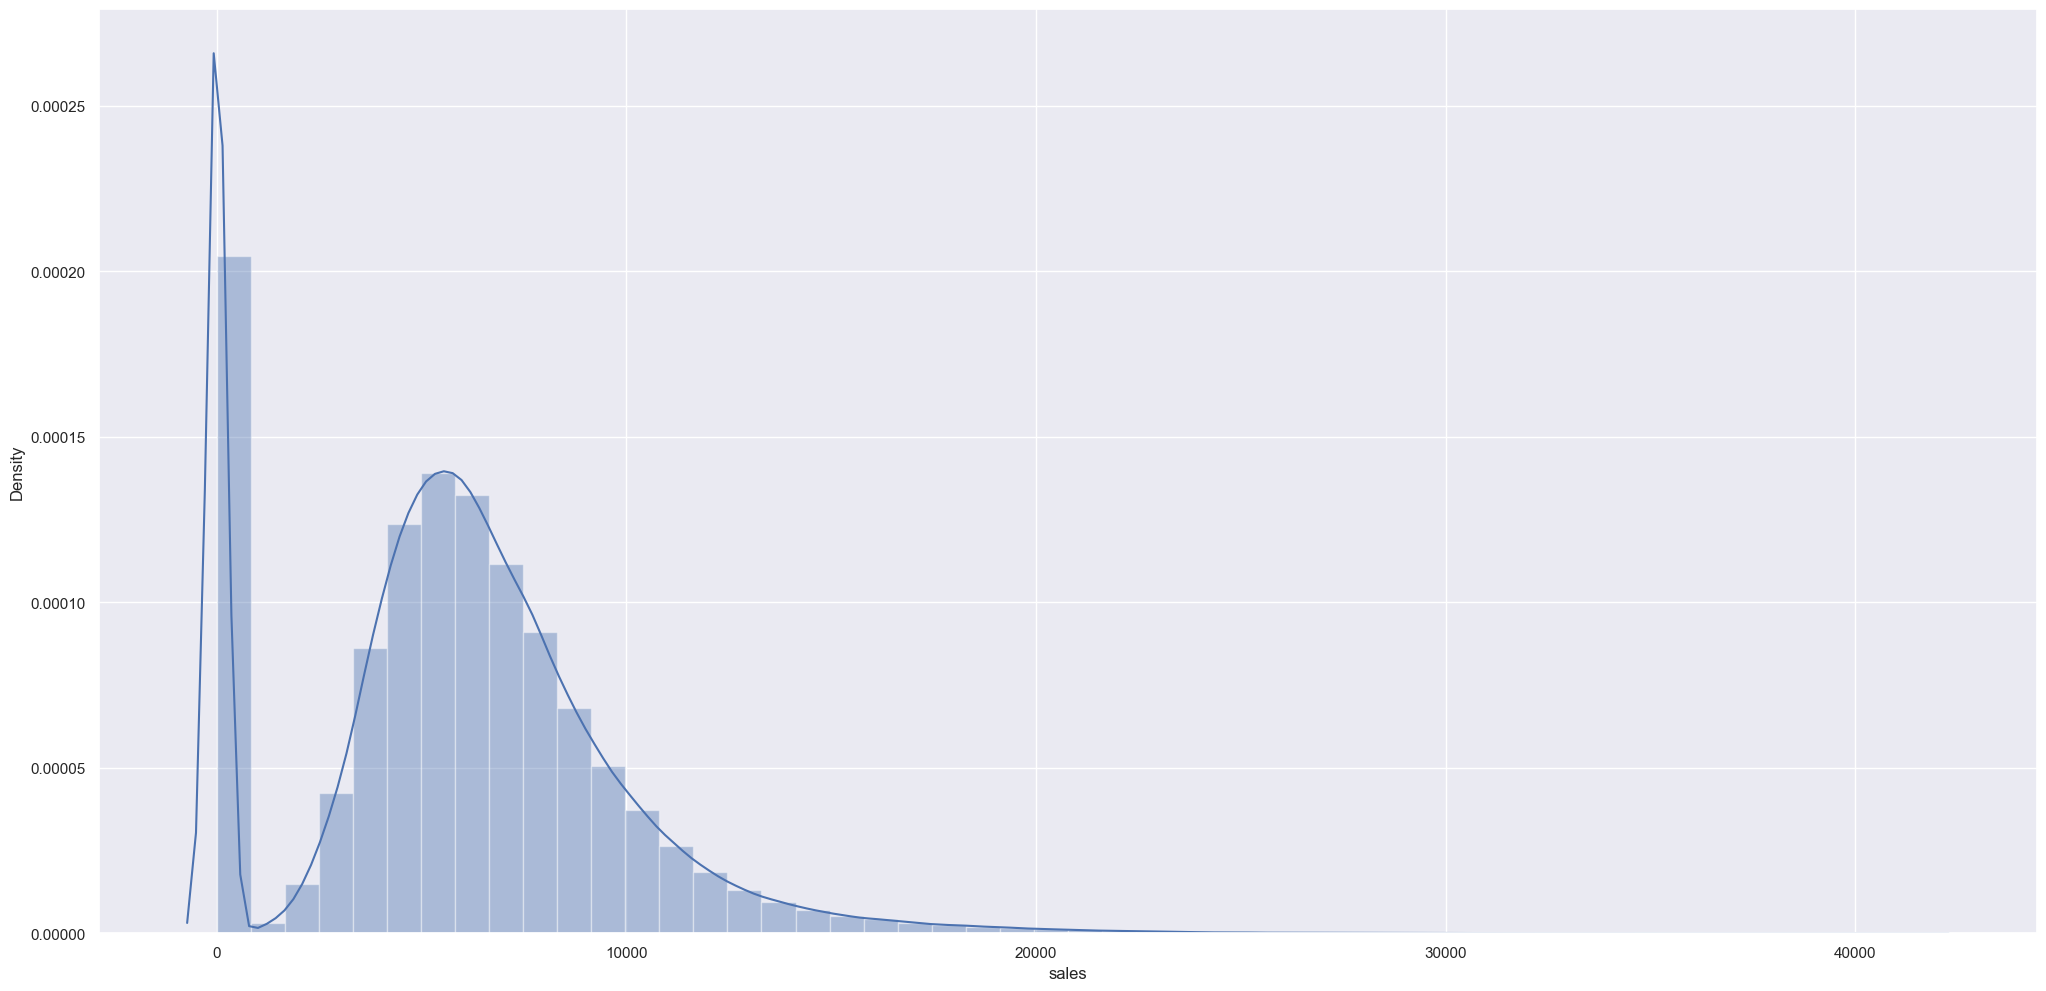

In [33]:
sns.distplot( df1['sales']  )

<Axes: xlabel='competition_distance', ylabel='Density'>

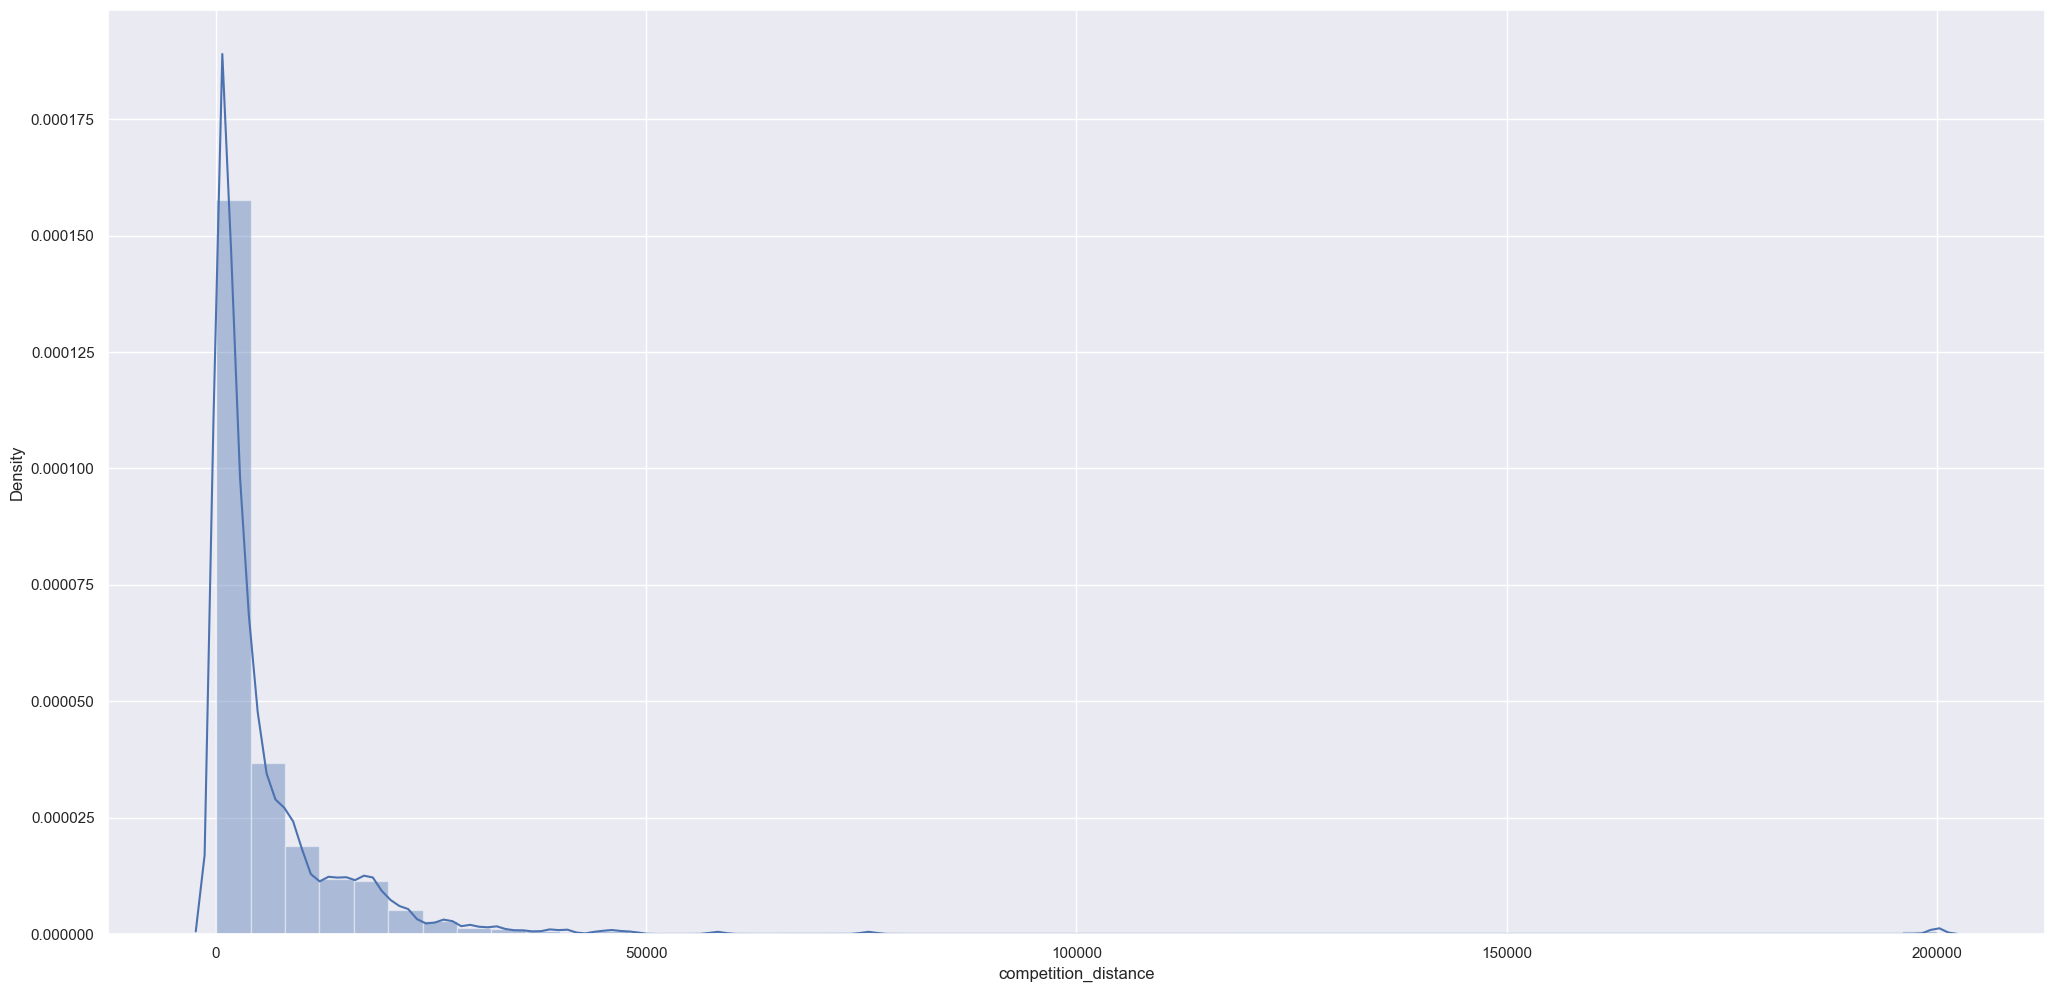

In [34]:
sns.distplot( df1['competition_distance']  )

## 2.7.2 Categorical Atributos

In [35]:
cat_atributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='state_holiday', ylabel='sales'>

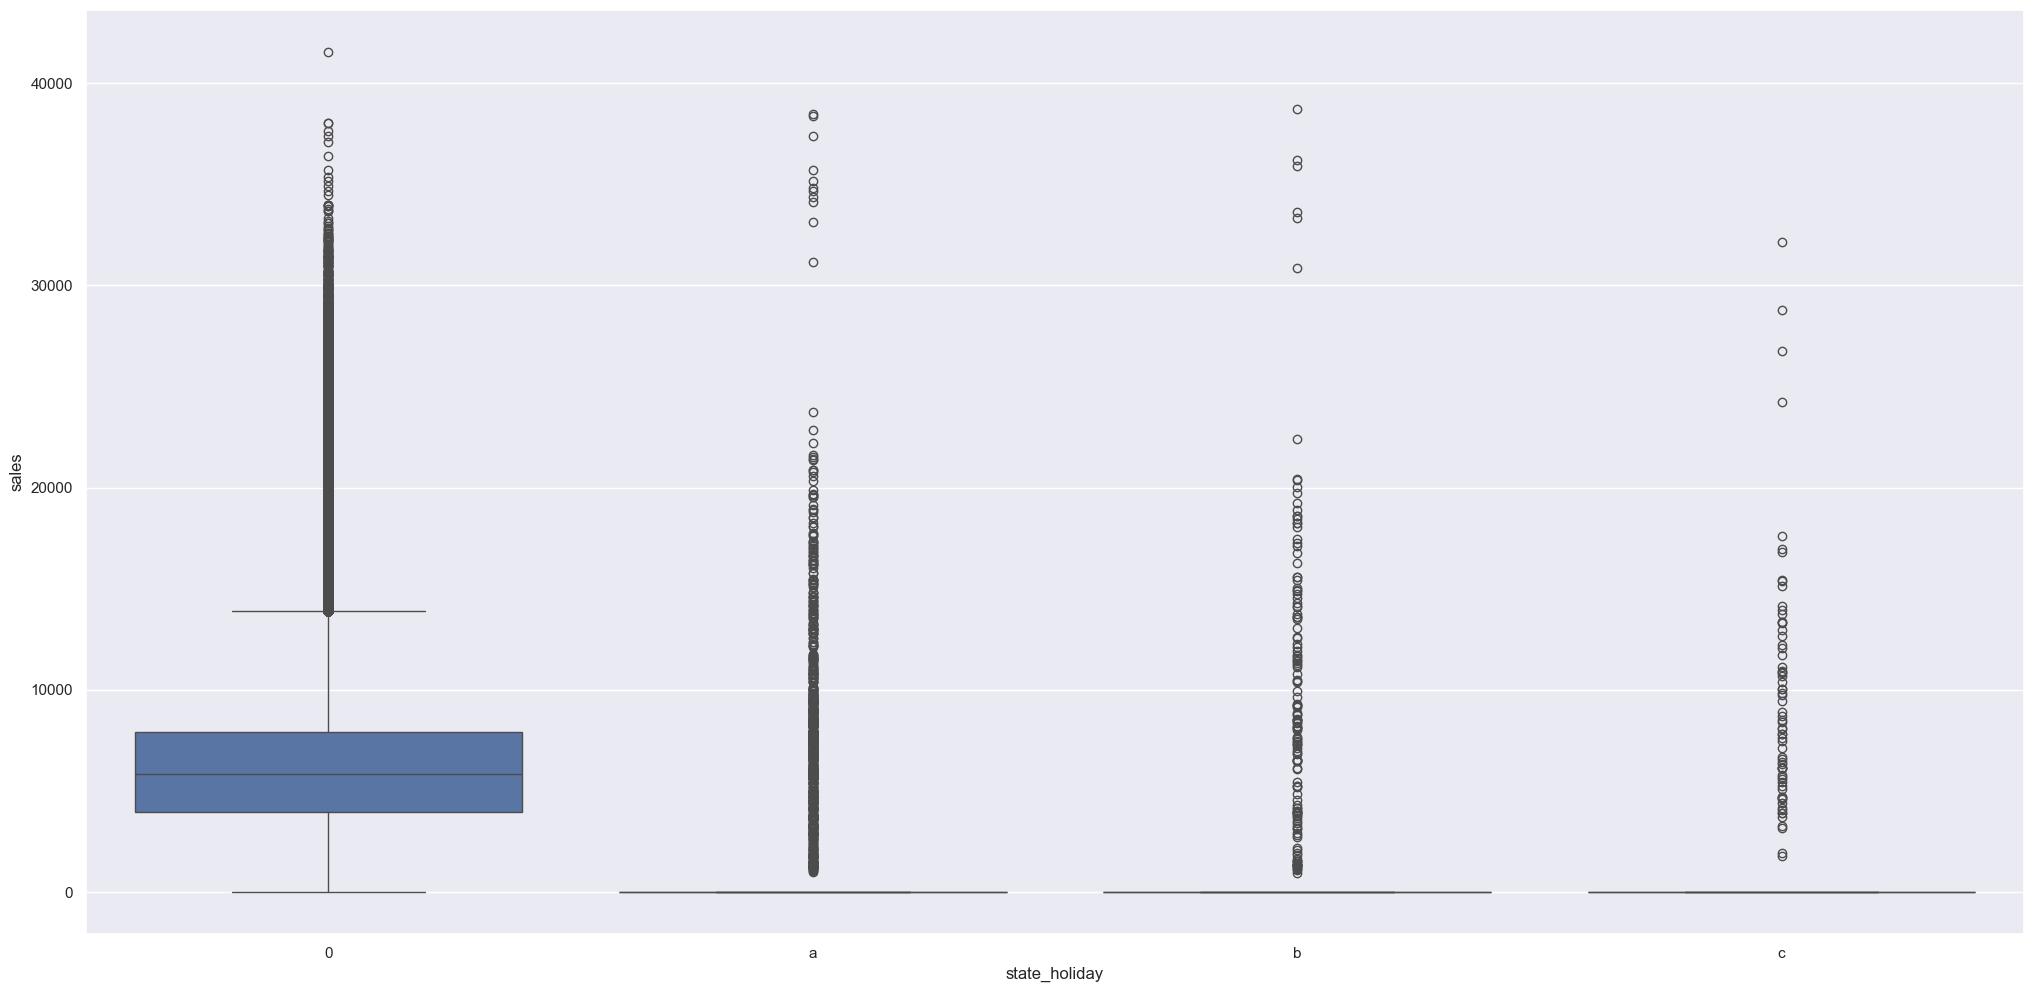

In [36]:
sns.boxplot(x = 'state_holiday', y='sales' , data=df1)

<Axes: xlabel='assortment', ylabel='sales'>

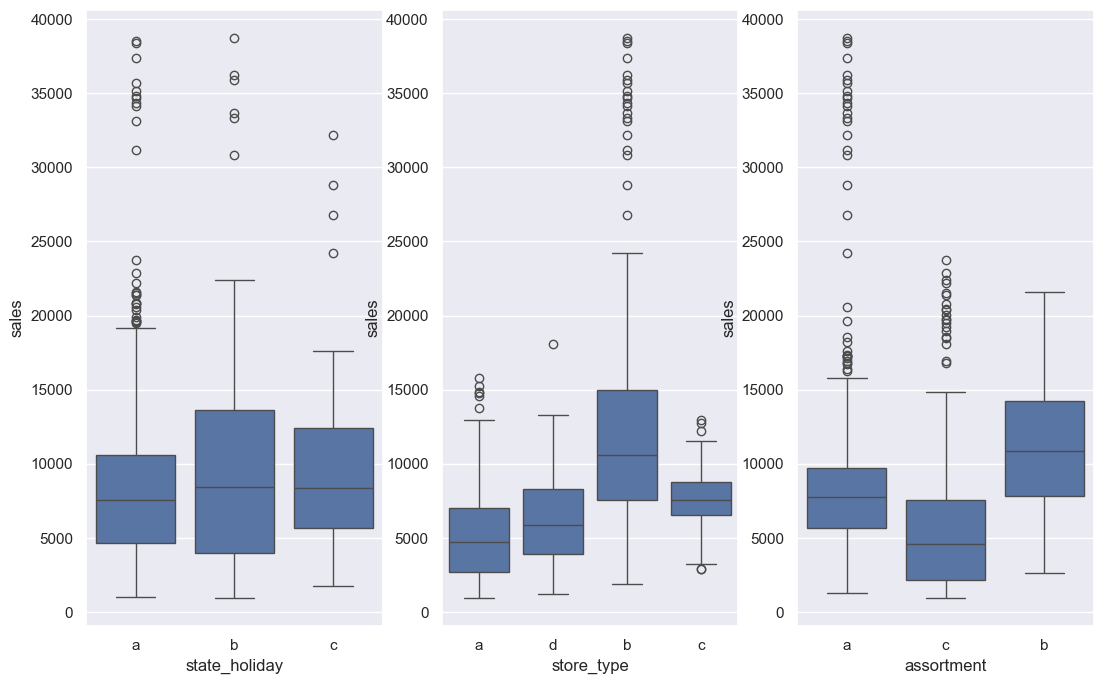

In [37]:
# melhorando a visualização removedo dias que não vendeu
#StateHoliday - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. 
#Observe que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado, b = feriado de Páscoa, c = Natal, 0 = Nenhum

aux1 = df1[ (df1['state_holiday'] != '0' ) & ( df1['sales']> 0 ) ]
plt.figure(figsize=(13, 8))

plt.subplot(1, 3, 1 )
sns.boxplot(x = 'state_holiday', y='sales' , data=aux1)


plt.subplot(1, 3, 2 )
sns.boxplot(x = 'store_type', y='sales' , data=aux1)


plt.subplot(1, 3, 3 )
sns.boxplot(x = 'assortment', y='sales' , data=aux1)




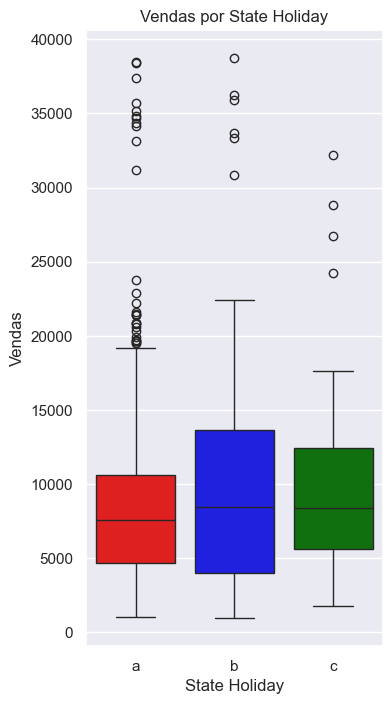

In [38]:


# Dados de exemplo
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(13, 8))

# Defina as cores para cada categoria
colors_state_holiday = {'a': 'red', 'b': 'blue', 'c': 'green', 'd': 'purple'}

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, palette=colors_state_holiday)
plt.title('Vendas por State Holiday')
plt.xlabel('State Holiday')
plt.ylabel('Vendas')

plt.show()


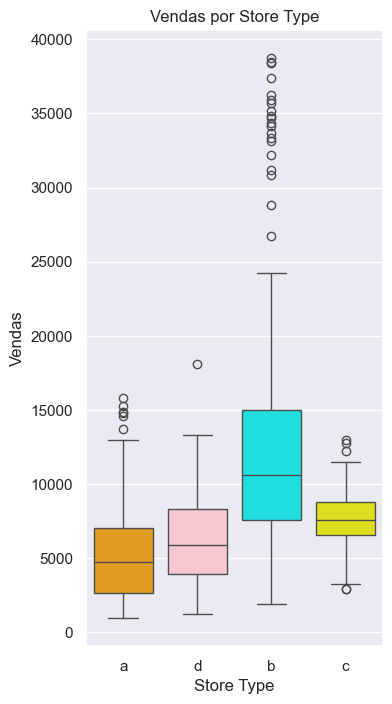

In [39]:
# Defina as cores para cada categoria
colors_store_type = {'a': 'orange', 'b': 'cyan', 'c': 'yellow', 'd': 'pink'}

plt.figure(figsize=(13, 8))

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1, palette=colors_store_type)
plt.title('Vendas por Store Type')
plt.xlabel('Store Type')
plt.ylabel('Vendas')

plt.show()


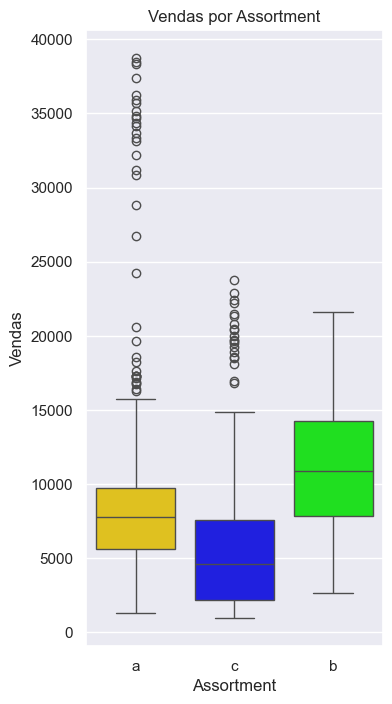

In [40]:
# Defina as cores para cada categoria
colors_assortment = {'a': 'gold', 'b': 'lime', 'c': 'blue'}

plt.figure(figsize=(13, 8))

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1, palette=colors_assortment)
plt.title('Vendas por Assortment')
plt.xlabel('Assortment')
plt.ylabel('Vendas')

plt.show()


Como funciona boxplot 
qual é a regra para outilier

# 3.0 Passo 02 - FEACTURE ENGINEERING

In [41]:
df2 = df1.copy()

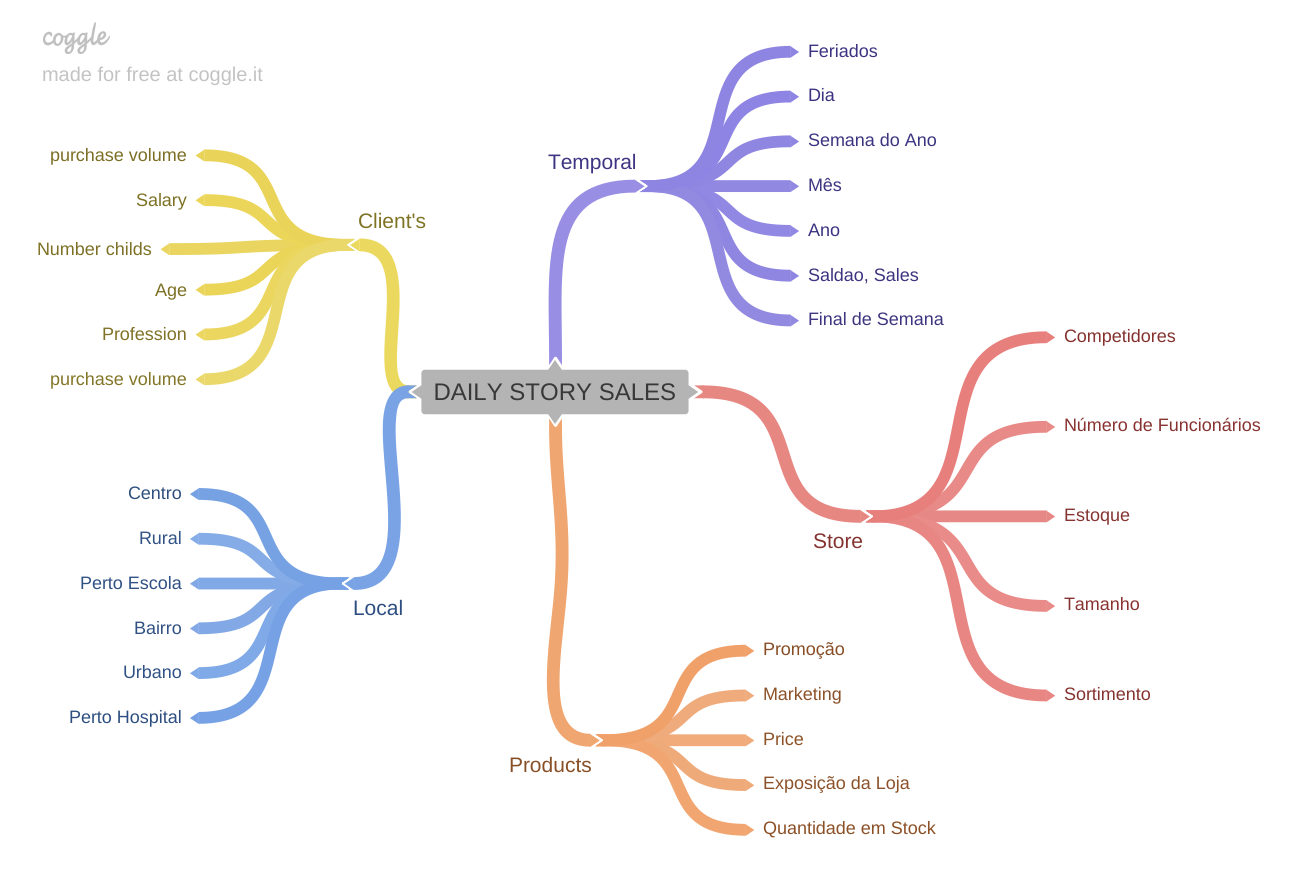

In [42]:
Image('img/MindMapHypothesis.png')

## 3.1. Criacao das Hipoteses

2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionário deveriam vende mais. 

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deverim vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Markting deveriam vender mais. 

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem menor preços nos produtos deveriam vender mais.

**4.** Lojas que tem preço menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas cocm mais promoções consecutivas deveriam vender mais.



2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam venderr mais no segundo semeestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana. 

**6.** Lojas deveriam venderr menos durante os feriados escolares


## 3.1.4 Hipoteses finais
vamos avaliar quais das hipóteses gerada eu tenho dados que me ajude a provar ou encontrar correlação.

                    --Lojas--

**1.** Lojas com maior sortimentos deveriam vender mais.

**1.** Lojas com competidores mais próximos deveriam vender menos. 

**1.** Lojas com competidores á mais tempo deveriam vender mais
                    
                    --Tempo--

**1.** Lojas cbertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos. 

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [43]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
#df2['week_of_year'] = df2['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [44]:
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )


df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )


df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )


df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
# assortment



df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


#  4.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [45]:
df3 = df2.copy()

## 4.1. Filtragem das Linhas

In [46]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 4.2. Selecao das Colunas

In [47]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

#  5.0. PASSO 05 - ANALISE EXPLORATORIA DOS DADOS

In [48]:
df4 = df3.copy()

## 5.1 Analise Univariada

A análise univariada, parte fundamental da AED, concentra-se em uma única variável. Ela envolve classificar a variável quanto ao tipo (qualitativa ou quantitativa) e obter tabelas, gráficos e medidas que resumam essa variável12. Por exemplo, podemos calcular a média, mediana, moda e intervalo dos dados3

<Axes: xlabel='sales', ylabel='Density'>

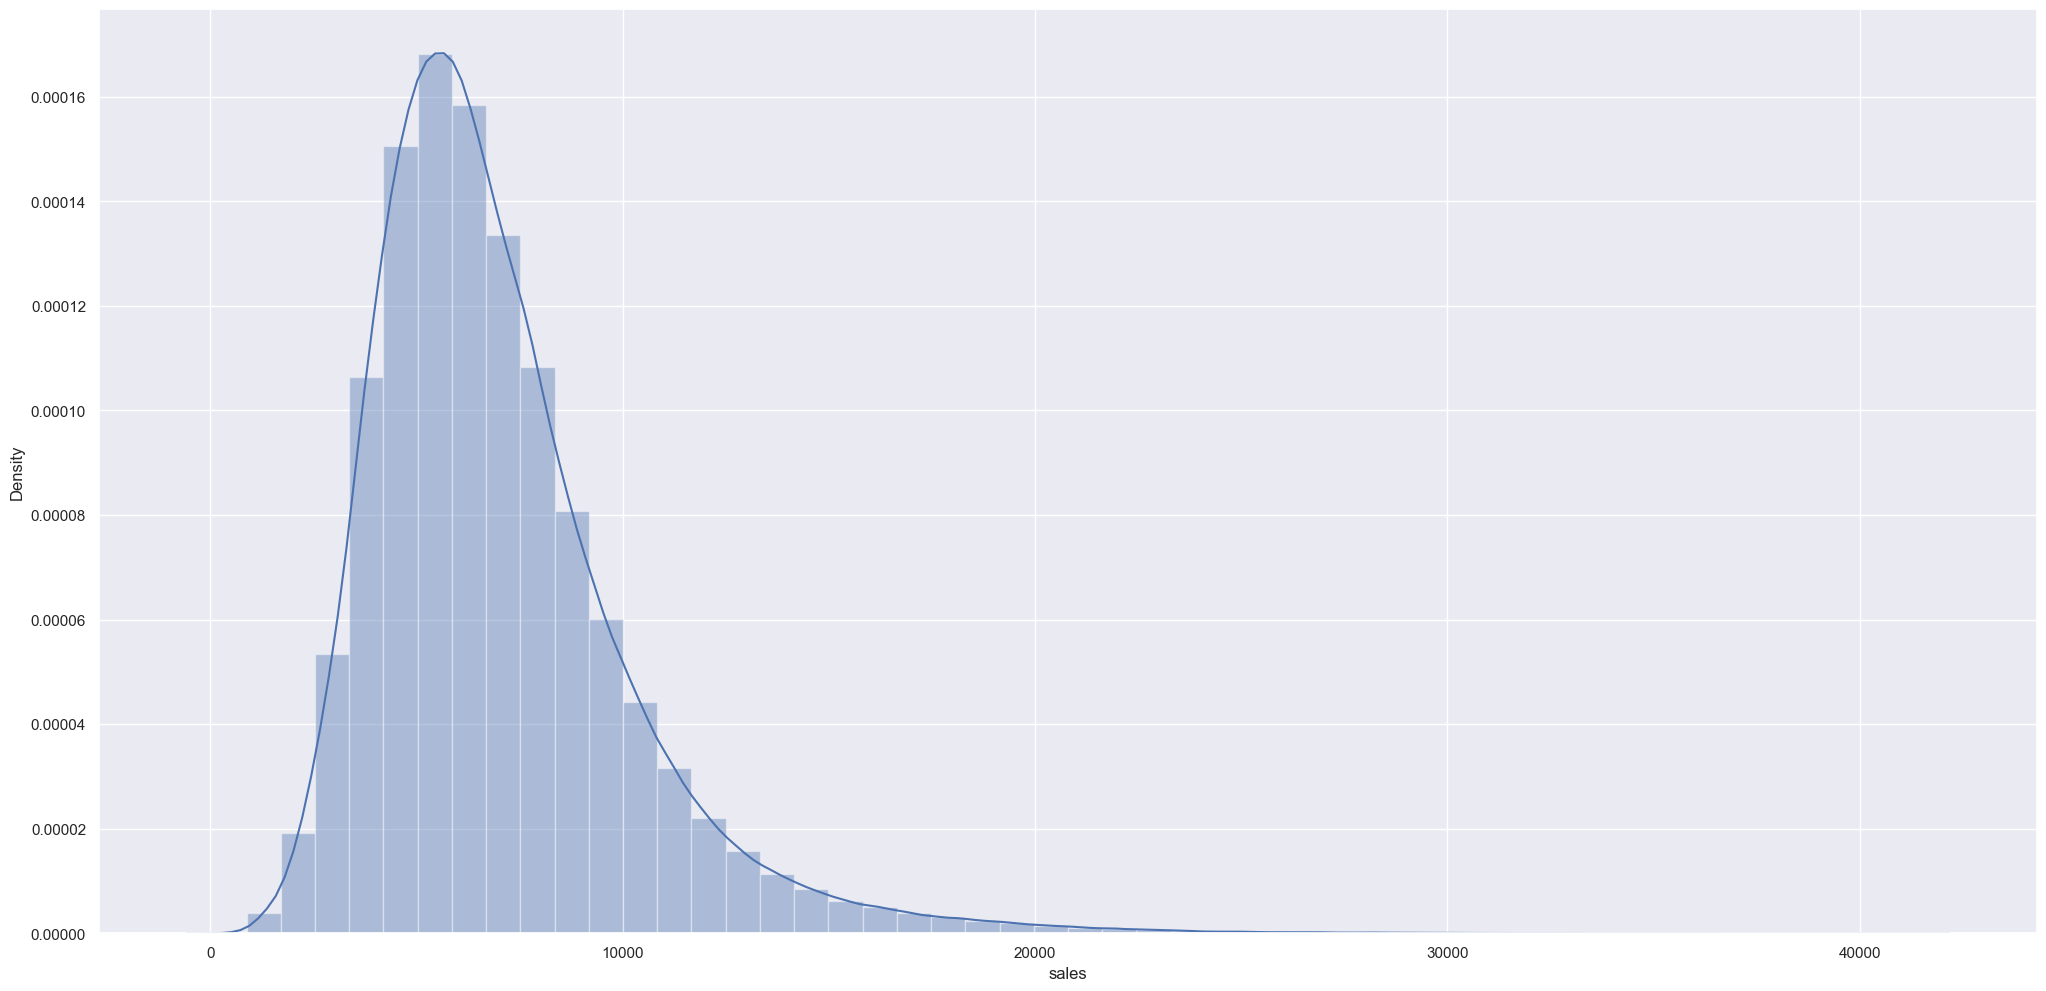

In [49]:
sns.distplot( df4['sales'], kde=True)

## 4.1.2. Numerical Variable

O objetivo da AED é entender a natureza dos dados, identificar tendências e avaliar a qualidade dos dados. Não se trata apenas de criar visualizações sofisticadas; o foco é obter insights e respostas a partir dos dados. AED é uma prática iterativa, permitindo ajustes conforme novos insights surgem. Existem dois tipos principais de dados estruturados: variáveis categóricas (com valores finitos) e valores numéricos (contínuos).12

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

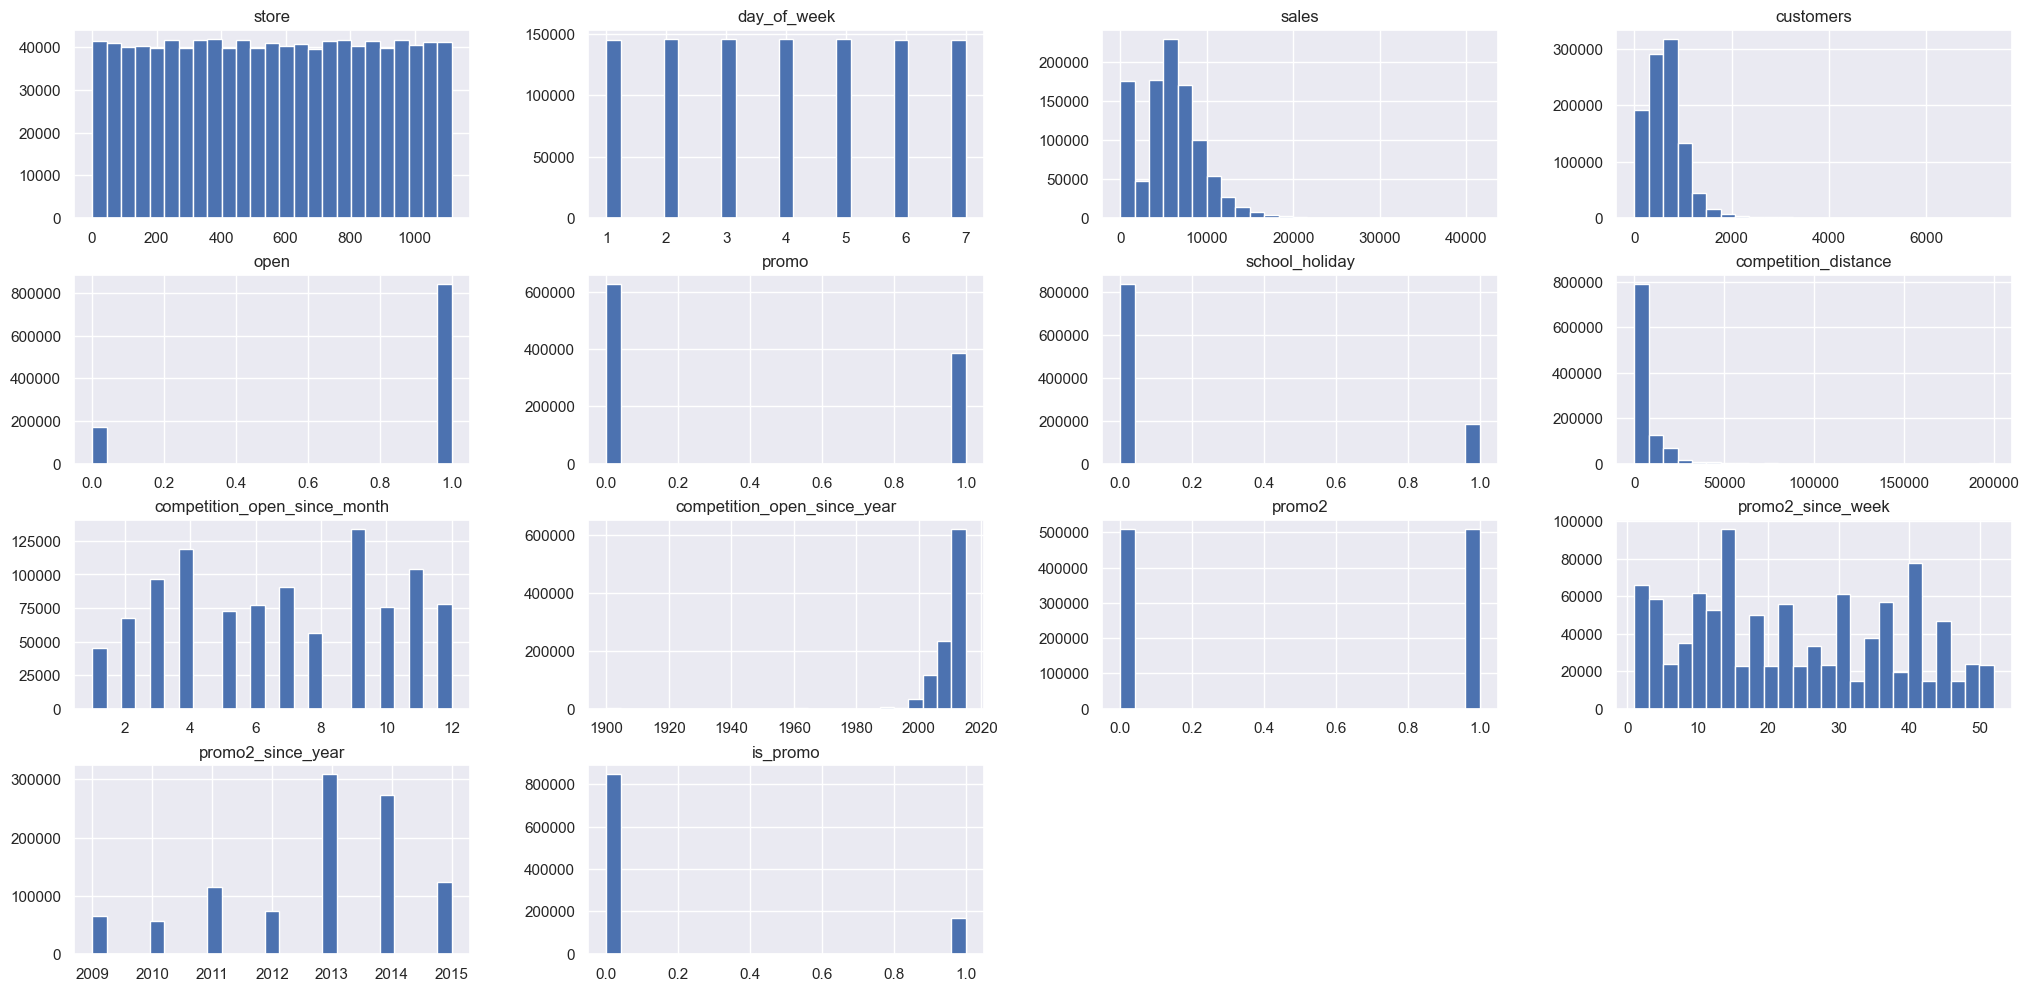

In [50]:
num_atributes.hist( bins = 25)

## 5.2. Categorical Variable

In [51]:
# Vamos viasualizar as variáveis categoricas
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable

<Axes: ylabel='Density'>

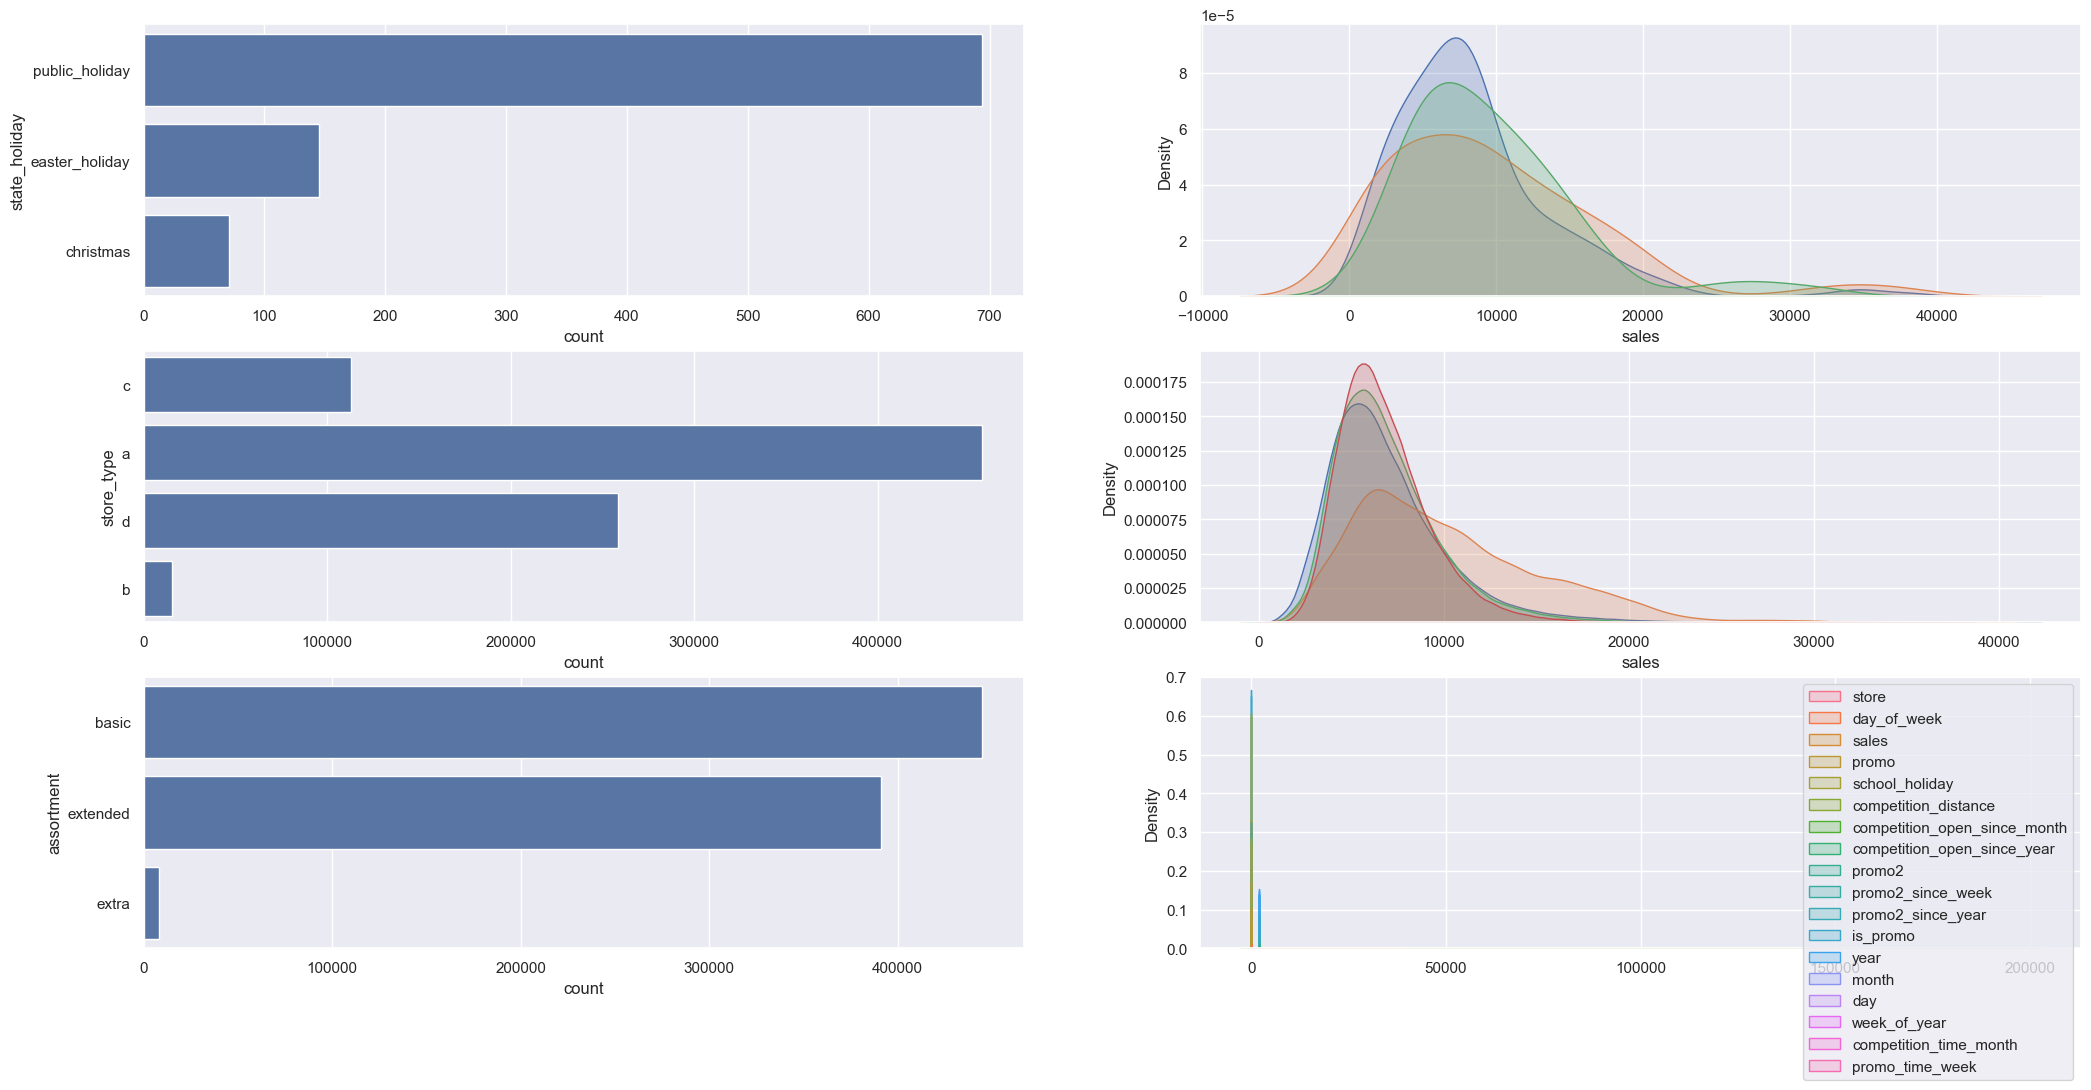

In [52]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] );
#sns.countplot(a, x="state_holiday" );

plt.subplot(3, 2, 2);
sns.kdeplot(df4[ df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True,  legend=True )
sns.kdeplot(df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True,  legend=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True,  legend=True)

# store_type
plt.subplot(3 , 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label  = 'a', fill = True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label  = 'b', fill = True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label  = 'c', fill = True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label  = 'd', fill = True)

# assortment
plt.subplot(3 , 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'basic'],    label = 'basic',    fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra'],    label = 'extra',    fill = True)

<Axes: xlabel='sales', ylabel='Density'>

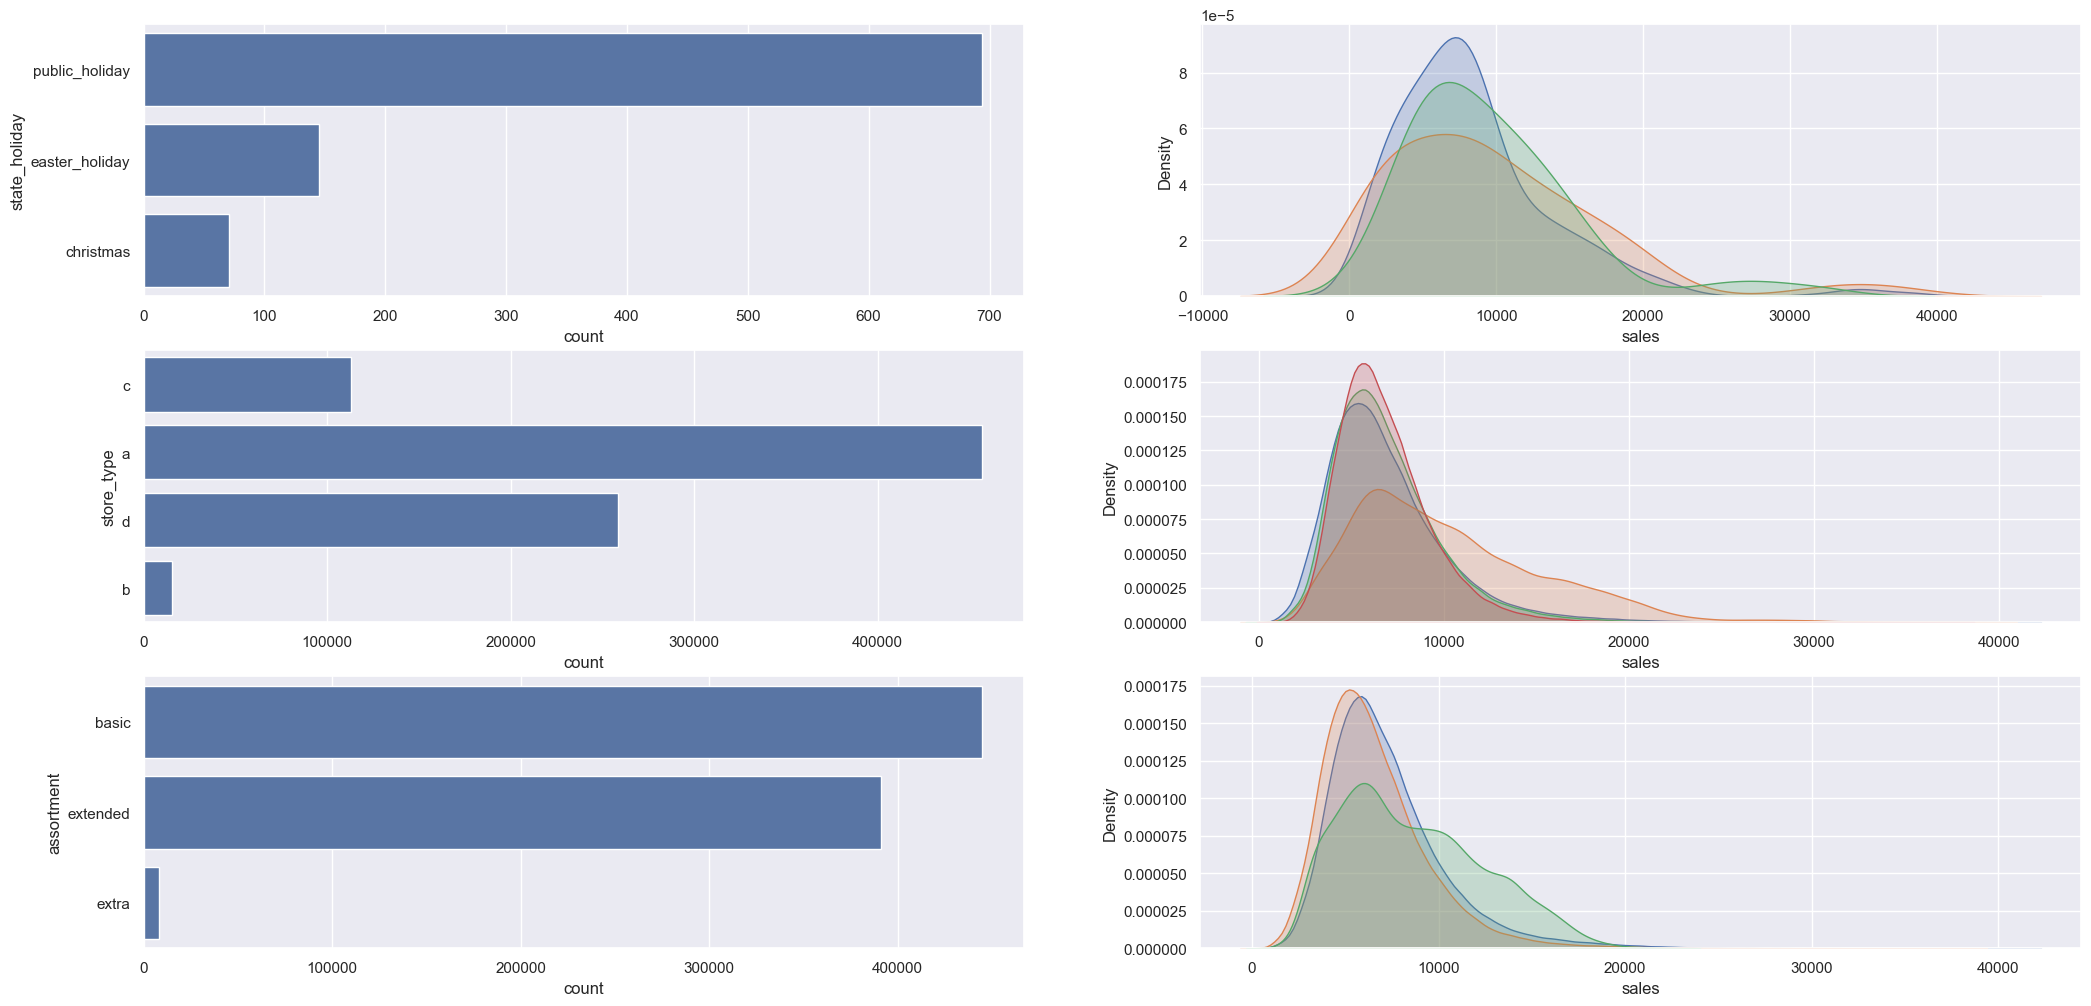

In [53]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'],    label='basic',    fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'],    label='extra',    fill=True )

In [54]:
a.head()

store  day_of_week       date  sales  promo   state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
63559      5            4 2015-06-04   5807      1  public_holiday               0          a      basic               29910.0                             4                         2015       0                 23               2015         0  2015      6    4            23   2015-22        2015-04-01                       2  2015-06-01                0
63560      6            4 2015-06-04   5749      1  public_holiday               0          a      basic                 310.0                            12                         2013       0                 23               2015         0  2015      6    4            23   2015-22        2013-12-01                      18  2015-06-01                0
63609     55            4 2015-06-04   5984      1  public_holiday               0          a      basic                 720.0                            11                         2004       0                 23               2015         0  2015      6    4            23   2015-22        2004-11-01                     128  2015-06-01                0
63611     57            4 2015-06-04   9301      1  public_holiday               0          d   extended                 420.0                             6                         2014       0                 23               2015         0  2015      6    4            23   2015-22        2014-06-01                      12  2015-06-01                0
63614     60            4 2015-06-04  10399      1  public_holiday               0          d   extended                5540.0                            10                         2009       0                 23               2015         0  2015      6    4            23   2015-22        2009-10-01                      69  2015-06-01                0

## 5.2. Analise Bivariada 

### 5.2.1 H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

In [55]:
a = df4.loc[:, ['assortment','sales'] ].groupby('assortment').sum()
a.head()

sales
assortment            
basic       2945750070
extended    2856484241
extra         70946312

In [56]:
aux1 = df4.loc[:, ['assortment','sales'] ].groupby('assortment').sum().reset_index()
a.head()

sales
assortment            
basic       2945750070
extended    2856484241
extra         70946312

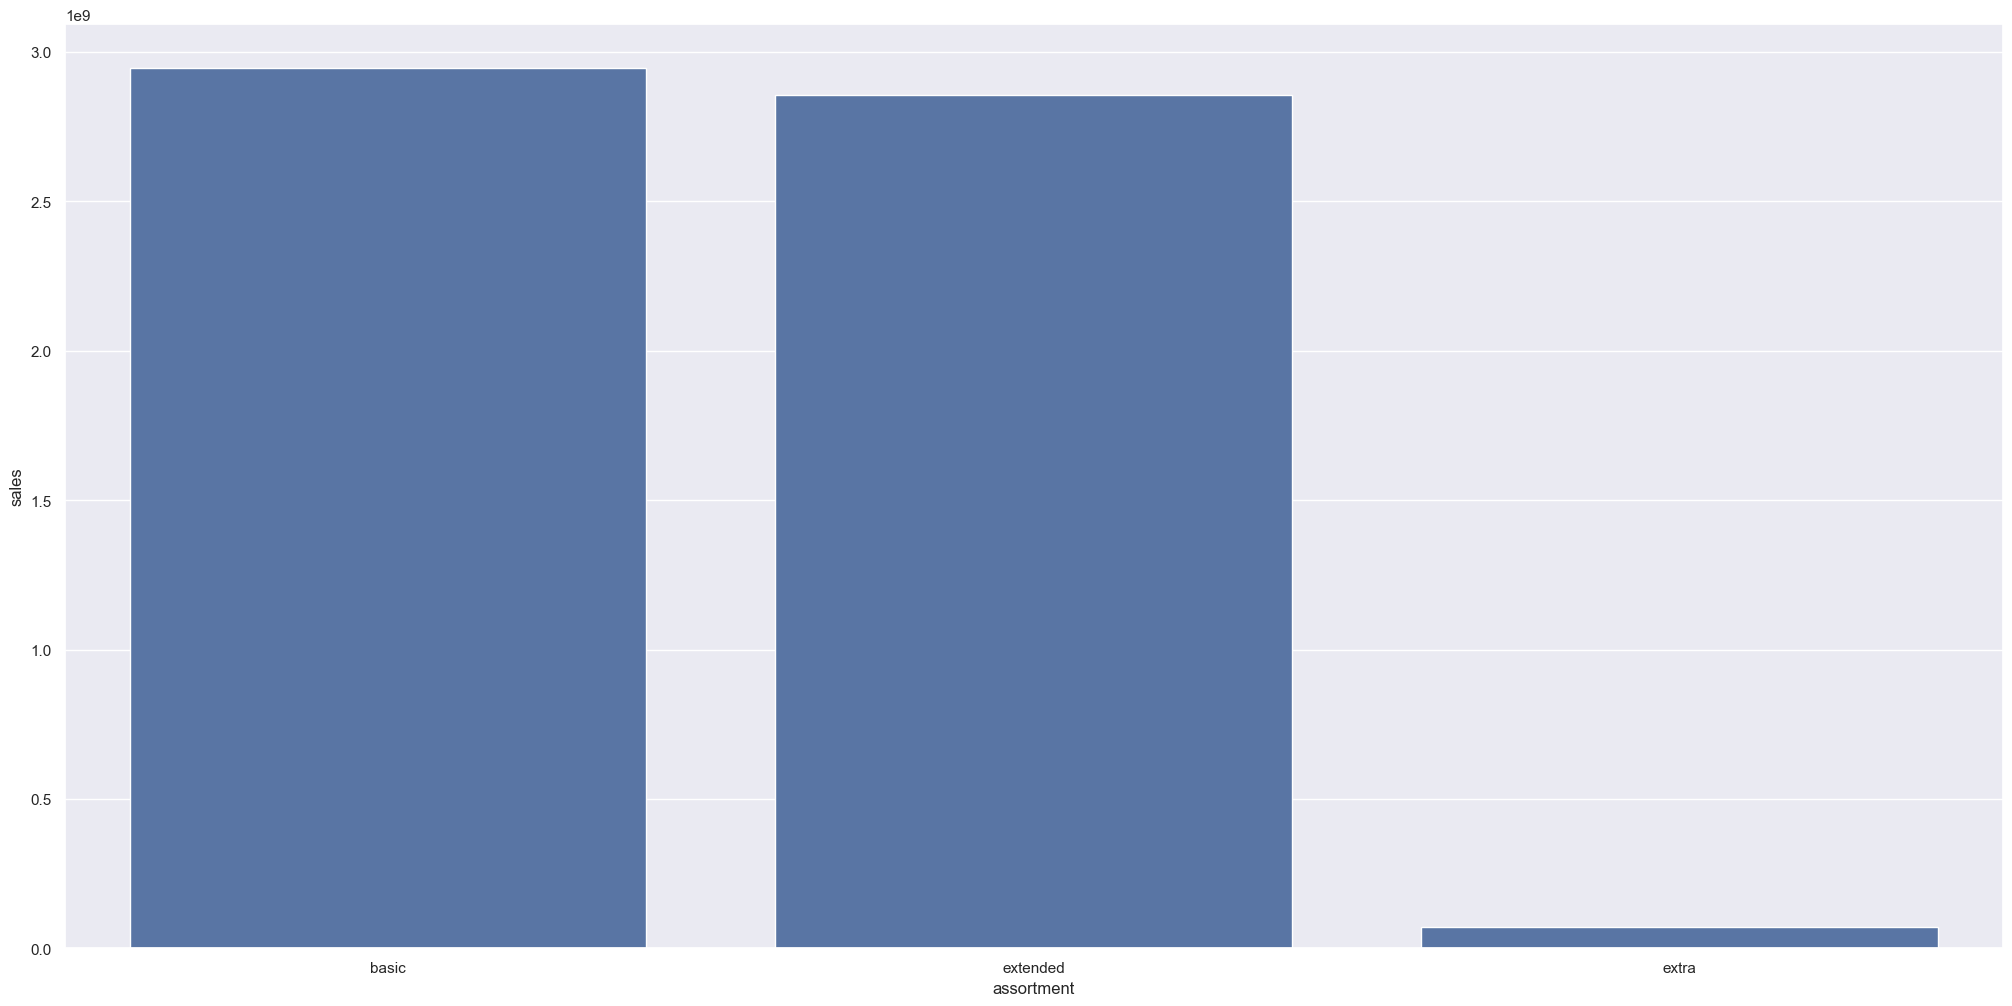

In [57]:
sns.barplot( x='assortment', y='sales', data=aux1 );

observe que extra tem menos na soma geral, de todas as lojas, vamos agora ver o comportamento das vendas durante o ano.


In [58]:
df4.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226
3      4            5 2015-07-31  13995      1   regular_day               1          c   extended                 620.0                             9                         2009       0                 31               2015         0  2015      7   31            31   2015-30        2009-09-01                      71  2015-07-27                0
4      5            5 2015-07-31   4822      1   regular_day               1          a      basic               29910.0                             4                         2015       0                 31               2015         0  2015      7   31            31   2015-30        2015-04-01                       4  2015-07-27                0

<Axes: xlabel='year_week'>

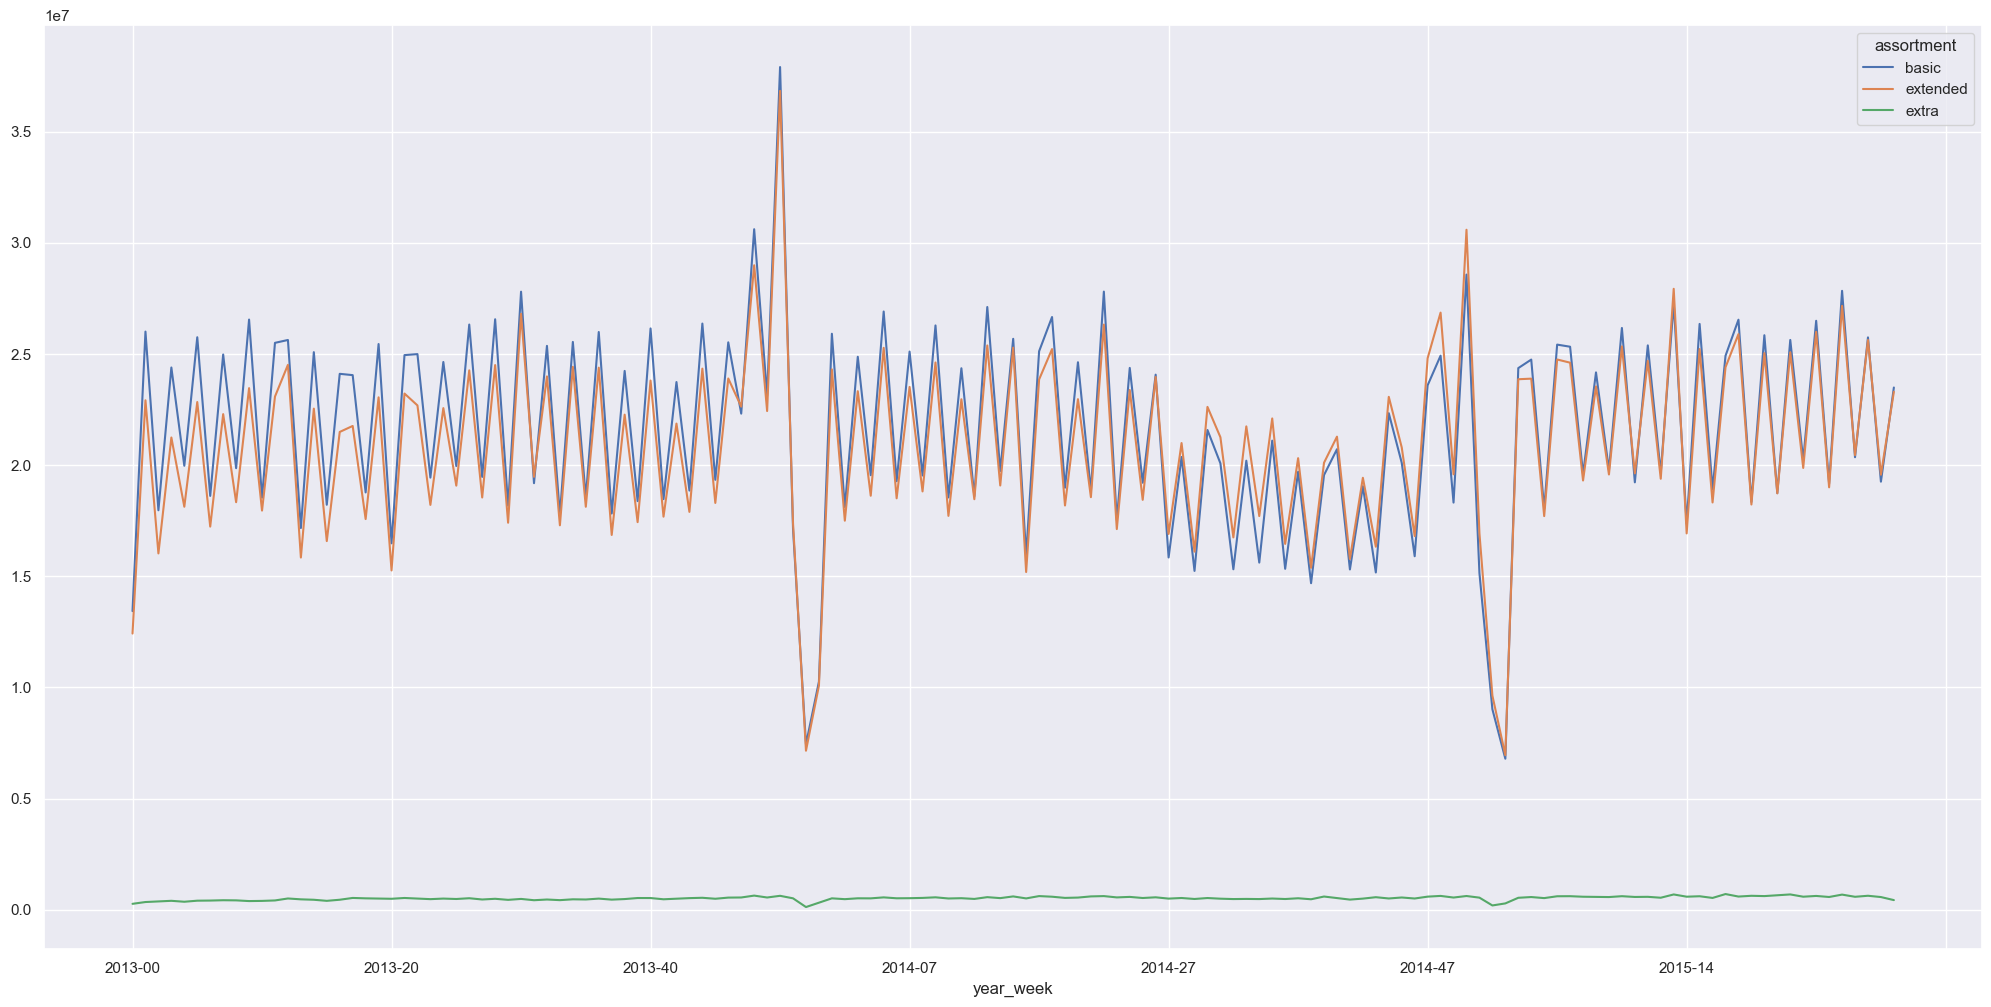

In [59]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.head()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

observe que comportamento do 'basic' e 'extended' são próximos, e que o comportamento extra parece o quanto tendendo a linear, contudo, ele tem uma escala menor que os outros e pode estar sendo influenciado por isto.


In [60]:
a = df4[df4['assortment'] == 'extra']

<Axes: xlabel='year_week'>

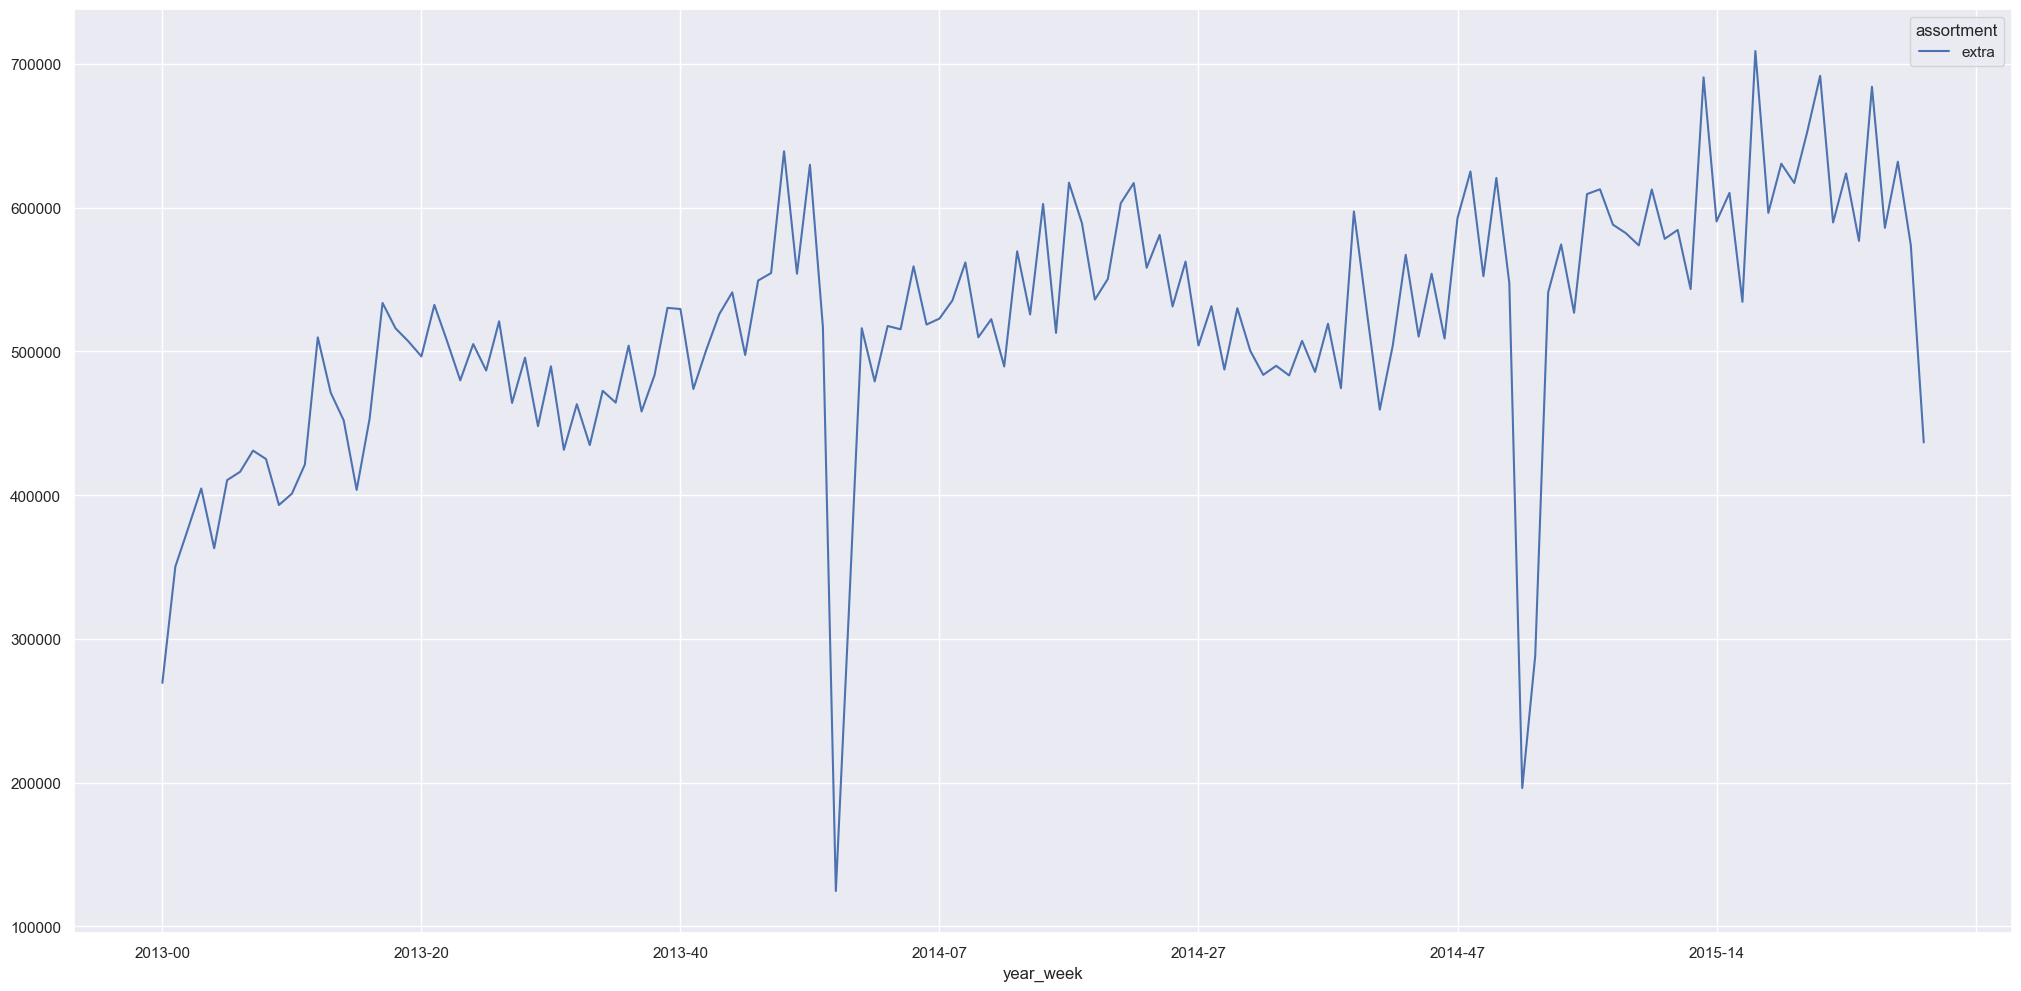

In [61]:
aux3 = a[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()


Observe que ele não tem um comportamento que tende a linear, como gráfico anterior mostra!

### 5.2.2 H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

Pandas cut() function is used to separate the array elements into different bins . The cut function is mainly used to perform statistical analysis on scalar data

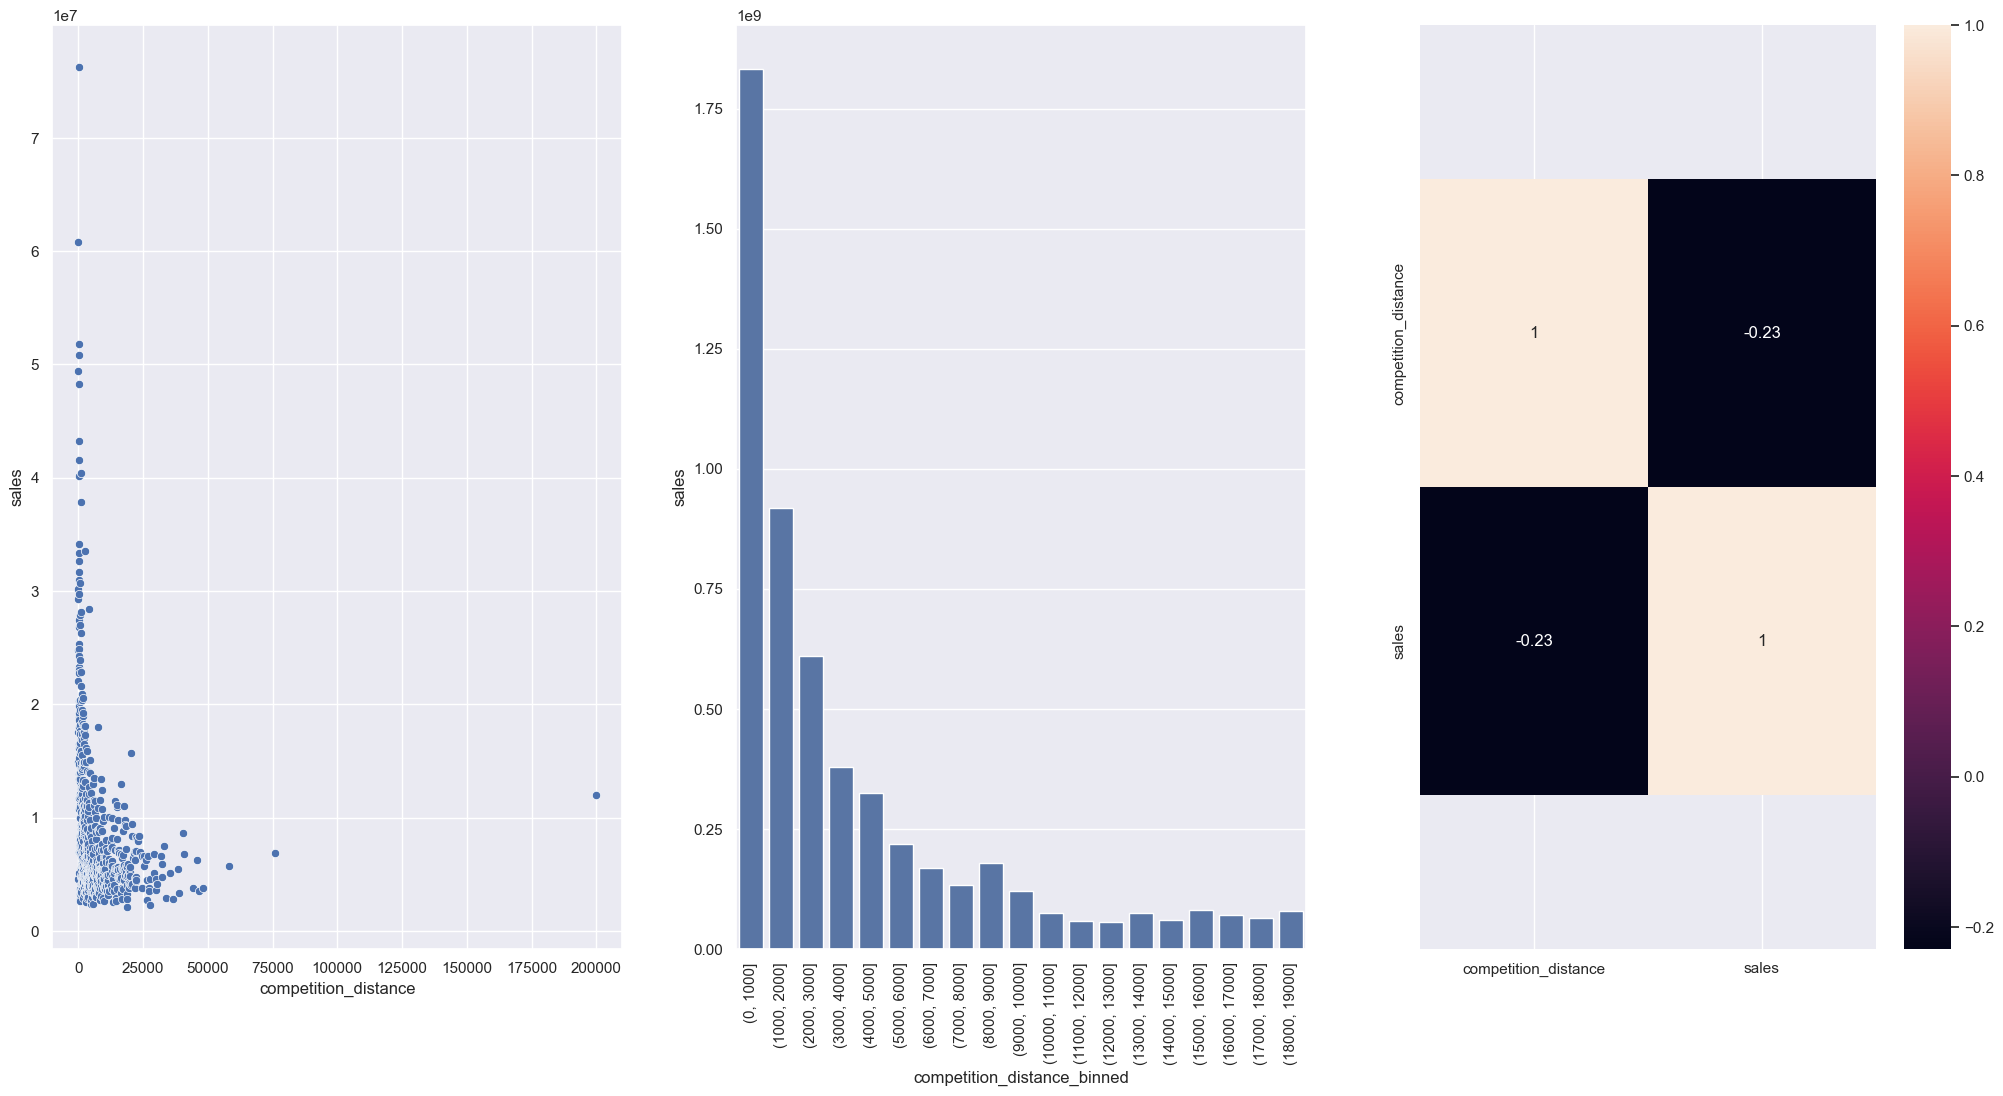

In [62]:
# sales, competition_distance. aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
#aux1.head(5)
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
bins = list( np.arange( 0, 20000, 1000) ) # [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index();

sns.barplot(x = 'competition_distance_binned', y = 'sales', data= aux2);
plt.xticks( rotation = 90)


aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);


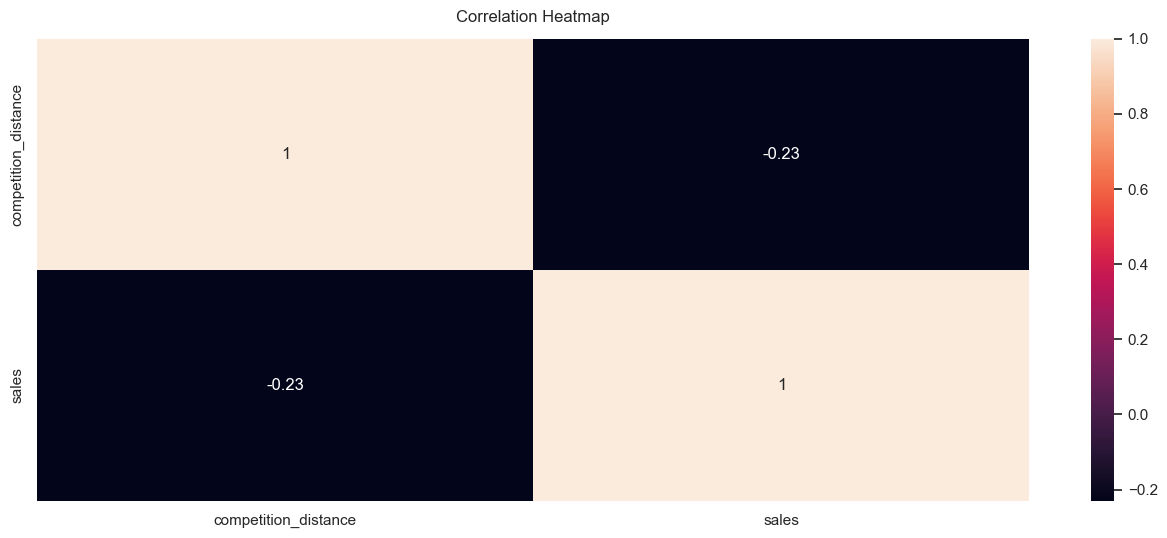

In [63]:
plt.figure(figsize=(16, 6))# Gera a figura
heatmap= sns.heatmap(aux1.corr(), annot=True); # aux1.corr() gera a correlação
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); # Adiciona título e formatação

heatmap o que é ?

o que é o método de pearson ?

### 5.2.3 H3. Lojas com competidores à mais tempo deveriam vendem mais. 
FALSE Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

In [64]:
#Quais anos estou trabalhando ?
#df4['year'].unique() -> array([2015, 2014, 2013])
#df4['competition_since'].unique() de 1998 a 2015 abriu lojas concorrentes

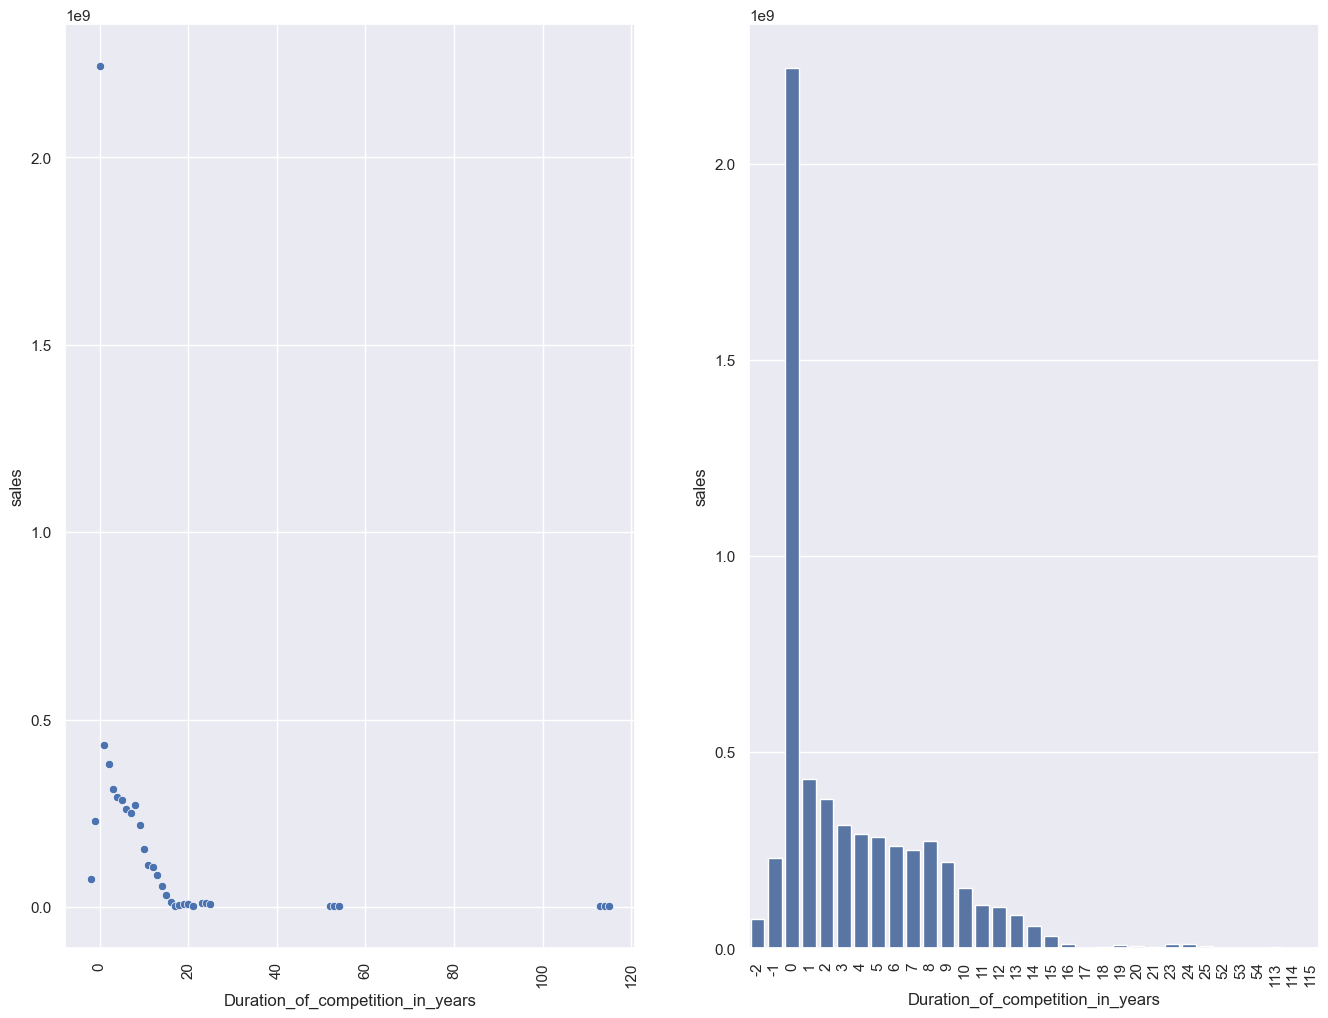

In [65]:
df4['Duration_of_competition_in_years'] = df4['year'] - df4['competition_open_since_year'];

aux1 = df4[['Duration_of_competition_in_years', 'sales']].groupby('Duration_of_competition_in_years').sum().reset_index();
plt.subplot(1, 3, 1)
sns.scatterplot(x ='Duration_of_competition_in_years' , y ='sales' , data = aux1);
plt.xticks( rotation = 90);

plt.subplot(1, 3, 2)
sns.barplot(x ='Duration_of_competition_in_years' , y ='sales' , data = aux1)
plt.xticks( rotation = 90);


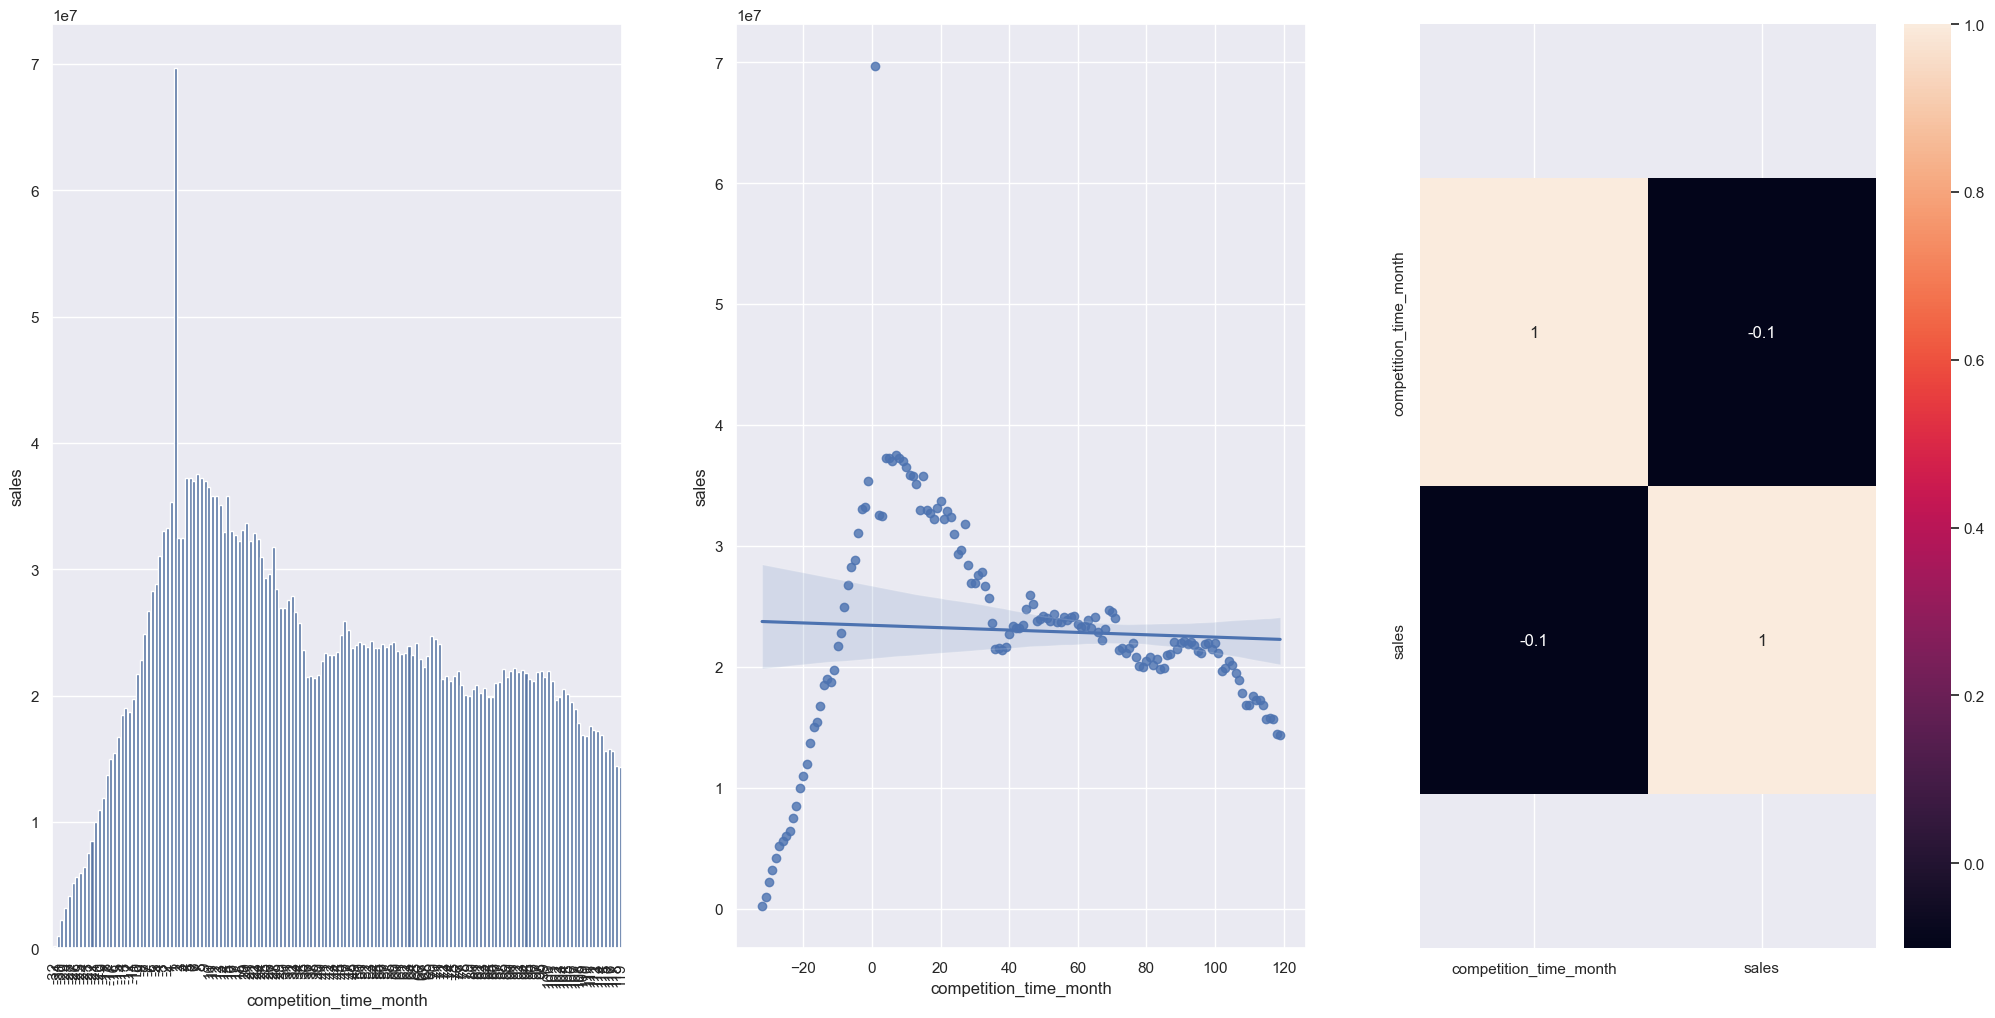

In [66]:
#Como o professor fez
plt.subplot( 1, 3, 1 )
#Agrupando os dados que interessam
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()

#seleção das variáveis importante e descartar o que não serve!
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )

# Gerando um gráfico de regressão aos dados fornecido
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

# Correlação
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### 5.2.4 H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

 Quais variáveis estão envolvidas 
 *promo
 *promo2
 *promo2_since_week	
 *promo2_since_year 
 * Observar à página Kaggle sobre a datas da promo 
 Detalhes
 *store_type
 *assortment
 *competition_distance
 *competition_open_since_month
 *competition_open_since_year

In [67]:
df4.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  Duration_of_competition_in_years
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0                                 7
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279                                 8
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226                                 9
3      4            5 2015-07-31  13995      1   regular_day               1          c   extended                 620.0                             9                         2009       0                 31               2015         0  2015      7   31            31   2015-30        2009-09-01                      71  2015-07-27                0                                 6
4      5            5 2015-07-31   4822      1   regular_day               1          a      basic               29910.0                             4                         2015       0                 31               2015         0  2015      7   31            31   2015-30        2015-04-01                       4  2015-07-27                0                                 0

In [68]:
colunas = ['sales','promo_since',	'promo_time_week',
            'is_promo',	'year',	'month',	'day',	'week_of_year',	'year_week', 
            'promo2',	'promo2_since_week',	'promo2_since_year',
            'date',	'promo', 'state_holiday'	]

In [69]:
dp= df4.loc[:,colunas]
dp.dtypes

sales                         int64
promo_since          datetime64[ns]
promo_time_week               int32
is_promo                      int64
year                          int32
month                         int32
day                           int32
week_of_year                 UInt32
year_week                    object
promo2                        int64
promo2_since_week             int32
promo2_since_year             int32
date                 datetime64[ns]
promo                         int64
state_holiday                object
dtype: object

In [70]:
dp = dp[dp['state_holiday'] == 'regular_day']

In [71]:
dp.loc[:,['is_promo', 'promo2', 'promo']].head()

is_promo  promo2  promo
0         0       0      1
1         1       1      1
2         1       1      1
3         0       0      1
4         0       0      1

In [72]:
# Tem duas condições, is_promo and promo2 são o filtro
# Vamos grupar sales, is_promo, promo2, promo2_since_week
# dp['month'].unique() [ 7,  6,  5,  4,  3,  2,  1, 12, 11, 10,  9,  8])
# Vamos gerar os seguintes gráficos
# primeira figura observar venda por mês vamos filtra pela promos 

aux_p1 = dp[(dp['promo']  == 1) & (dp['promo2']  == 0)]

aux_p1 =  aux_p1[['sales', 'month', ]].groupby('month').sum().reset_index()


#---------------
aux_p2 = dp[(dp['promo2']  == 1) & (dp['promo']  == 0)]

aux_p2 =  aux_p2[['sales', 'month']].groupby('month').sum().reset_index()
#---------------
aux_p1_2 = dp[(dp['promo2']  == 1) & (dp['promo']  == 1)]

aux_p1_2 =  aux_p1_2[['sales', 'month']].groupby('month').sum().reset_index()
#---------------
aux_p0 = dp[(dp['promo2']  == 0) & (dp['promo']  == 0) ]

aux_p0 =  aux_p0[['sales', 'month']].groupby('month').sum().reset_index()





In [73]:
aux_p1.head()

month      sales
0      1  152308892
1      2  133182321
2      3  173051449
3      4  164006147
4      5  150152120

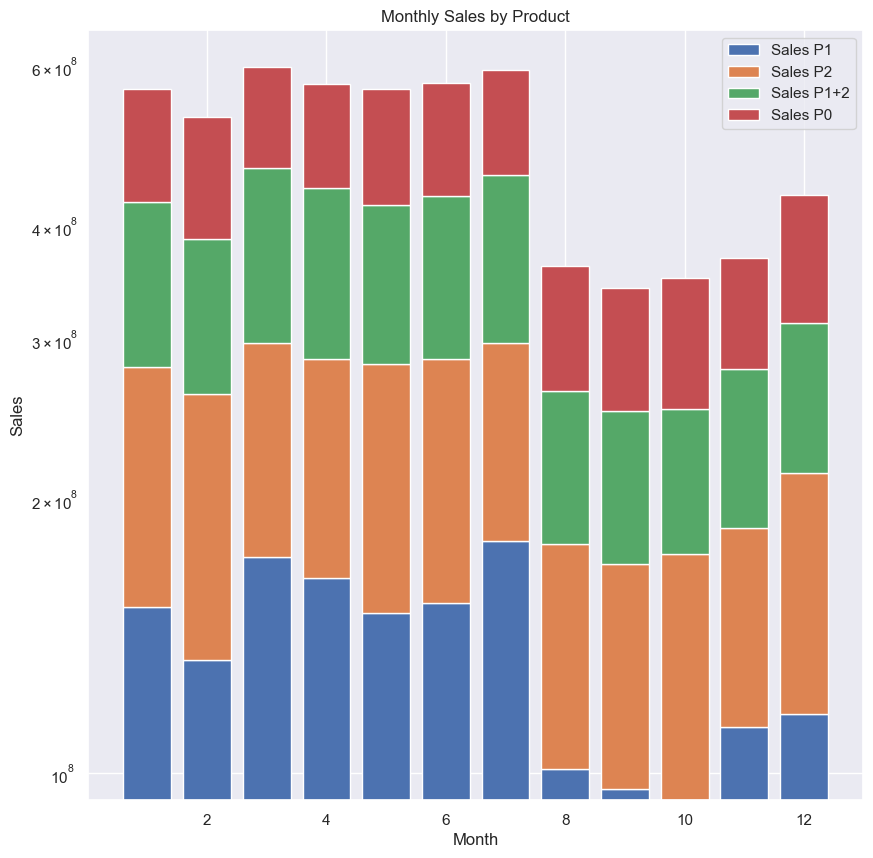

In [74]:




aux_p1['sales_p1'] = aux_p1['sales']

aux_p2['sales_p2'] = aux_p2['sales']

aux_p1_2['sales_p1_2'] = aux_p1_2['sales']

aux_p0['sales_p0'] = aux_p0['sales']

df_sale = pd.merge( aux_p1, aux_p2, how = 'left', on = 'month' )
df_sals = pd.merge( aux_p0, aux_p1_2, how = 'left', on = 'month' )
df_sales = pd.merge( df_sale, df_sals, how = 'left', on = 'month' )

# Defina os valores para o eixo X (meses)
x = df_sales['month']

# Defina os valores para os eixos Y (vendas)
y1 = df_sales['sales_p1']
y2 = df_sales['sales_p2']
y3 = df_sales['sales_p1_2']
y4 = df_sales['sales_p0']

# Crie o gráfico de barras
plt.figure(figsize=(10, 10))
plt.bar(x, y1, label='Sales P1')
plt.bar(x, y2, label='Sales P2', bottom=y1)
plt.bar(x, y3, label='Sales P1+2', bottom=y1+y2)
plt.bar(x, y4, label='Sales P0', bottom=y1+y2+y3)

# Personalize o gráfico (título, rótulos etc.)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales by Product')
plt.legend()

# Exiba o gráfico
plt.yscale('log')

plt.show()



In [75]:
df_sales.head()

month  sales_x_x   sales_p1  sales_y_x   sales_p2  sales_x_y   sales_p0  sales_y_y  sales_p1_2
0      1  152308892  152308892  127951663  127951663  140355917  140355917  145707709   145707709
1      2  133182321  133182321  128468638  128468638  141132523  141132523  125950928   125950928
2      3  173051449  173051449  124554904  124554904  135831797  135831797  166179835   166179835
3      4  164006147  164006147  122036770  122036770  134068784  134068784  154563771   154563771
4      5  150152120  150152120  131818327  131818327  143989828  143989828  140531356   140531356

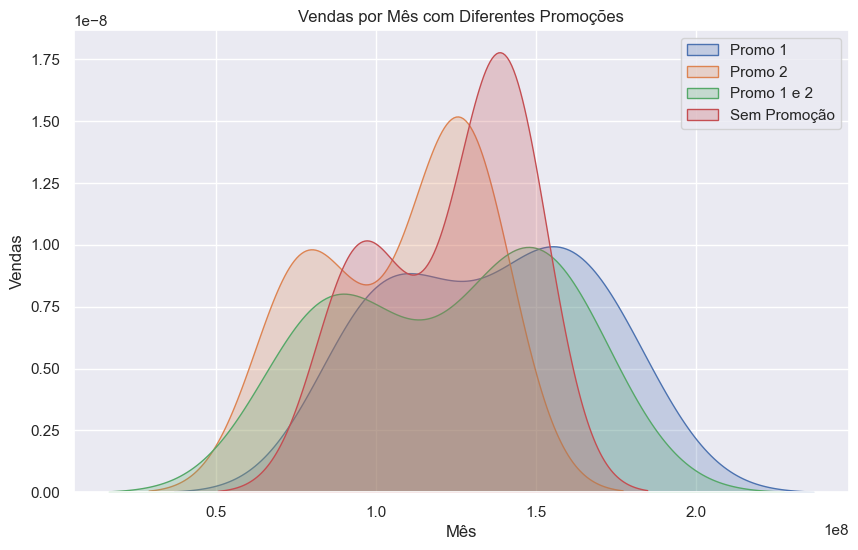

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))
sns.kdeplot(aux_p1['sales'],   label='Promo 1', fill = True)
sns.kdeplot(aux_p2['sales'],   label='Promo 2',  fill = True)
sns.kdeplot(aux_p1_2['sales'], label='Promo 1 e 2', fill = True)
sns.kdeplot(aux_p0['sales'],   label='Sem Promoção', fill = True)

# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
plt.legend()

# Exiba o gráfico
plt.show()


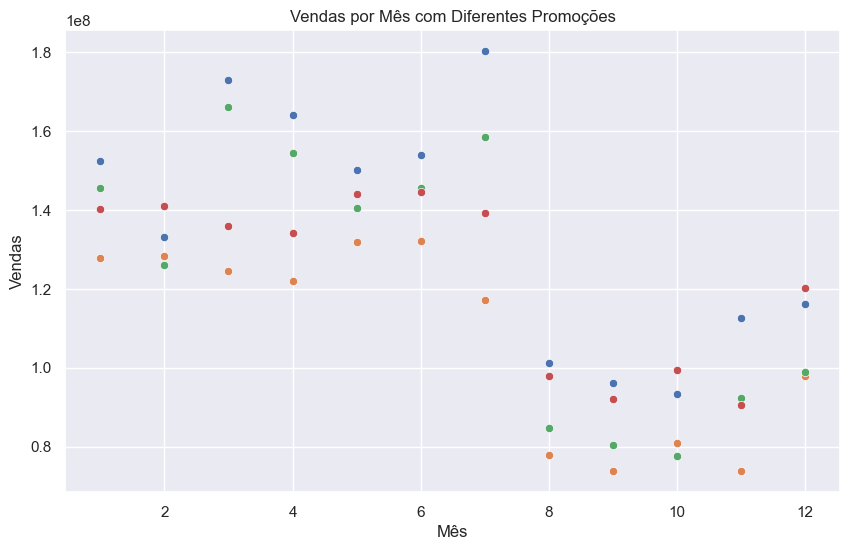

In [77]:


# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']
# Atenção uma forma de colocar tudo em um gráfico só é juntar os dataset groups
# Plote o gráfico de barras
plt.figure(figsize=(10, 6))
sns.scatterplot(x ='month' , y ='sales' , data = aux_p1,    legend='auto')
sns.scatterplot(x ='month' , y ='sales' , data = aux_p2,   legend='auto')
sns.scatterplot(x ='month' , y ='sales' , data = aux_p1_2,   legend='auto')
sns.scatterplot(x ='month' , y ='sales' , data = aux_p0,   legend='auto' )
# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
#plt.legend()

# Exiba o gráfico
plt.show()


In [78]:
aux1 =  dp[['sales', 'is_promo', 'promo2', 'month', 'promo2_since_year']].groupby('month').sum()
aux1

sales  is_promo  promo2  promo2_since_year
month                                                
1      566324181     25816   44021          173657355
2      528734410      9344   41076          161509605
3      599617985      8167   43935          173023906
4      574675472     24500   41700          164242621
5      566491631      9262   40700          160620017
6      576376952      7817   41965          165789683
7      595059205     23849   42001          172255419
8      361597138      6294   26018          109457632
9      342570131         0   25048          105303998
10     351253746     14197   25553          107082933
11     369324570      5943   24587          103425746
12     433139347      4878   24131          101280723

In [79]:
#  
# sales pelo tempo de promoção gráfico 1 (na promo 1), gráfico 2 (na promo 2), gráfico 3 (na promo 1 e 2), gráfico 4 (sem promo) pela mês do ano
dp = dp[dp['promo_time_week'] > 0 ]

aux_p1 = dp[(dp['is_promo']  == 1) & (dp['promo2']  == 0)]

aux_p1 =  aux_p1[['sales', 'promo_time_week', ]].groupby('promo_time_week').sum().reset_index()


#---------------
aux_p2 = dp[(dp['promo2']  == 1) & (dp['is_promo']  == 0)]

aux_p2 =  aux_p2[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
#---------------
aux_p1_2 = dp[(dp['promo2']  == 1) & (dp['is_promo']  == 1)]

aux_p1_2 =  aux_p1_2[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
#---------------
aux_p0 = dp[(dp['promo2']  == 0) & (dp['is_promo']  == 0) ]

aux_p0 =  aux_p0[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()

In [80]:
dp['promo_time_week'].unique()

array([279, 226, 187, 299, 200, 266, 174, 218,  43, 166, 235,  25,  73,
       104, 307, 121, 231, 253, 130, 161, 274, 153, 205, 112, 192,  99,
       222, 134, 140, 257, 313,  65,  82, 213, 125, 148, 170, 287, 305,
        17,  38, 117,  69, 108,   8, 242,  95, 144, 248, 244,  34,  60,
        13, 160,  90, 103, 124,  72, 120, 129, 139, 186, 278, 225, 298,
       199, 265, 173, 217,  42, 165, 234,  24, 306, 230, 252, 273, 152,
       204, 111, 191,  98, 221, 133, 256, 312,  64,  81, 212, 147, 169,
       286, 304,  16,  37, 116,  68, 107,   7, 241,  94, 143, 247, 243,
        33,  59,  12, 159,  89, 102, 123,  71, 119, 128, 138, 185, 277,
       224, 297, 198, 264, 172, 216,  41, 164, 233,  23, 229, 251, 272,
       151, 203, 110, 190,  97, 220, 132, 255, 311,  63,  80, 211, 146,
       168, 285, 303,  15,  36, 115,  67, 106,   6, 240,  93, 142, 246,
        32,  58,  11, 158,  88, 101, 122,  70, 118, 127, 137, 184, 276,
       223, 296, 197, 263, 171, 215,  40, 163, 232,  22, 228, 25

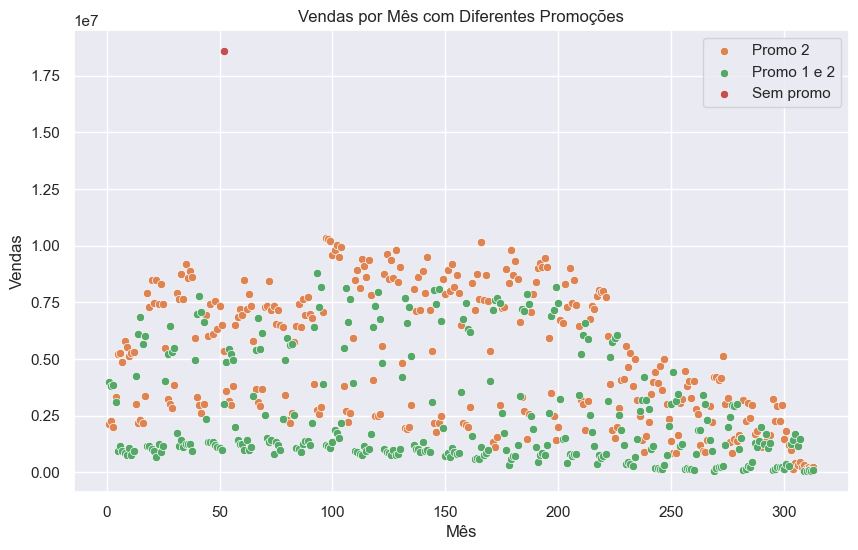

In [81]:


# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))


sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p1, label='Promo 1 ')
sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p2 ,label='Promo 2')
sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p1_2 ,label='Promo 1 e 2')
sns.scatterplot(x ='promo_time_week' , y ='sales' , data = aux_p0 ,label='Sem promo')

# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
plt.legend()

# Exiba o gráfico
plt.show()


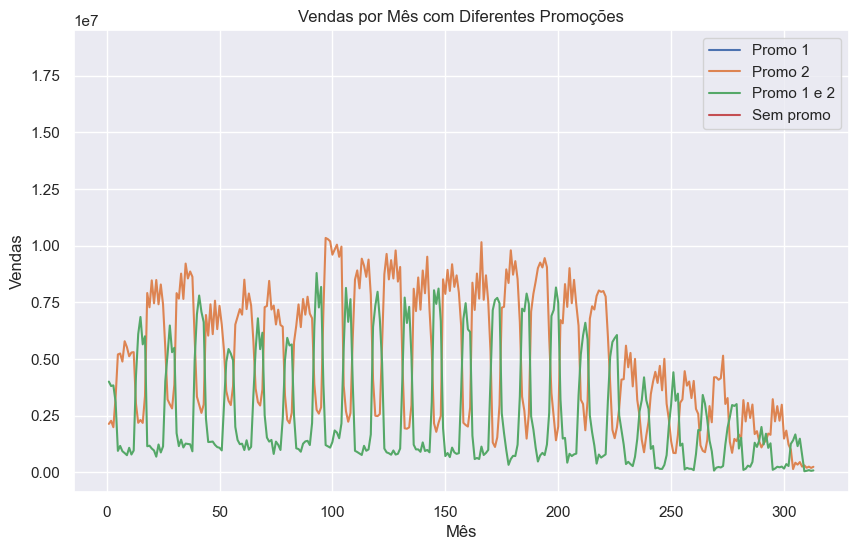

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crie um DataFrame com os dados aux_p1, aux_p2, aux_p1_2 e aux_p0
#combined_data = pd.concat([aux_p1, aux_p2, aux_p1_2, aux_p0], axis=1)
#combined_data.columns = ['Promo 1', 'Promo 2', 'Promo 1 e 2', 'Sem Promoção']

# Plote o gráfico de barras
plt.figure(figsize=(10, 6))


sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p1, label='Promo 1 ')
sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p2 ,label='Promo 2')
sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p1_2 ,label='Promo 1 e 2')
sns.lineplot(x ='promo_time_week' , y ='sales' , data = aux_p0 ,label='Sem promo')

# Personalize o gráfico
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Mês com Diferentes Promoções')
plt.legend()

# Exiba o gráfico
plt.show()


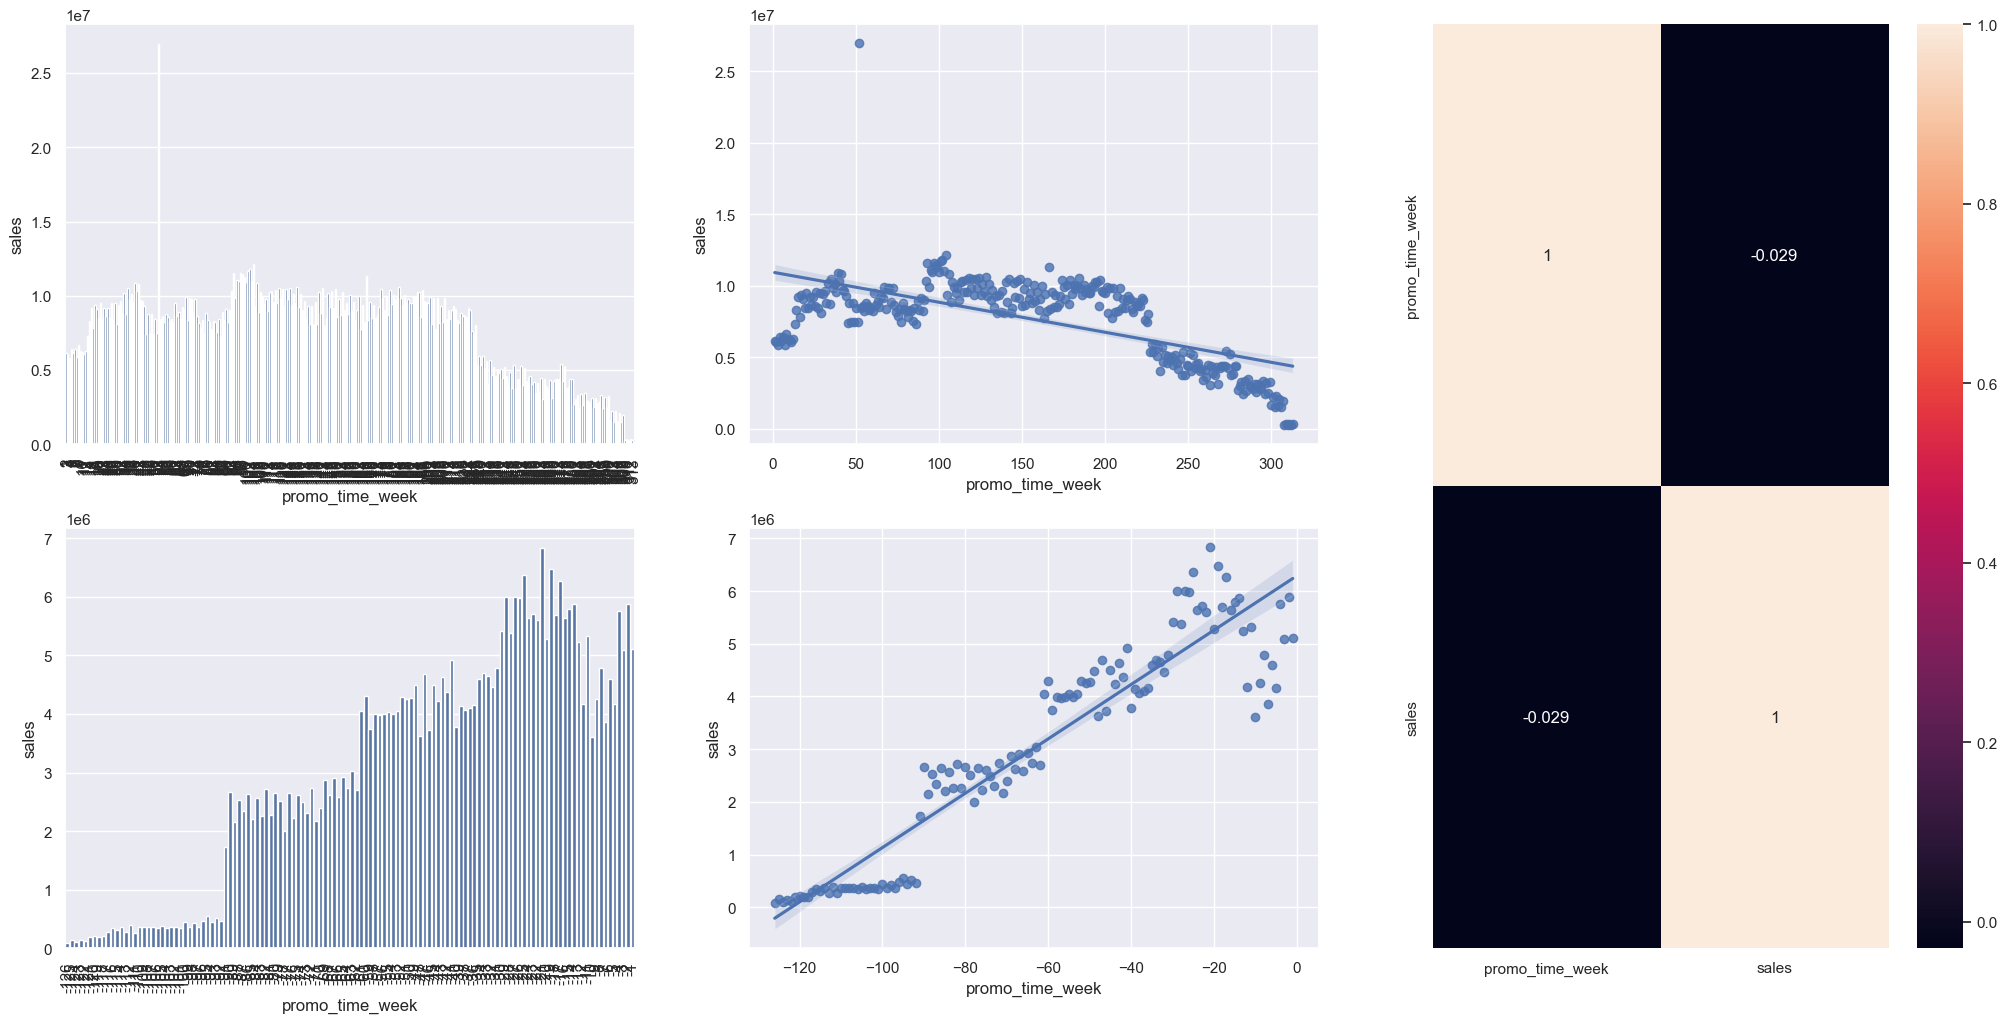

In [83]:
#Professor fez

#Agrupa as informações
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
# Mostra um gráfico de regressão com scaterr, uma tendência dos ponto
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )
sns.regplot( x ='promo_time_week', y ='sales', data=aux2 );



plt.subplot( grid[1,0] )

aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

~5.2.5 H5. Lojas com mais dias de promoção deveriam vender mais.~
## 5.2.6 H7. Lojas com mais promoções consecutivas deveriam vender mais.
FALSA Lojas com mais promocoes consecutivas vendem menos

In [84]:
#Segundo a HIPÓTESE a ser analisada existem dois tipos de LoJAS que promoções consecutivas e não promoções consecutivas, vamos dividir em:
# Quais colunas vamos usar ?
#df4.head()
aux= df4[df4['state_holiday'] == 'regular_day']
#retirar as lojas que não entraram na promo 1
aux_p= df4[df4['promo'] != 0]
# Vamos retirar também os dados de 2015 pois não estão completos,embora é seja perca de dados, vai nos dar velocidade!
aux_p = df4[df4['year'] != 2015]
# agora temos somente lojas que entraram na promo 1 e talvez entraram na promo2
# As colunas analisada são : 
# sales, promo2 promo2_since_week
# 
aux_p1 = aux_p[['sales', 'promo2', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()
aux_p.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  Duration_of_competition_in_years
236380      1            3 2014-12-31   2605      0   regular_day               1          c      basic                1270.0                             9                         2008       0                  1               2014         0  2014     12   31             1   2014-52        2008-09-01                      77  2013-12-30               52                                 6
236381      2            3 2014-12-31   2269      0   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010         0  2014     12   31             1   2014-52        2007-11-01                      87  2010-03-22              249                                 7
236382      3            3 2014-12-31   3804      0   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011         0  2014     12   31             1   2014-52        2006-12-01                      98  2011-03-28              196                                 8
236383      4            3 2014-12-31  10152      0   regular_day               1          c   extended                 620.0                             9                         2009       0                  1               2014         0  2014     12   31             1   2014-52        2009-09-01                      64  2013-12-30               52                                 5
236384      5            3 2014-12-31   1830      0   regular_day               1          a      basic               29910.0                             4                         2015       0                  1               2014         0  2014     12   31             1   2014-52        2015-04-01                      -4  2013-12-30               52                                -1

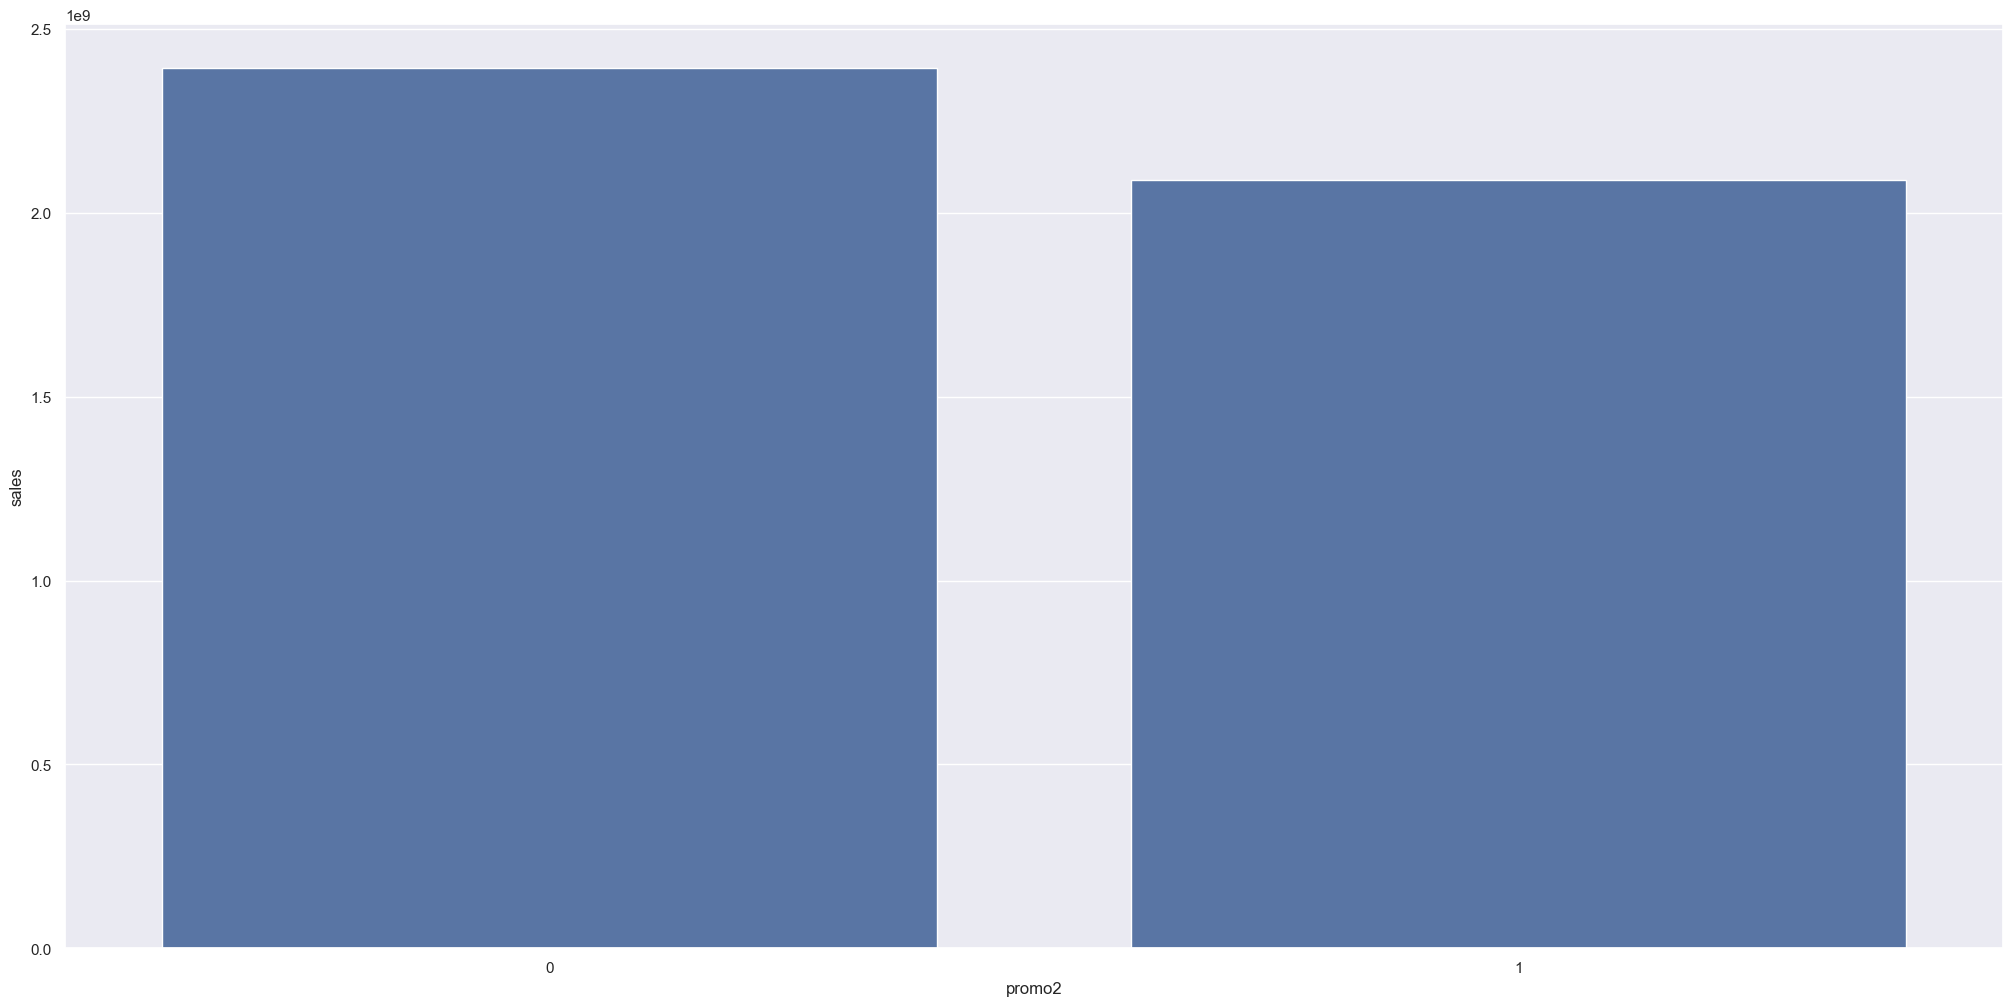

In [85]:
aux2 = aux_p[['sales', 'promo2' ]].groupby('promo2').sum().reset_index()
aux2.head()
sns.barplot( x='promo2', y='sales', data=aux2, legend = 'full' );
#de forma geral venderam mais quem não extendeu para promo 2, vamos agora observar a tentendência!

In [86]:
aux3 = aux_p[['sales', 'promo2', 'promo_time_week']].groupby(['promo2','promo_time_week']).sum().reset_index()
# vamos analisar o range da promo_time_week 
#aux3['promo_time_week'].unique() #primeiro momento existem valores negativos, vamos filtra-los
aux3 =  aux3[aux3['promo_time_week']>0]
aux3 = aux3[aux3['sales'] < 18000000] #Removendo outlier
#aux3['promo_time_week'].unique() # ele vai de 1 a 283
#vamos dividir em duas partes, gerando três gráficos
aux31 = aux3[aux3['promo_time_week'] < 94 ] 
aux32 = aux3[(aux3['promo_time_week']  >= 94) & (aux3['promo_time_week']  < 188) ]
aux33 = aux3[aux3['promo_time_week']  >= 188 ]
#aux3


In [87]:
# como os outilier estão atrapalhando a escala do gráfico vou remover esses que são muito fora da curva.
aux3['sales'].agg(['max', 'min', 'mean', 'median', 'std'] )


max       9.475911e+06
min       7.992000e+04
mean      6.039946e+06
median    6.619916e+06
std       2.049076e+06
Name: sales, dtype: float64

<Axes: xlabel='promo_time_week'>

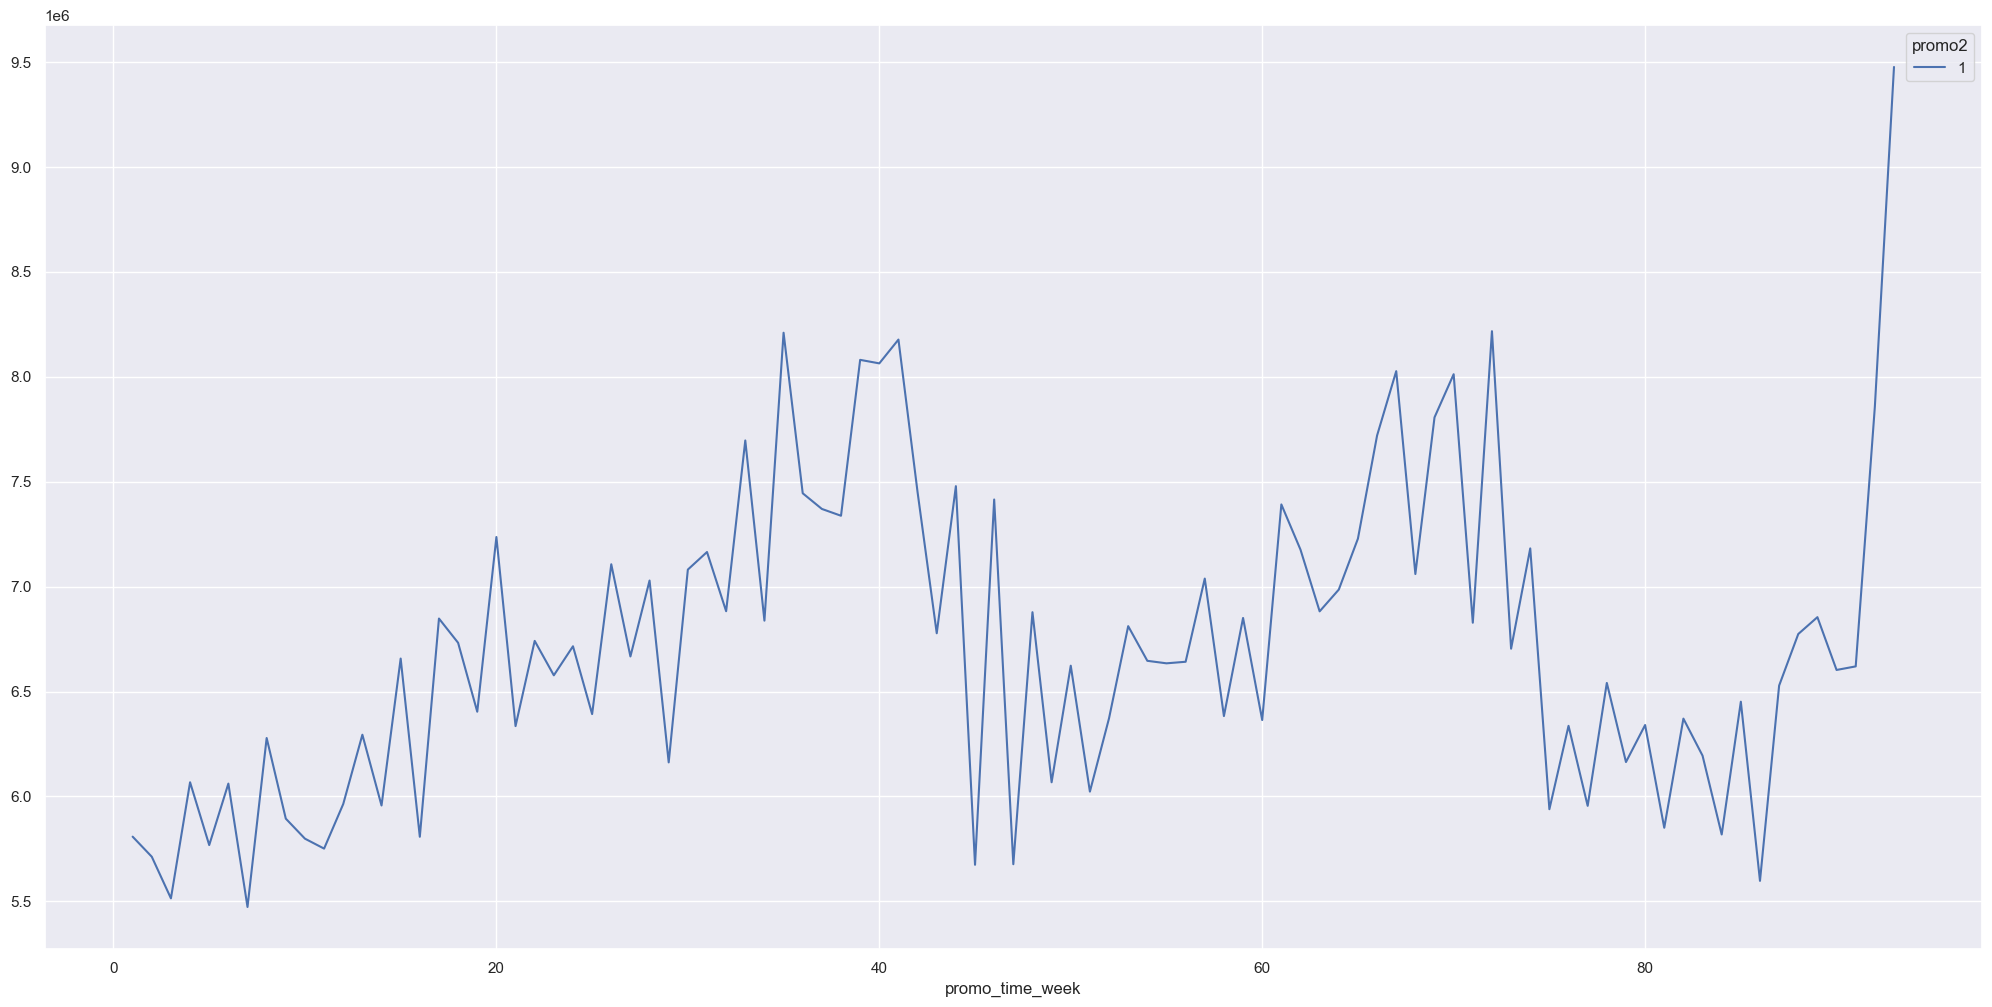

In [88]:
#subplot(linha, coluna, posição)
#aux3.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

#plt.subplot(3, 1 , 1)
aux31.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

#sns.regplot(x = 'promo_time_week', y = 'sales', data = aux31) # Nota se um outilier que atrapalha a visualização, está em prim_time_week  0







<Axes: xlabel='promo_time_week'>

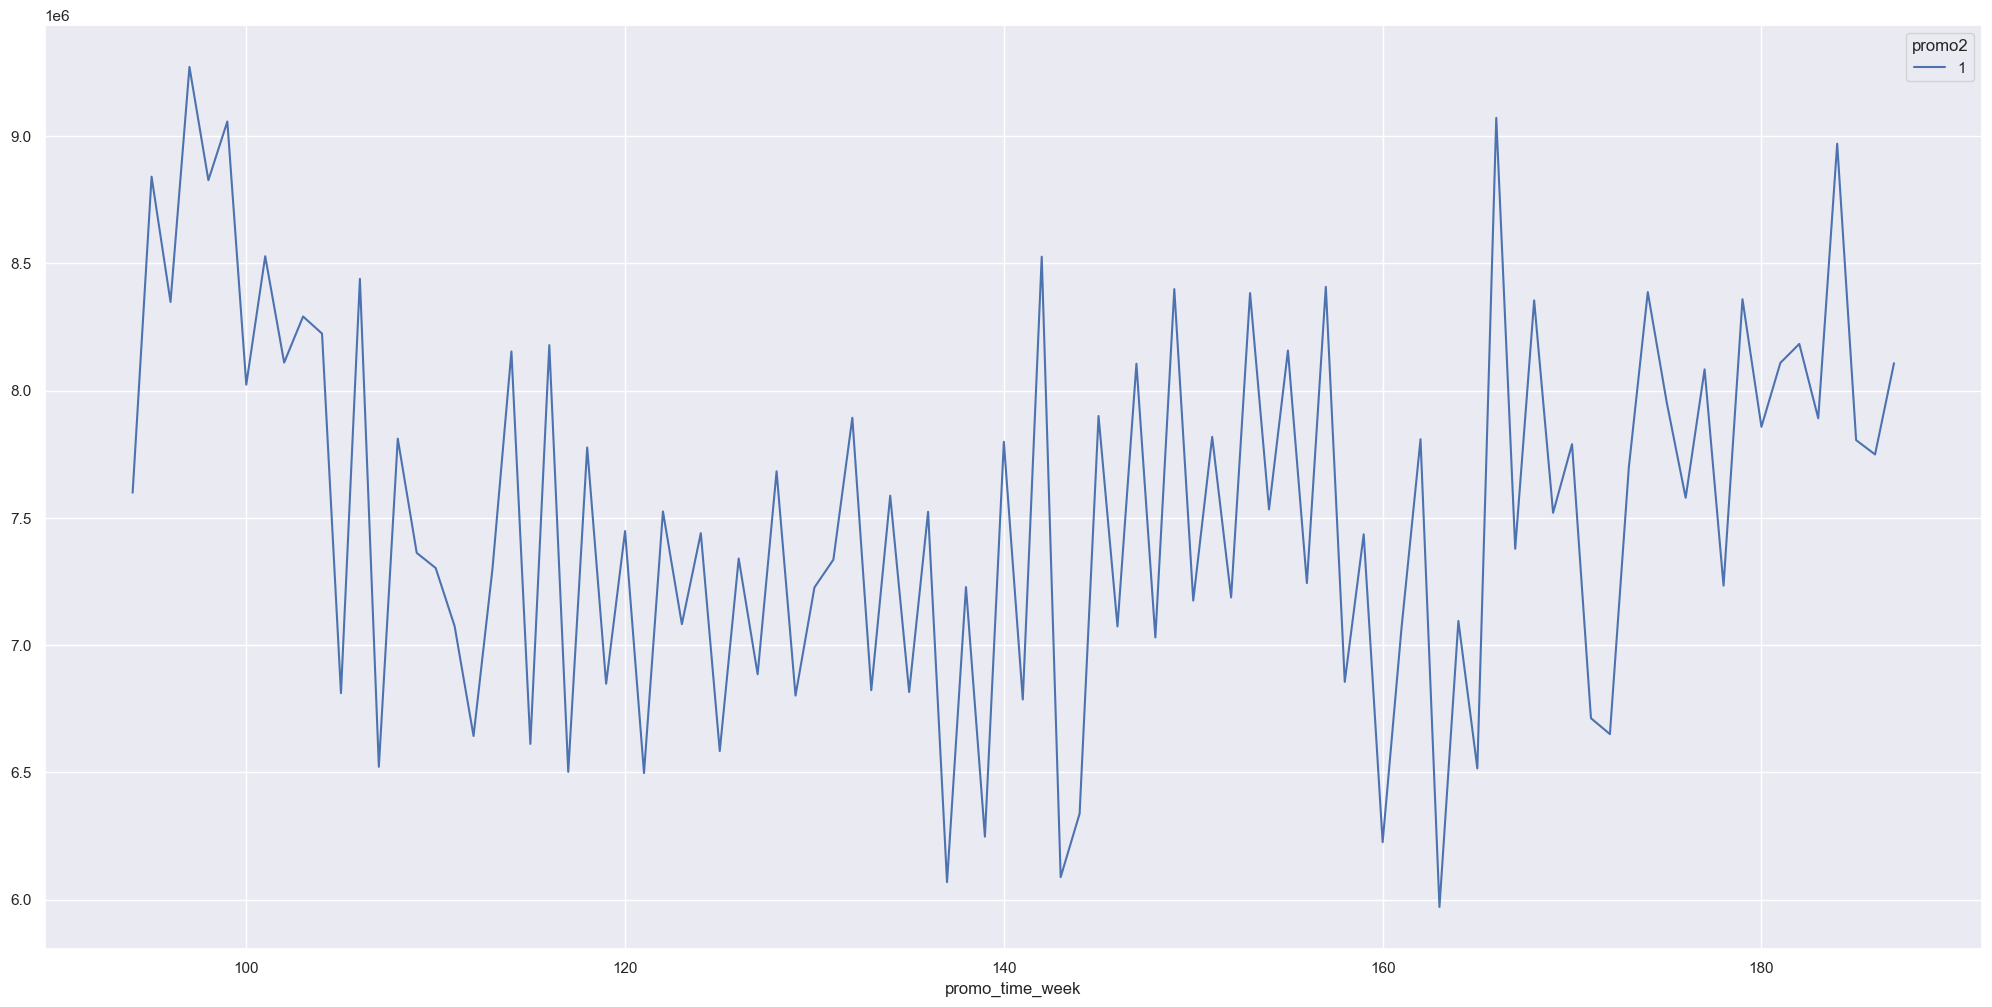

In [89]:
#plt.subplot(3, 1, 2)
aux32.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

<Axes: xlabel='promo_time_week'>

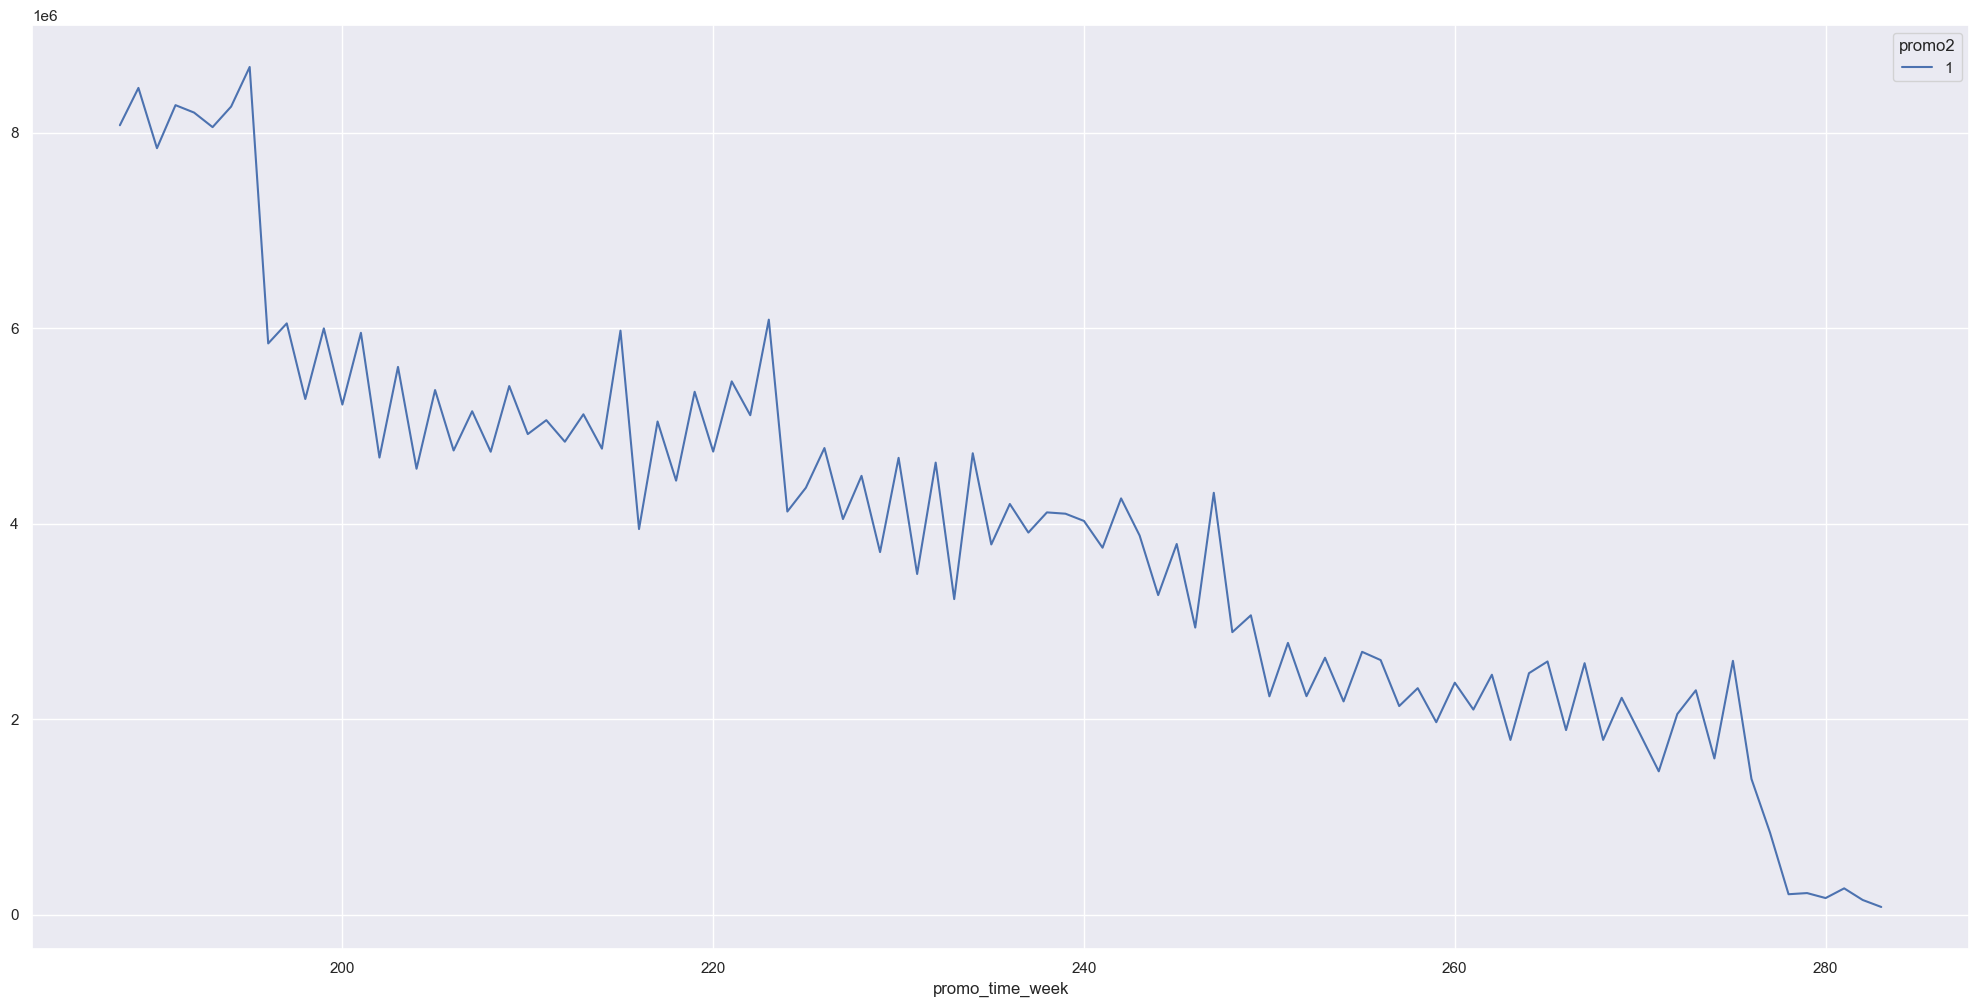

In [90]:
#plt.subplot(3, 1, 3)
aux33.pivot(index = 'promo_time_week', columns = 'promo2', values = 'sales').plot()

In [91]:
#Professor fez 

df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

In [92]:
#Professor fez 
# Selecionou agrupando três colunas: ['promo', 'promo2', 'sales']
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


promo  promo2       sales
0      0       0  1482612096
1      0       1  1289362241
2      1       0  1628930532
3      1       1  1472275754

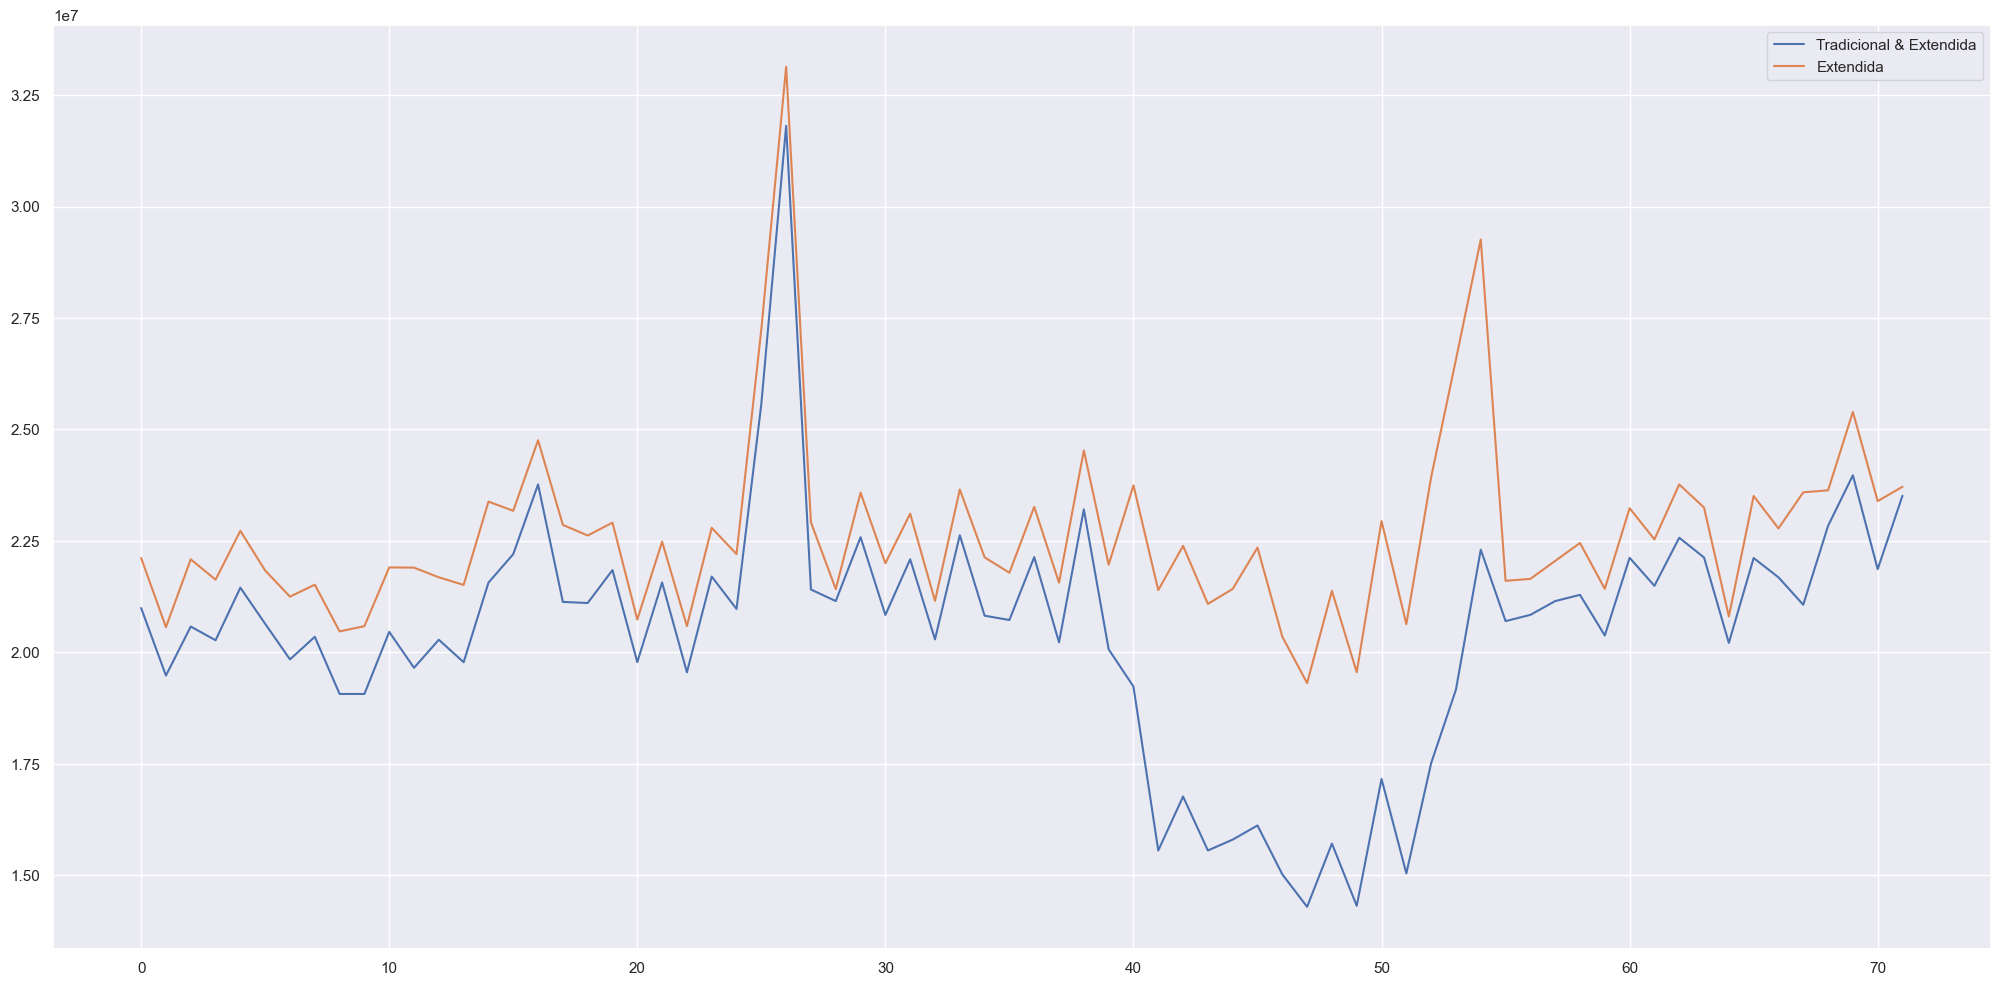

In [93]:
#realizou um filtro para promo e promo2 ativato e selecionandos as colunas ['year_week', 'sales'] e indexando year_week.
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

#realizou um filtro para promo ativato e promo2 n ativato e selecionandos as colunas ['year_week', 'sales'] e indexando year_week.
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()

aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

## 5.2.7 H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA Lojas abertas durante o feriado do Natal vendem menos.

In [94]:
df4.head(3)

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  Duration_of_competition_in_years
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0                                 7
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279                                 8
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226                                 9

Quais colunas estamos trabalhando ? 
 * sales
 * state_holiday -> options: 'regular_day', 'public_holiday', 'easter_holiday', 'christmas' 
 * 
Quais feriados vendem mais ? 
Um Feriado de natal vende mais que um dia normal ?

In [95]:
aux_c = df4[df4['state_holiday'] == 'christmas']#agg({'sales' : ['max']})
aux_c = aux_c.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_c

state_holiday       date  sales
3     christmas 2014-12-26  32169
1     christmas 2013-12-26  28800
2     christmas 2014-12-25  26756
0     christmas 2013-12-25  24245

In [96]:

aux_r = df4[df4['state_holiday'] == 'regular_day']
aux_r = aux_r.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_r.head(4) 

state_holiday       date  sales
878   regular_day 2015-06-22  41551
516   regular_day 2014-06-16  38037
342   regular_day 2013-12-16  38025
348   regular_day 2013-12-22  37376

In [97]:
aux_p = df4[df4['state_holiday'] == 'public_holiday']
aux_p = aux_p.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_p.head(4)

state_holiday       date  sales
21  public_holiday 2015-05-01  38484
22  public_holiday 2015-05-14  38367
13  public_holiday 2014-05-29  37403
16  public_holiday 2014-10-03  35702

In [98]:
aux_e = df4[df4['state_holiday'] == 'easter_holiday']
aux_e = aux_e.loc[:,['state_holiday','sales', 'date']].groupby(['state_holiday','date']).max().reset_index().sort_values(['sales'], ascending=False)
aux_e = aux_e.iloc[0:4, :].reset_index()

In [99]:
aux_e 

index   state_holiday       date  sales
0      4  easter_holiday 2015-04-03  38722
1      0  easter_holiday 2013-03-29  36227
2      2  easter_holiday 2014-04-18  35909
3      5  easter_holiday 2015-04-06  33655

In [100]:
 
#aux_e[0,'index'] = 1
#aux_e[1,'index'] = 2
#aux_e[2,'index'] = 3
#aux_e[3,'index'] = 4

#aux_e = aux_e.rename(columns={'index': 'podio')

#df3 = df3.drop( ['date'], axis=1 )


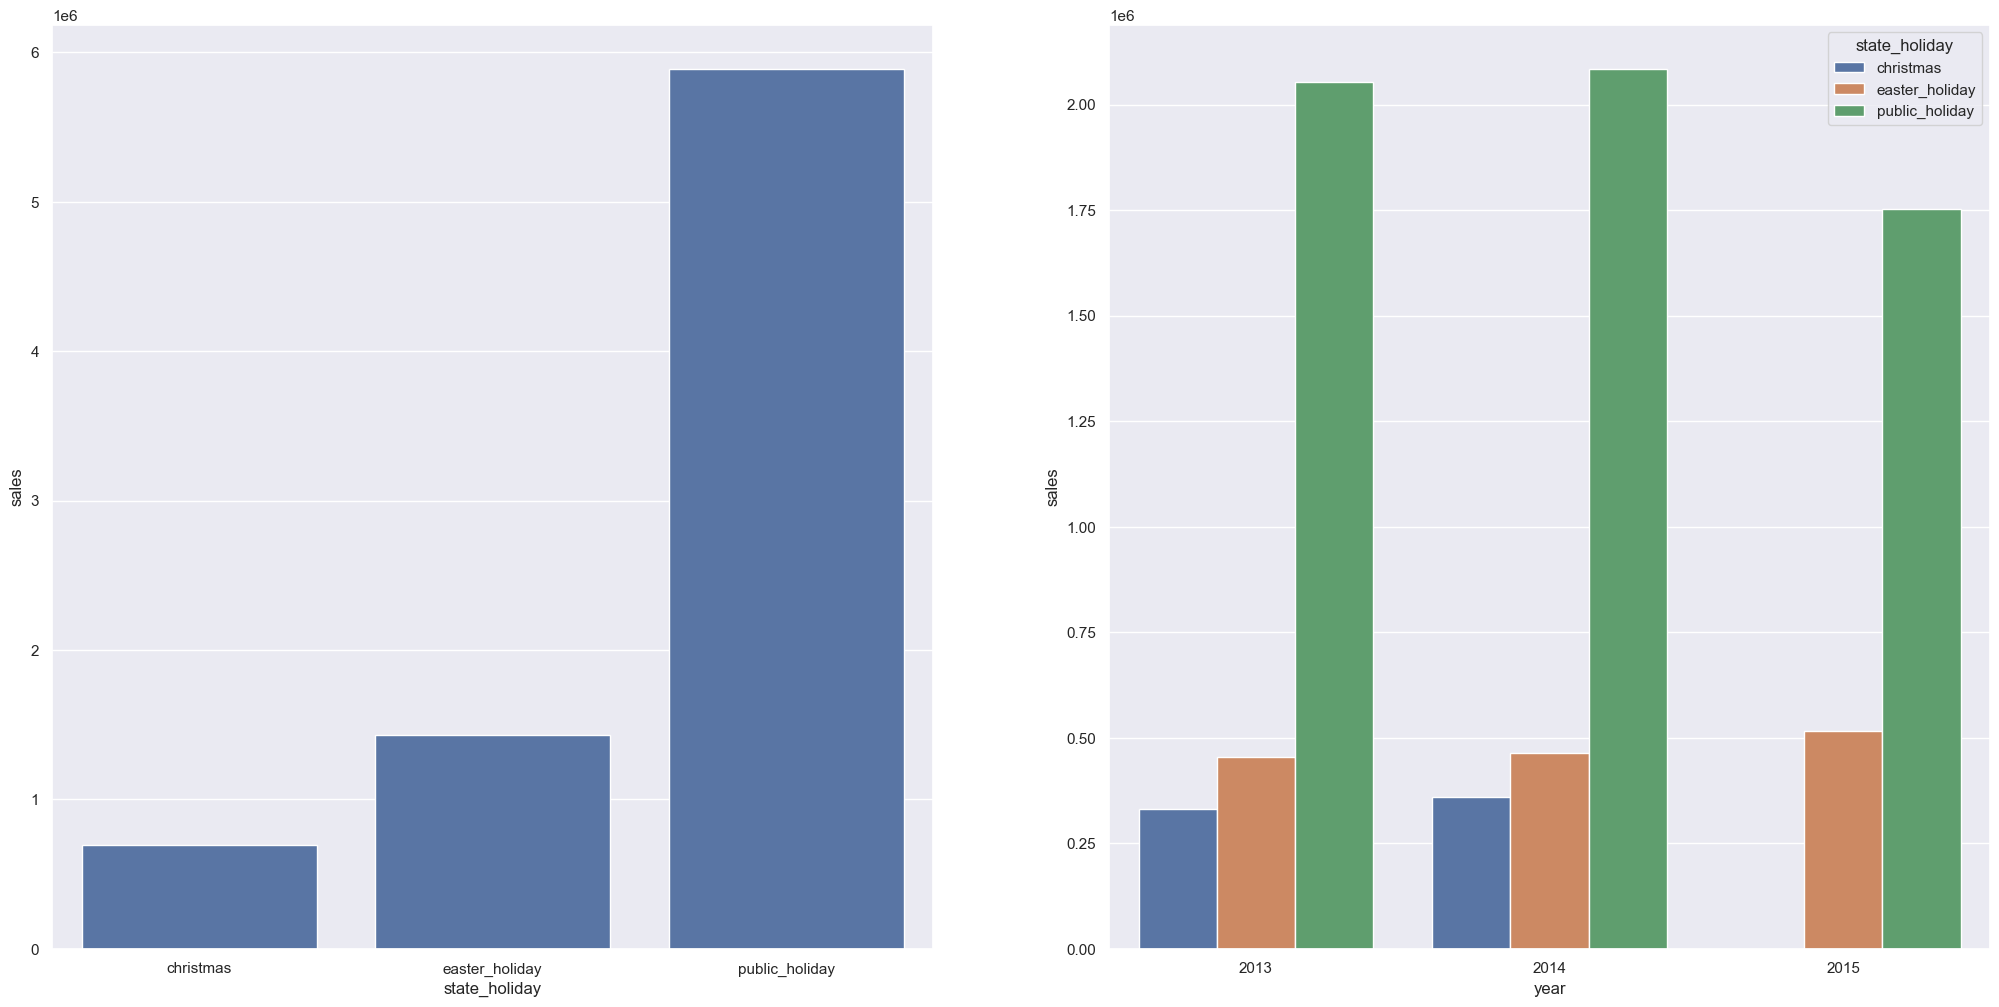

In [101]:
#forma que Professor fez! 
#faz um filtro e plota
aux = df4[df4['state_holiday'] != 'regular_day']
# agrupa e soma as vendas em dias n comum 
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

## 5.2.8 H9. Lojas deveriam vender mais ao longo dos anos.
Próximo de falsa - pois no ano de 2015  falta dados da metade do ano, que vinha de forma promissora para ser o melhor ano de vendas. Além disso, o que ocorreu em 2014, uma grande queda pós o mês 6, pode ser um acontecimento promovido por algo específico da aquele ele, que existe baixa possibilidade de repetir, já o ano de 2014 estava com números de vendas um pouco melhor que 2013 nos primeiros 6 mêses, exceto fevereiro de 2013.

In [102]:
df4.head()

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  Duration_of_competition_in_years
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0                                 7
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279                                 8
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226                                 9
3      4            5 2015-07-31  13995      1   regular_day               1          c   extended                 620.0                             9                         2009       0                 31               2015         0  2015      7   31            31   2015-30        2009-09-01                      71  2015-07-27                0                                 6
4      5            5 2015-07-31   4822      1   regular_day               1          a      basic               29910.0                             4                         2015       0                 31               2015         0  2015      7   31            31   2015-30        2015-04-01                       4  2015-07-27                0                                 0

Vamos pegar as colunas 
 * sales
 * year
 * month
    Então vamos ferar dois ✌ tipos de gráficos, um gráfico acumulativo de vendas anual, outro um pivot por mesês, sendo três anos serão três linhas

<Axes: xlabel='month'>

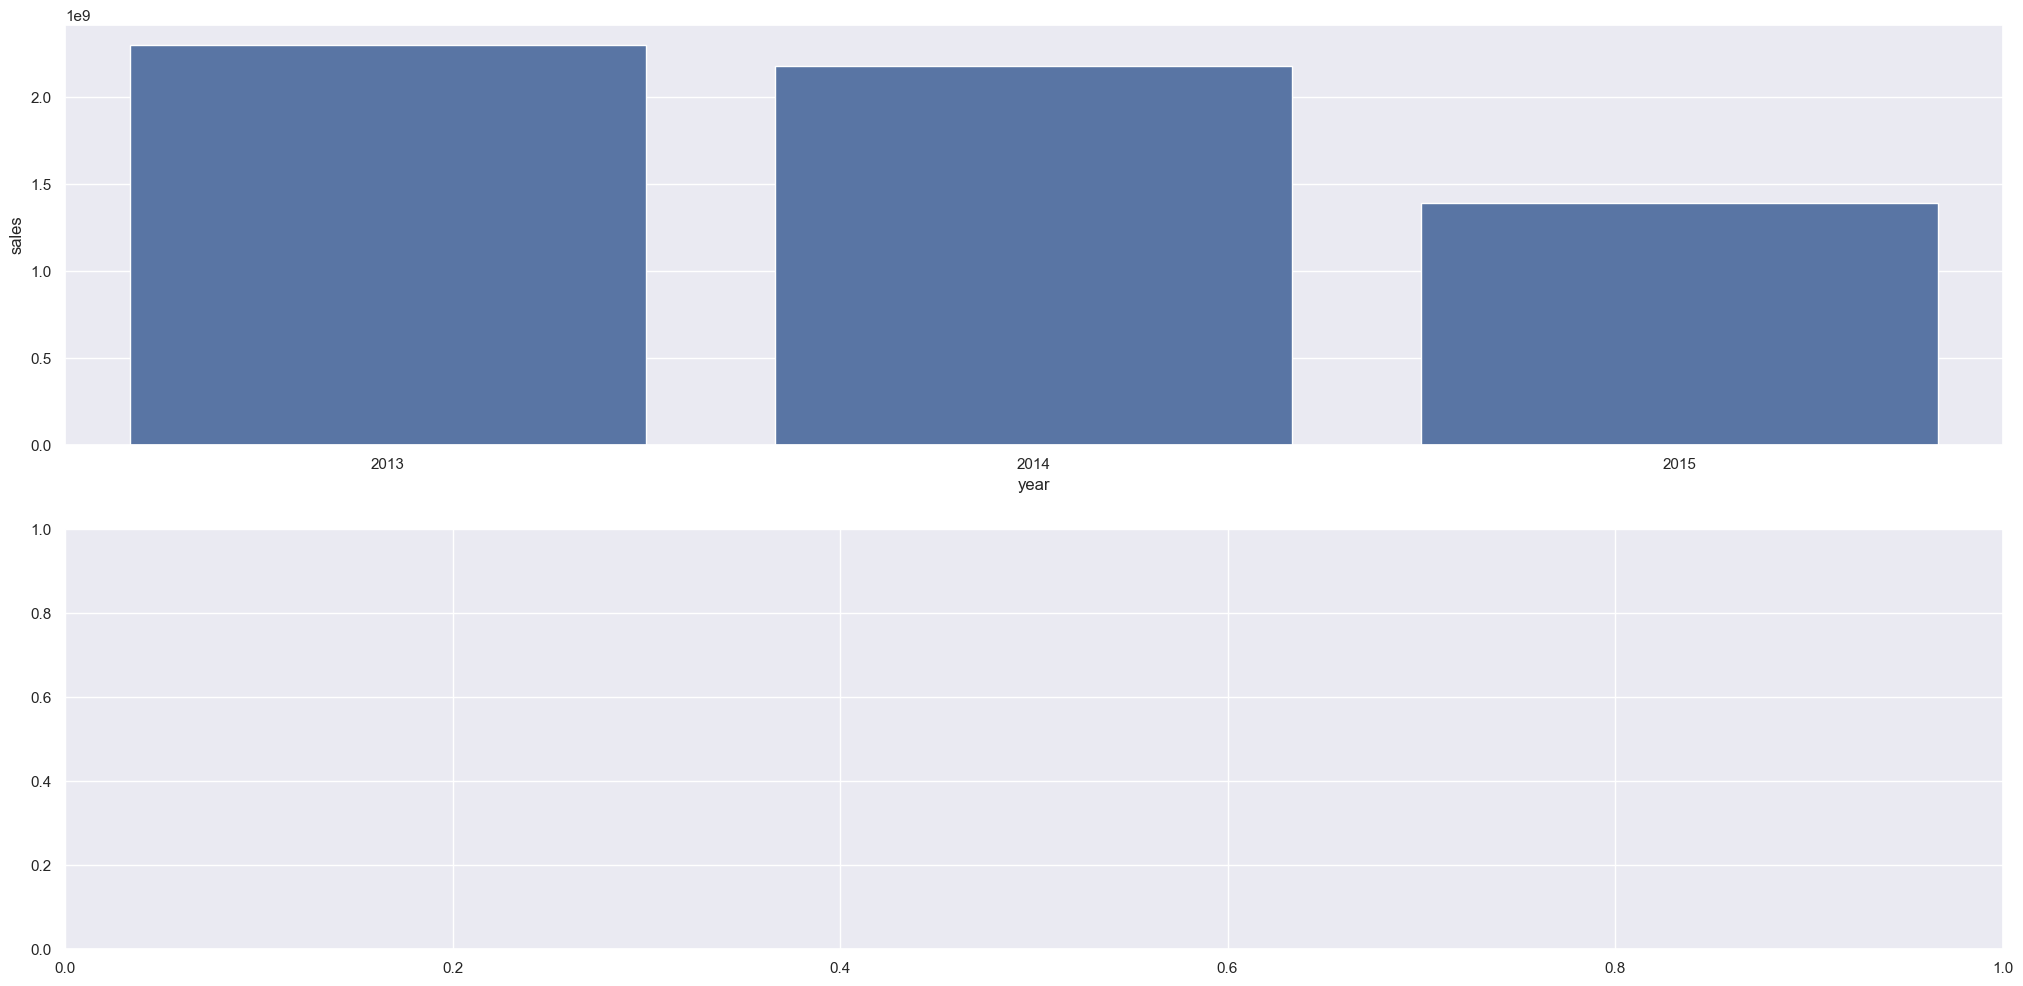

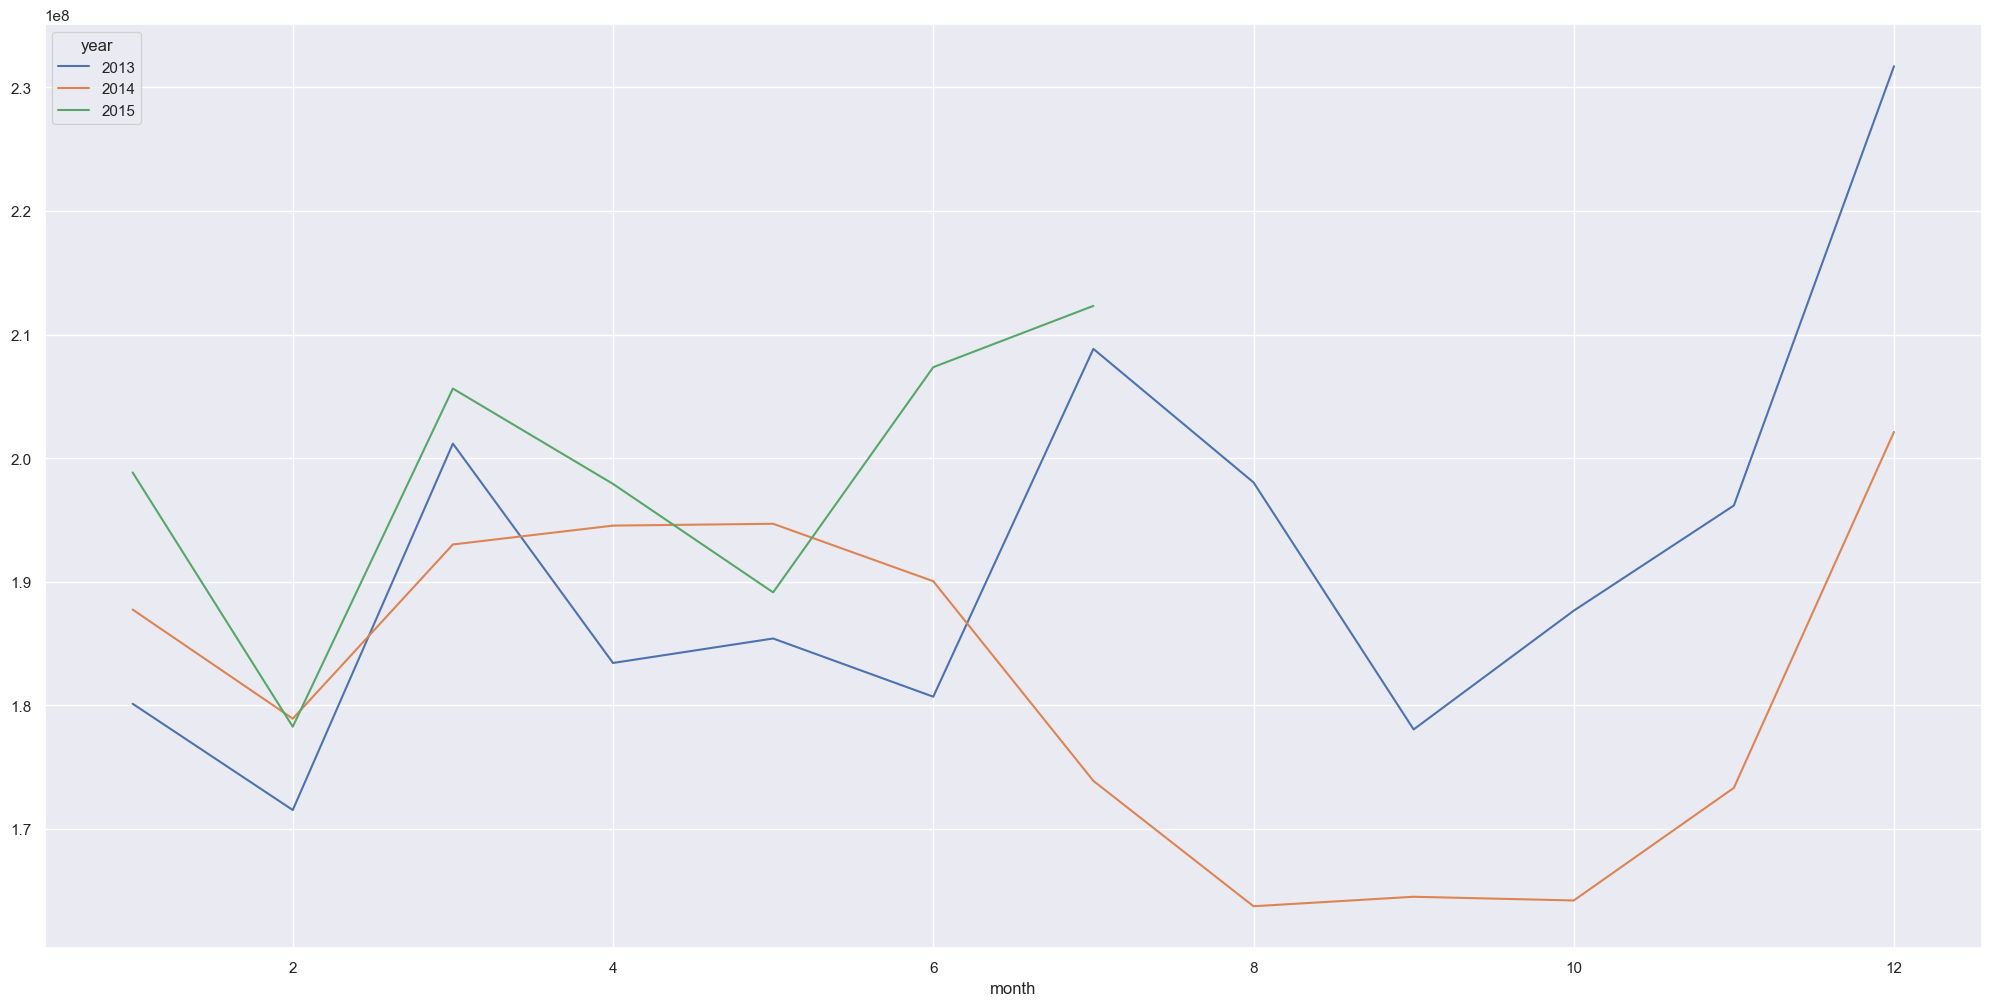

In [103]:
# Acumulativo
aux = df4[['sales','year']].groupby('year').sum().reset_index()

plt.subplot(2,1, 1 )
sns.barplot(x = 'year' ,y = 'sales', data = aux)
# Tendência anual
plt.subplot(2, 1, 2)
aux1 = df4[['sales','year', 'month']].groupby(['year', 'month']).sum().reset_index()
#aux1
aux1.pivot(index = 'month' , columns = 'year', values = 'sales').plot()


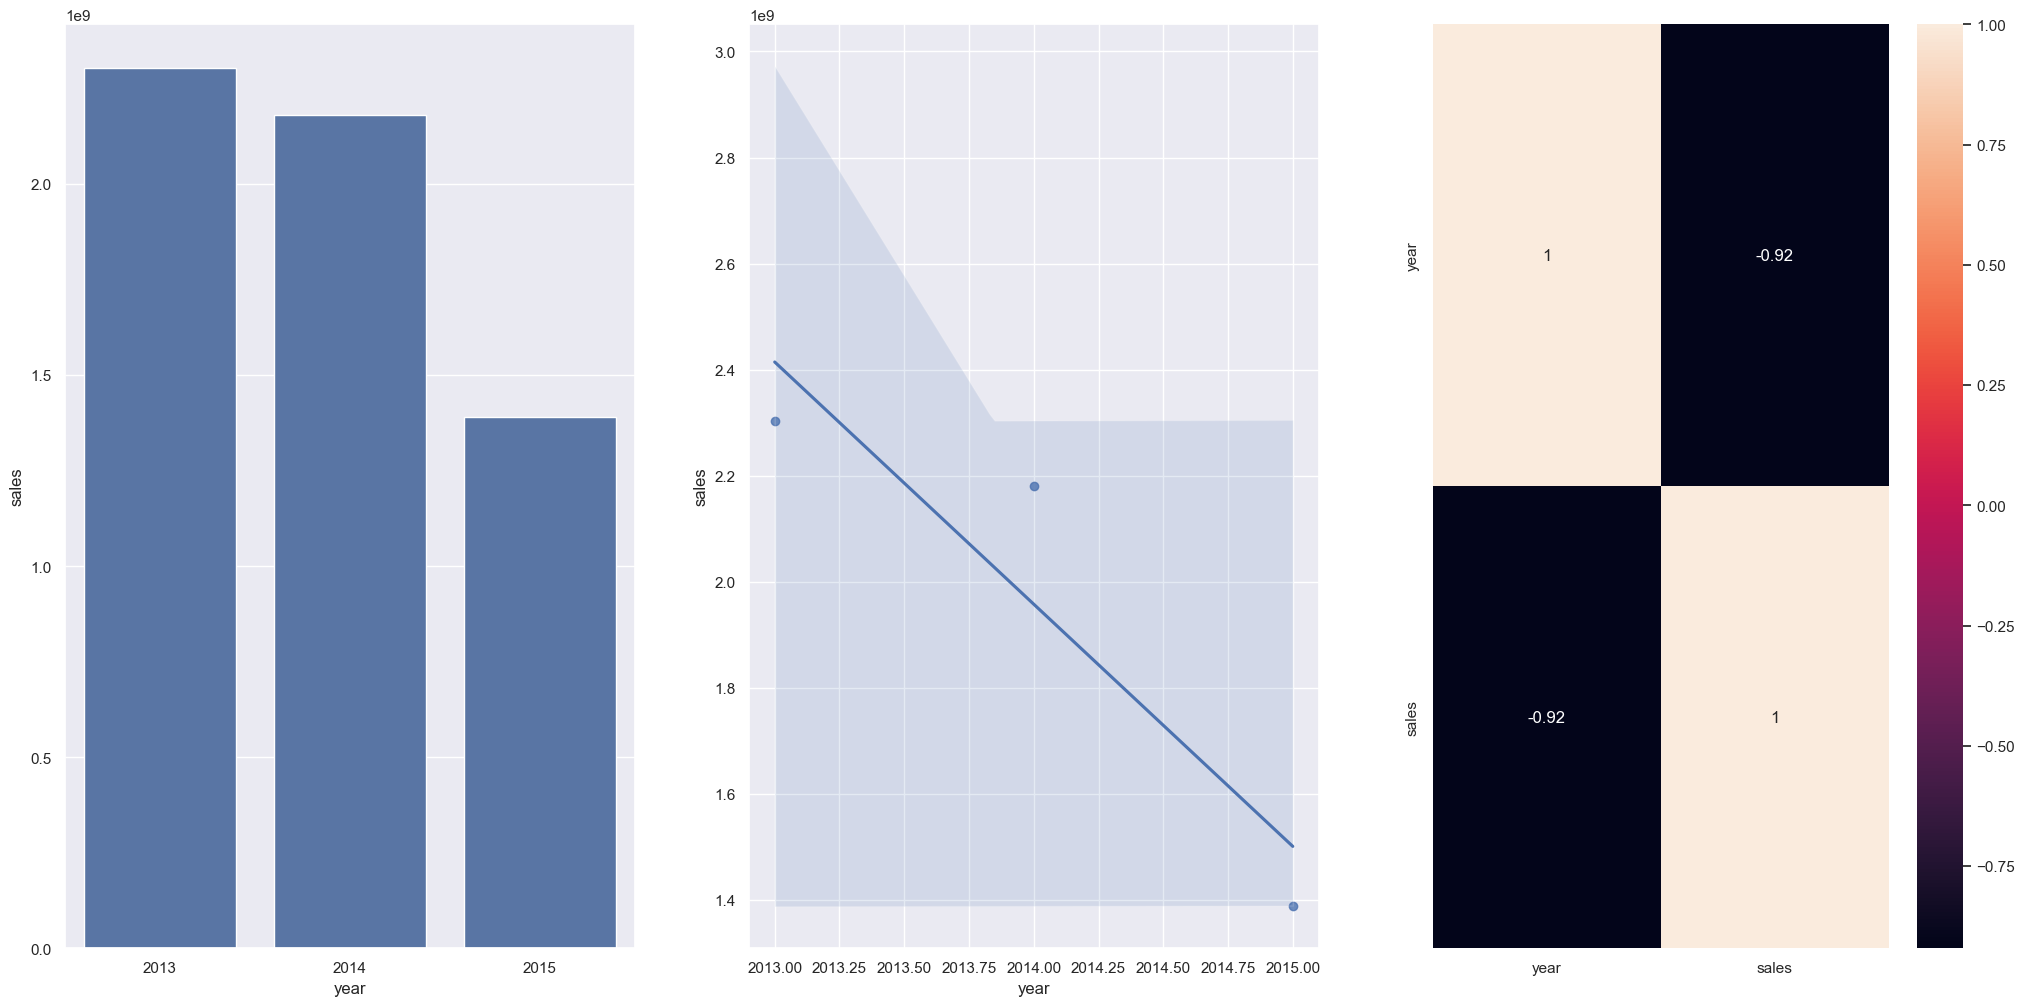

In [104]:
## Como o professor fez !
# como eu selecionou sales e year, mas não month
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
# Criou gráfico de vendas acumulativo por ano
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )

# criou um regressão para analisar comportamento por anos
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
# Fez uma correlação das variáveis sales e year, o que para mim, não valia a pena para prever ou confiar acontecimentos futuros.
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## 5.2.9 H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

<Axes: xlabel='month'>

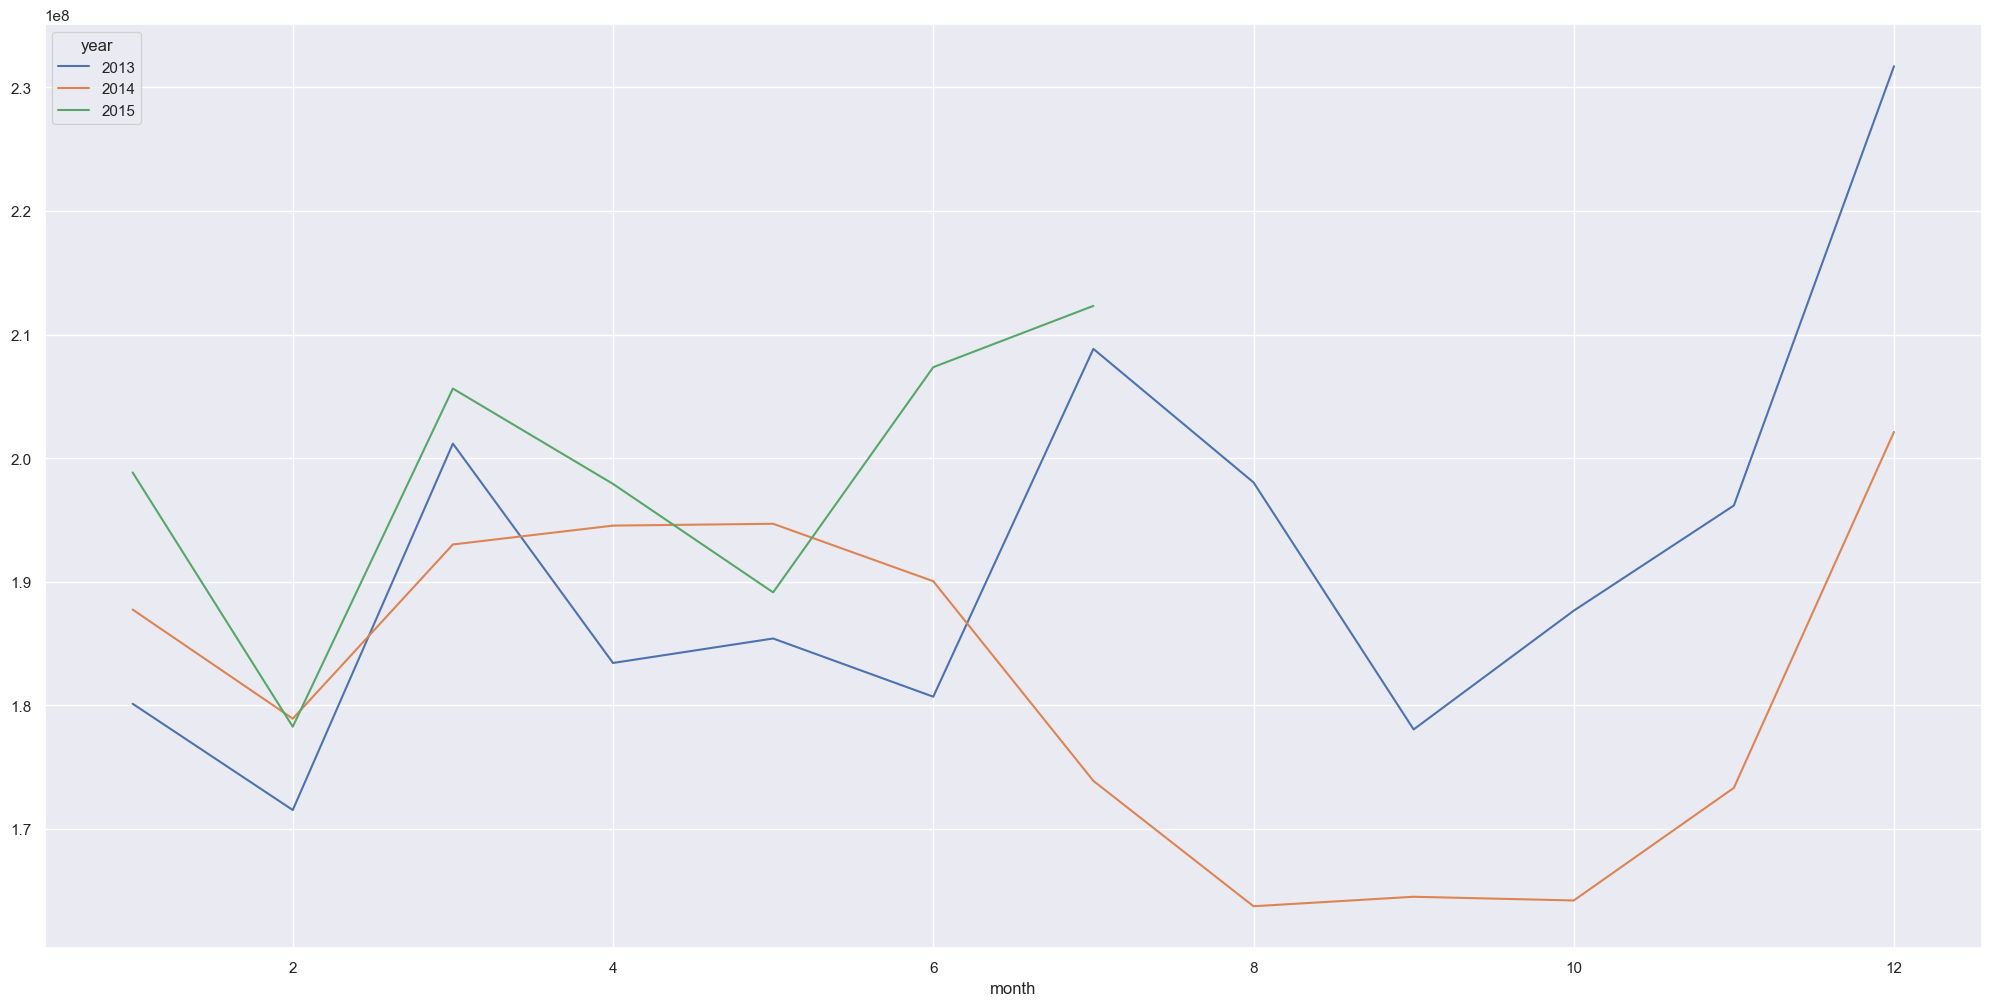

In [105]:
#o gráfico da pergunta anterior para analisar o comportamento das vendas em relação aos anos, deixa claro que as vendas diminuir 
#após o mês 6, significativamente, tendo uma retomada no mês de Novembro a Dezembro.
# Acumulativo
aux = df4[['sales','year']].groupby('year').sum().reset_index()

aux1 = df4[['sales','year', 'month']].groupby(['year', 'month']).sum().reset_index()
#aux1
aux1.pivot(index = 'month' , columns = 'year', values = 'sales').plot()

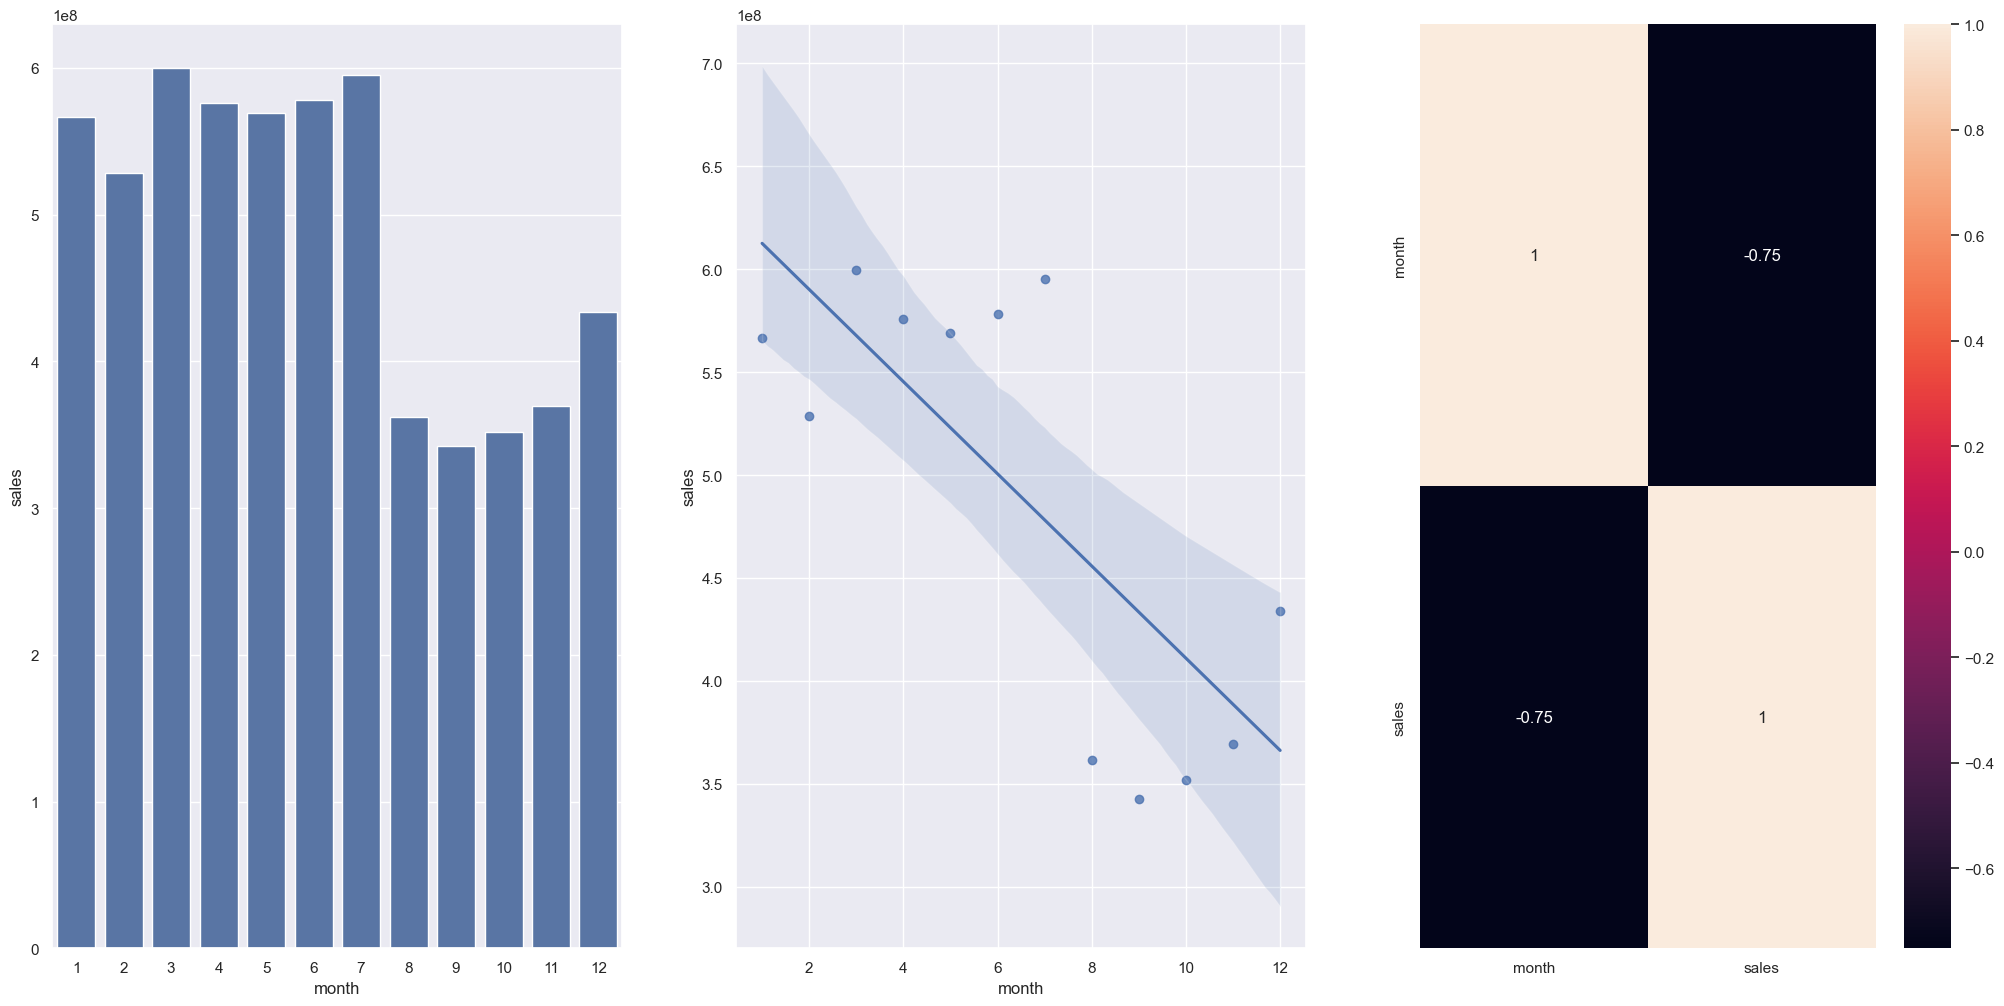

In [106]:
# como o professor fez! 
# Agrupou por vendas por mês
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
# fez uma correlação com método de peason entre vendas e meses!
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## 5.2.10 H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes.


As colunas analisada são:
 * sales
 * year
 * month
 * day

In [107]:
df4['day'].unique()

array([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

<Axes: xlabel='day', ylabel='sales'>

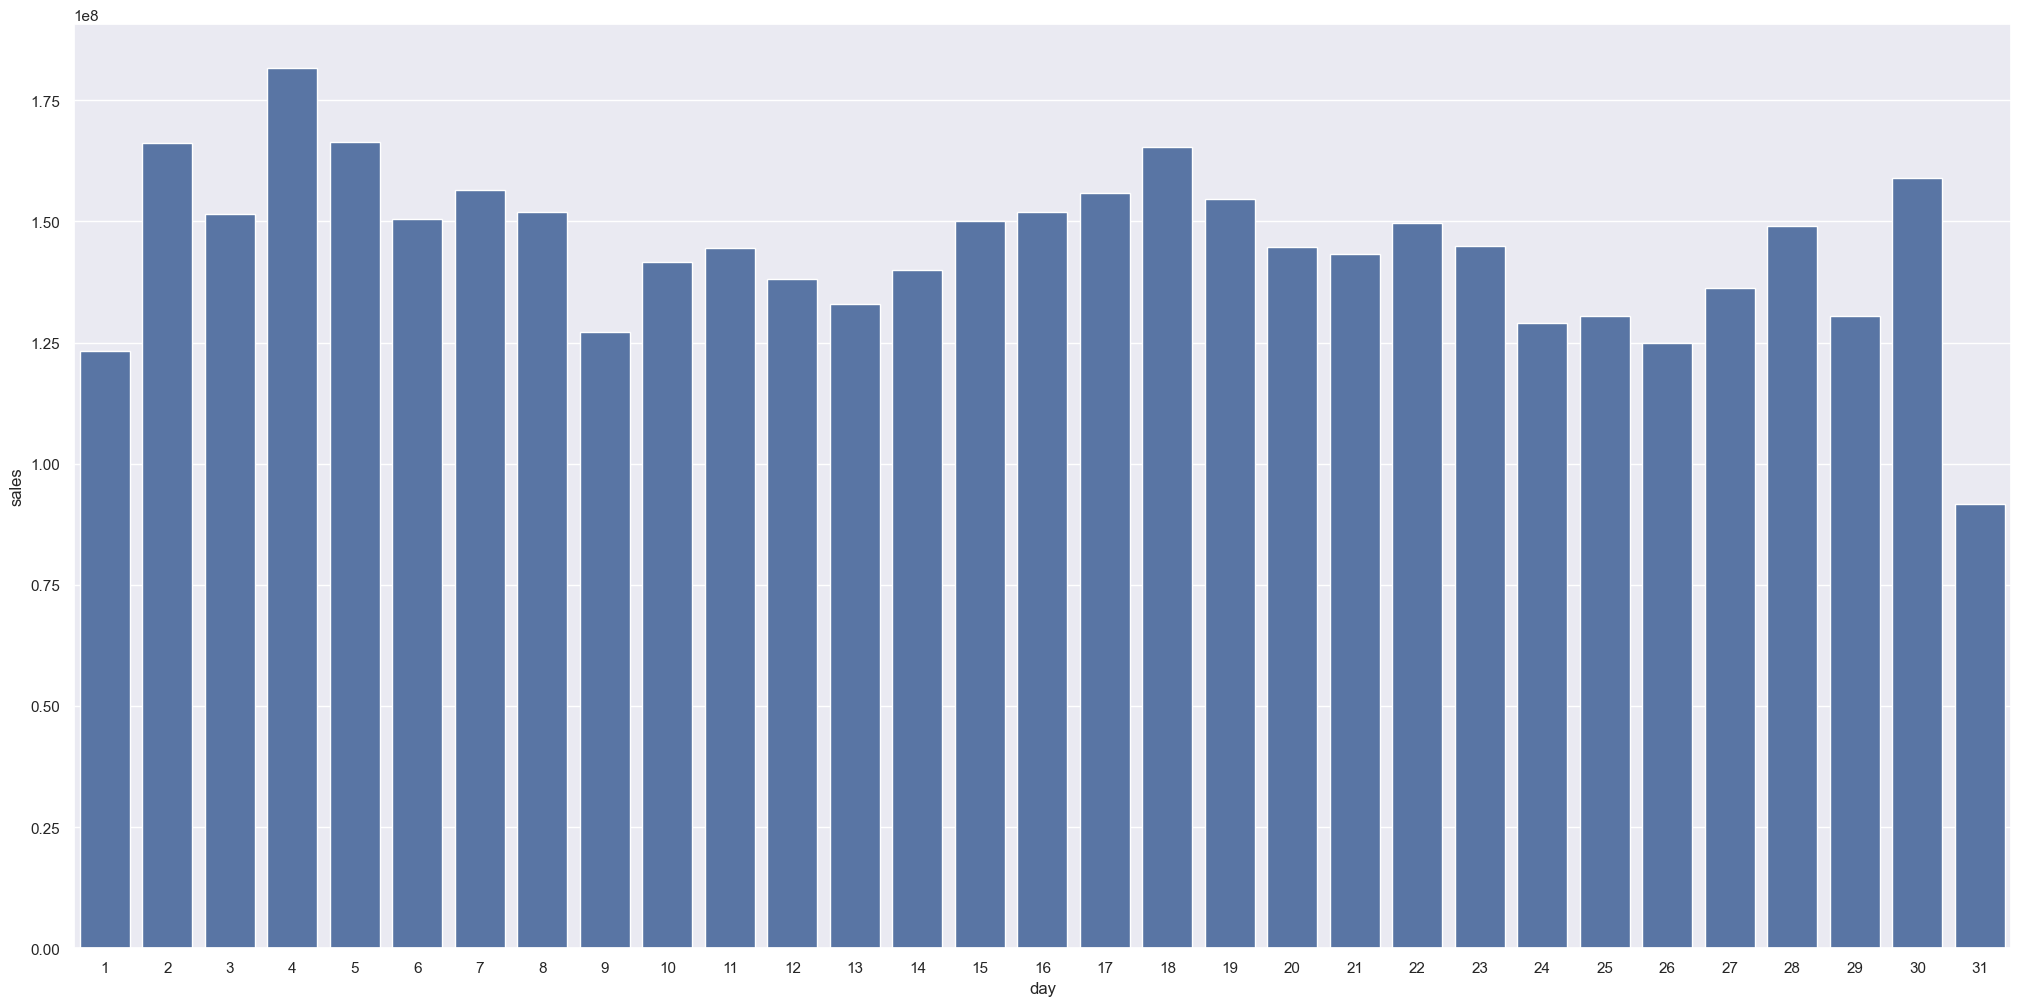

In [108]:
#aux = df4[df4['day'] > 10]
#aux1 =  aux[['day','sales']].groupby(['day']).sum()

#aux2 = df4[df4['day'] < 10]
#aux3 =  aux2[['day','sales']].groupby(['year','month','day']).sum()

#vamos descartar o ano 2015 pois não está completo
aux = df4[df4['year'] != 2015]
aux1 =  aux[['day','sales']].groupby(['day']).sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1)



In [109]:
 aux1['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

<Axes: xlabel='day', ylabel='sales'>

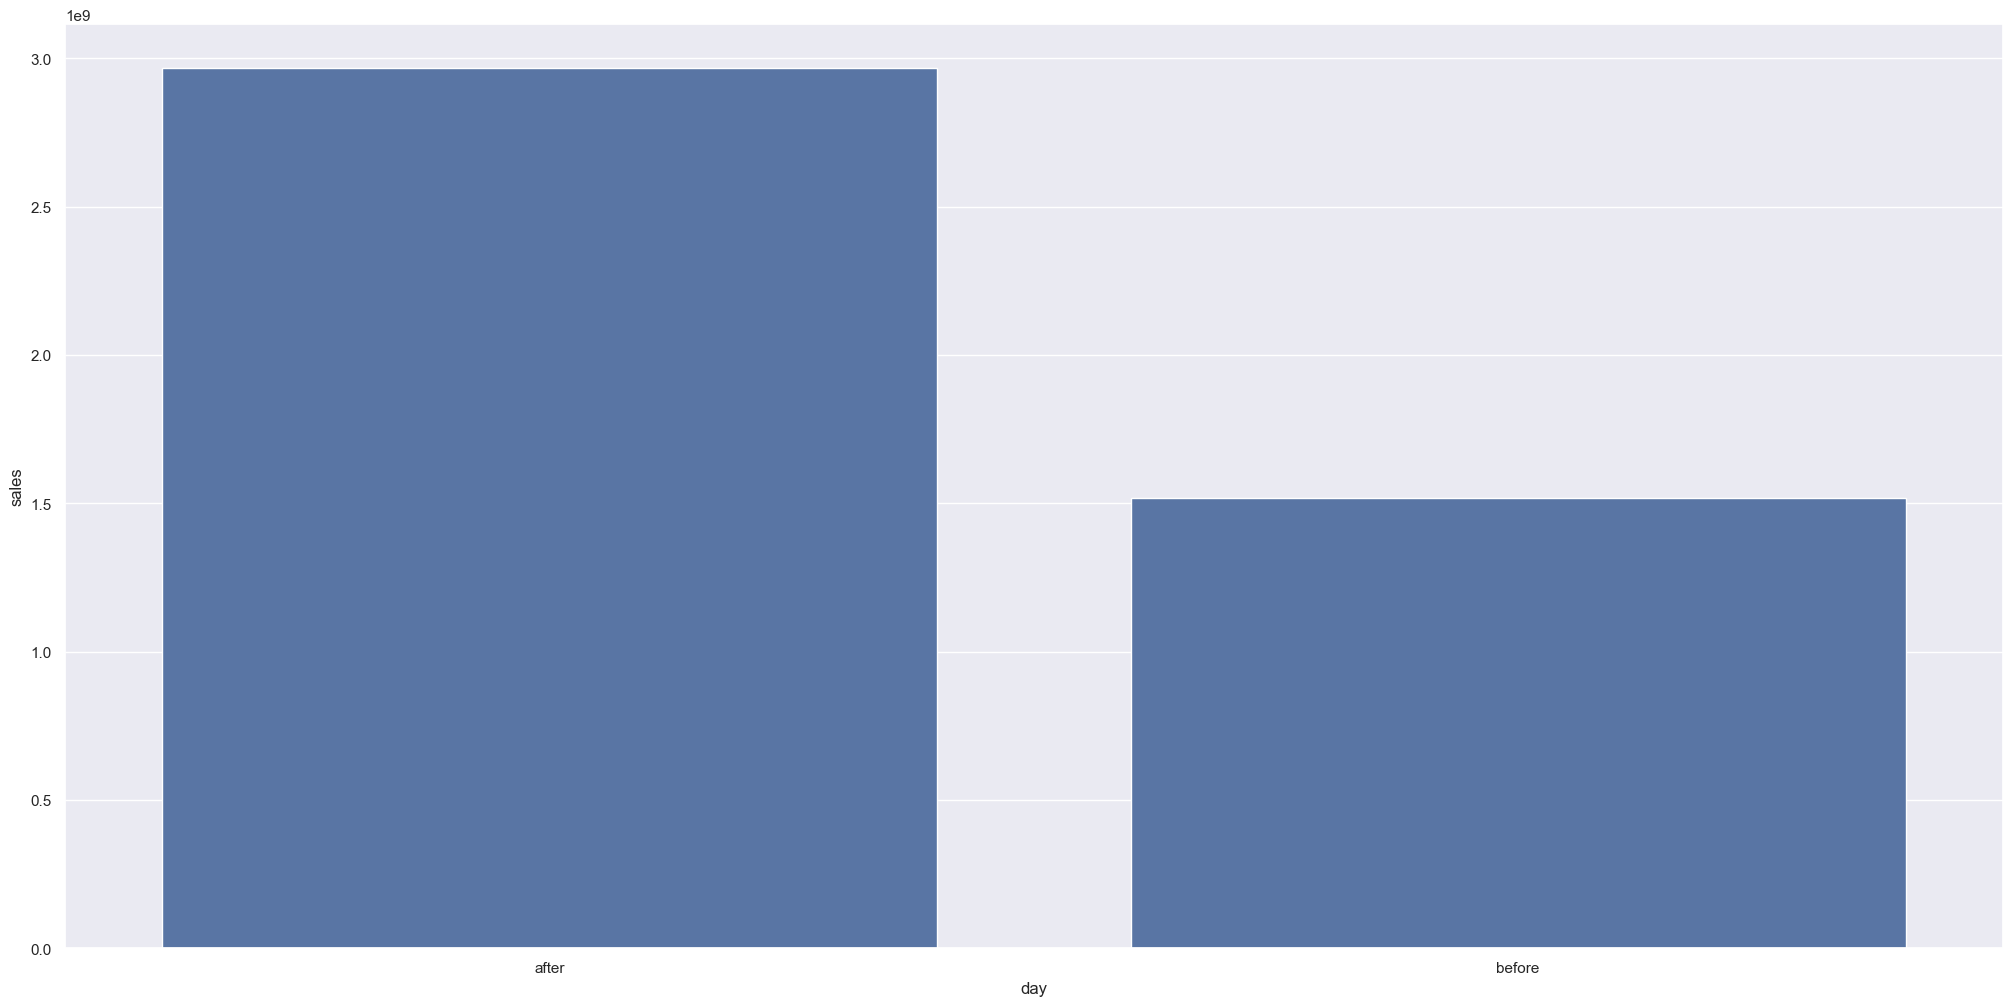

In [110]:
#import numpy as np

## Suponha que seu DataFrame seja chamado 'df'
aux1['day'] = np.where(aux1['day'] <= 10, 'before', 'after') # Se rodar duas vezes essa linha dar erro
aux2 = aux1[['sales', 'day']].groupby('day').sum()#.reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux2 )


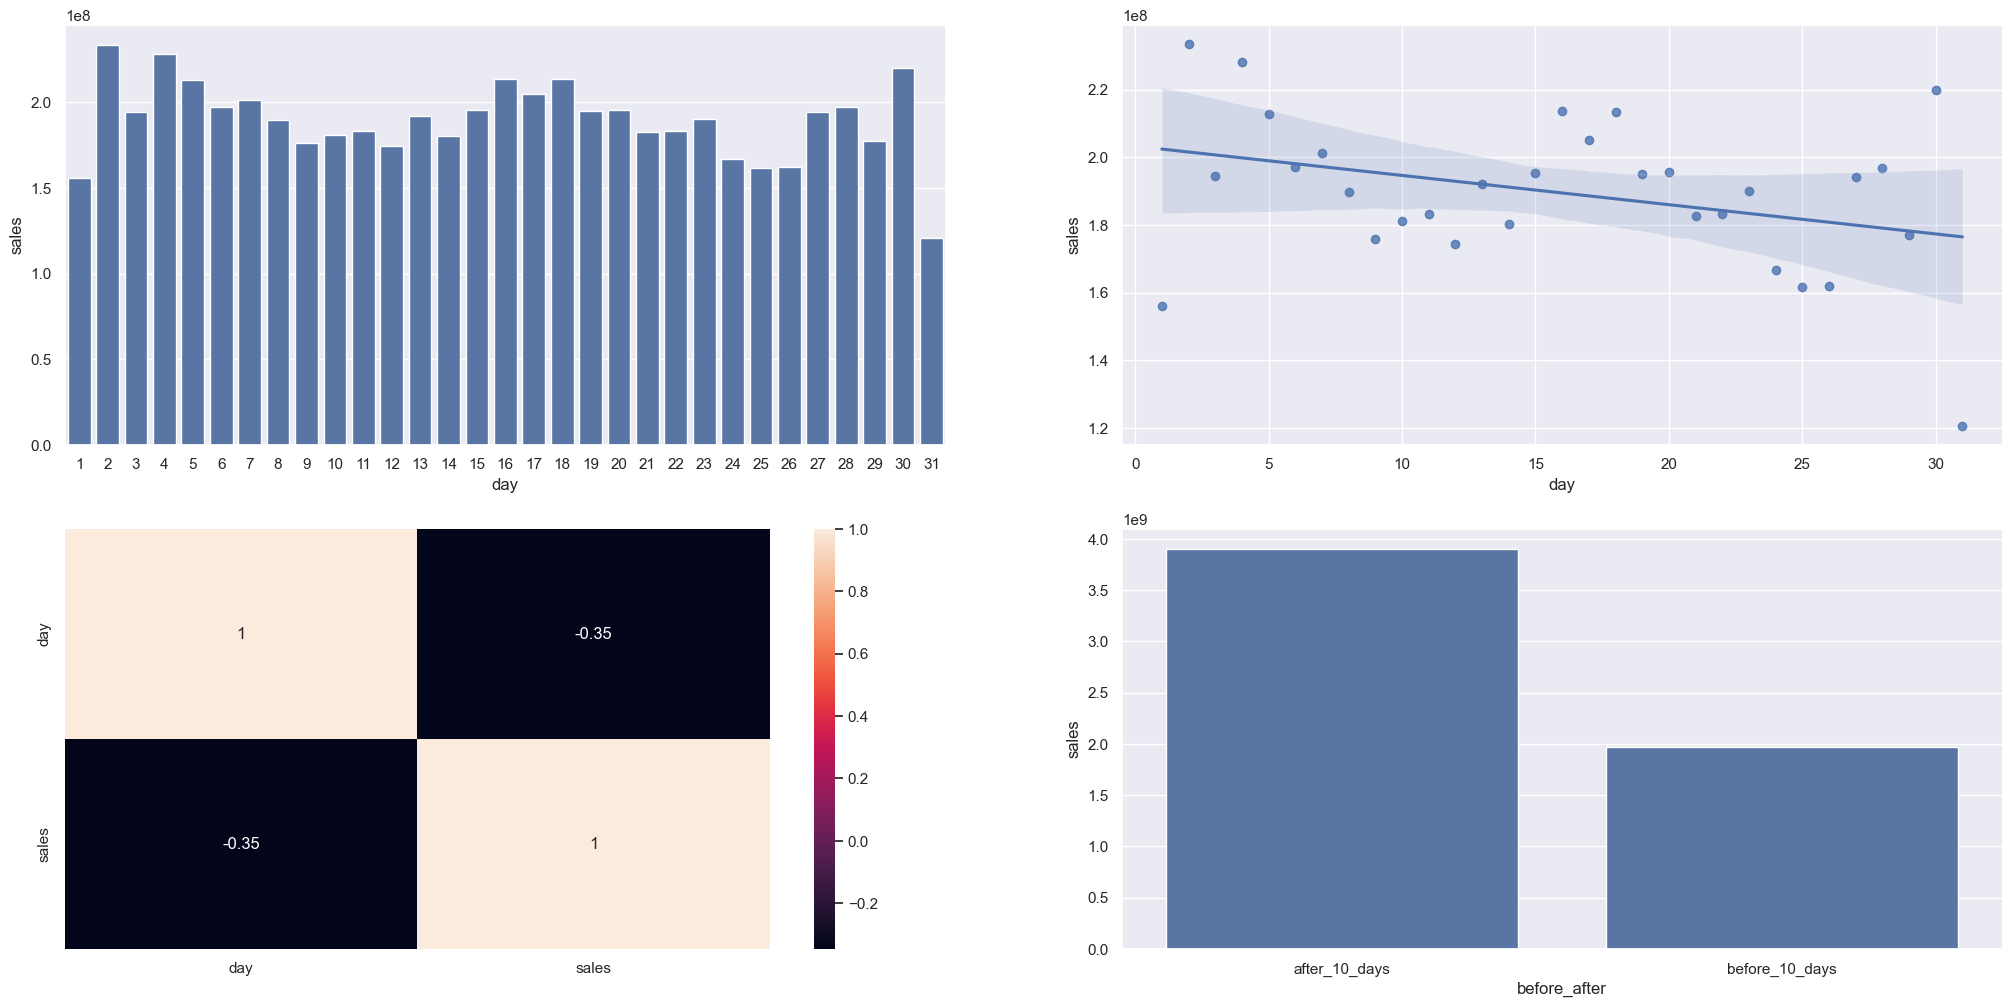

In [111]:
#Como o professor fez!
# Selecinou as duas variáveis envolvidas
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
#plotou elas em regressão
sns.regplot( x='day', y='sales', data=aux1 );

#fez uma correlação
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

## 5.2.11 H12. Lojas deveriam vender menos aos finais de semana.
VERDADEIRA Lojas vendem menos nos final de semana

In [112]:
df4.head(4)

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  Duration_of_competition_in_years
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic                1270.0                             9                         2008       0                 31               2015         0  2015      7   31            31   2015-30        2008-09-01                      84  2015-07-27                0                                 7
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic                 570.0                            11                         2007       1                 13               2010         1  2015      7   31            31   2015-30        2007-11-01                      94  2010-03-22              279                                 8
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic               14130.0                            12                         2006       1                 14               2011         1  2015      7   31            31   2015-30        2006-12-01                     105  2011-03-28              226                                 9
3      4            5 2015-07-31  13995      1   regular_day               1          c   extended                 620.0                             9                         2009       0                 31               2015         0  2015      7   31            31   2015-30        2009-09-01                      71  2015-07-27                0                                 6

 Quais colunas ou entidades que estão envolvidas :
 * sales
 * day_of_week
 * 		 


In [113]:
aux

<Axes: >

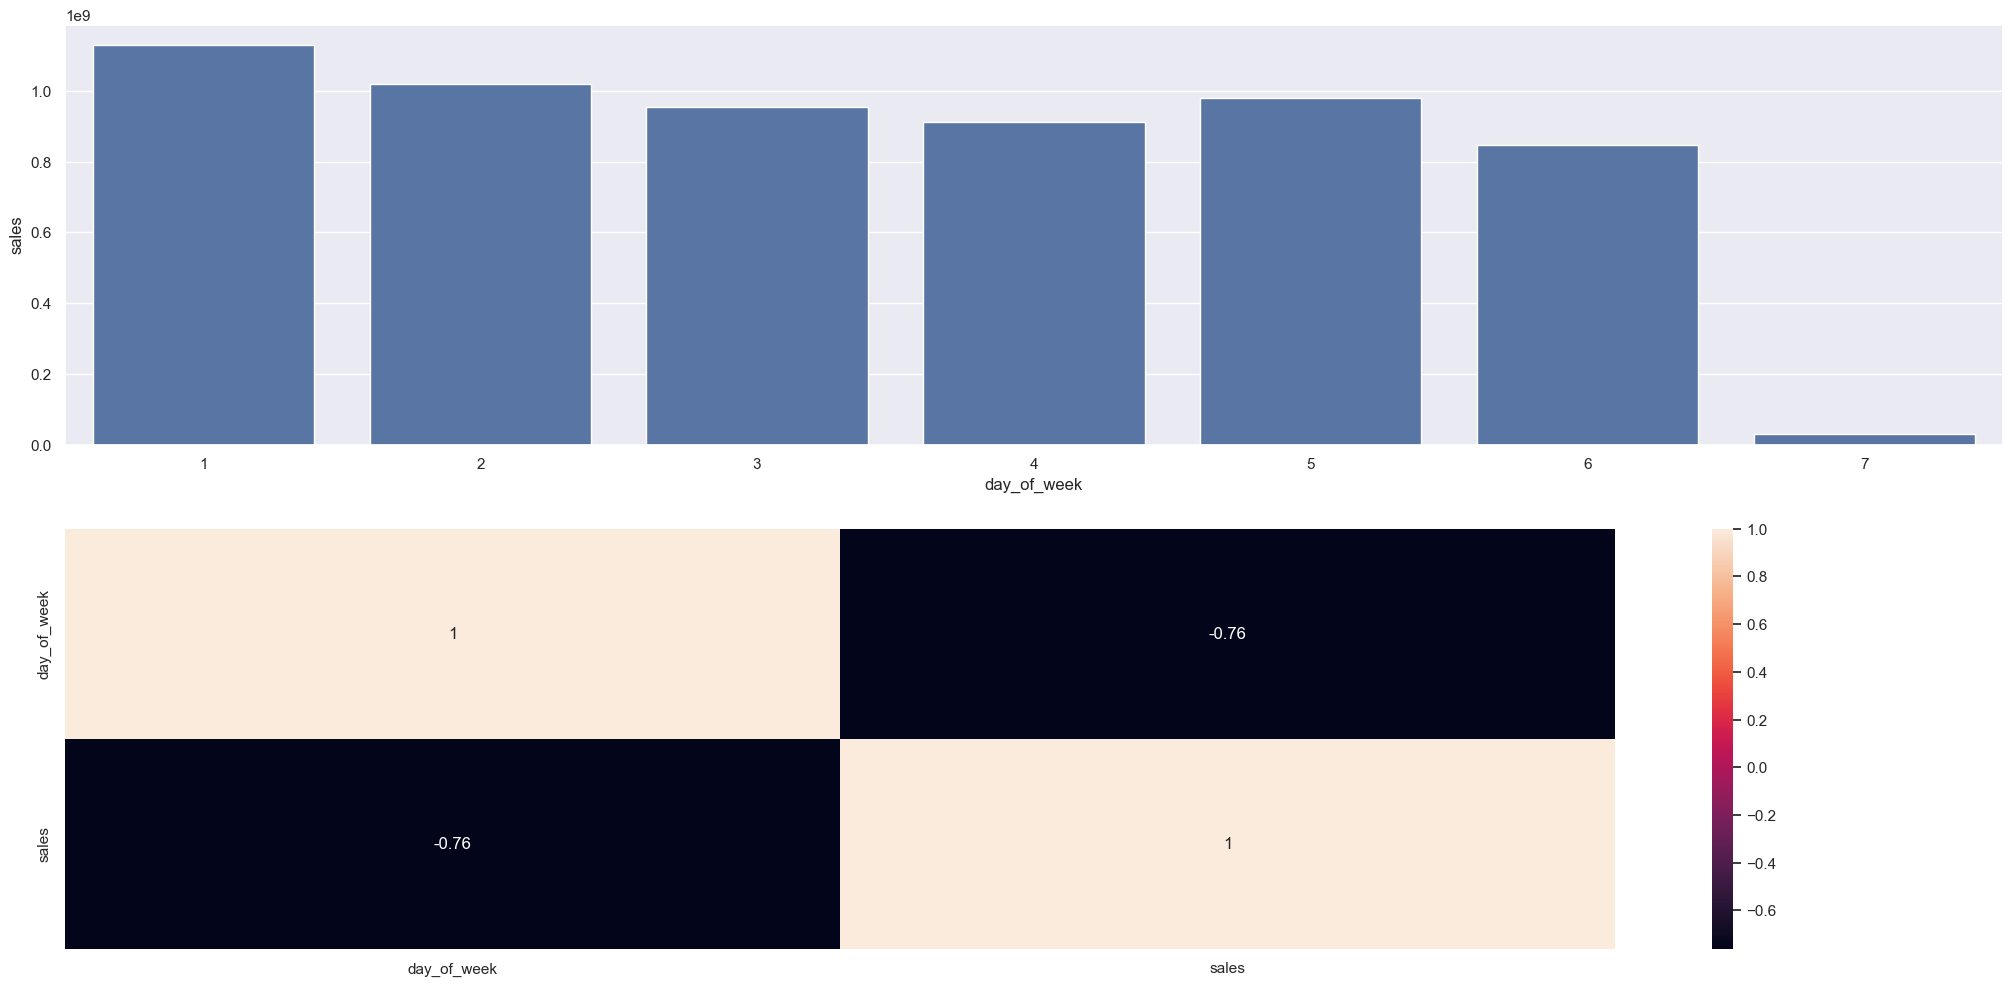

In [114]:

aux = df4[['sales','day_of_week']].groupby('day_of_week').sum().reset_index()

#aux.astype(int)
plt.subplot(2, 1 , 1)
sns.barplot(x =  'day_of_week', y =  'sales', data = aux)

plt.subplot(2, 1 , 2)
sns.heatmap(aux.corr( method = 'pearson'), annot = True )


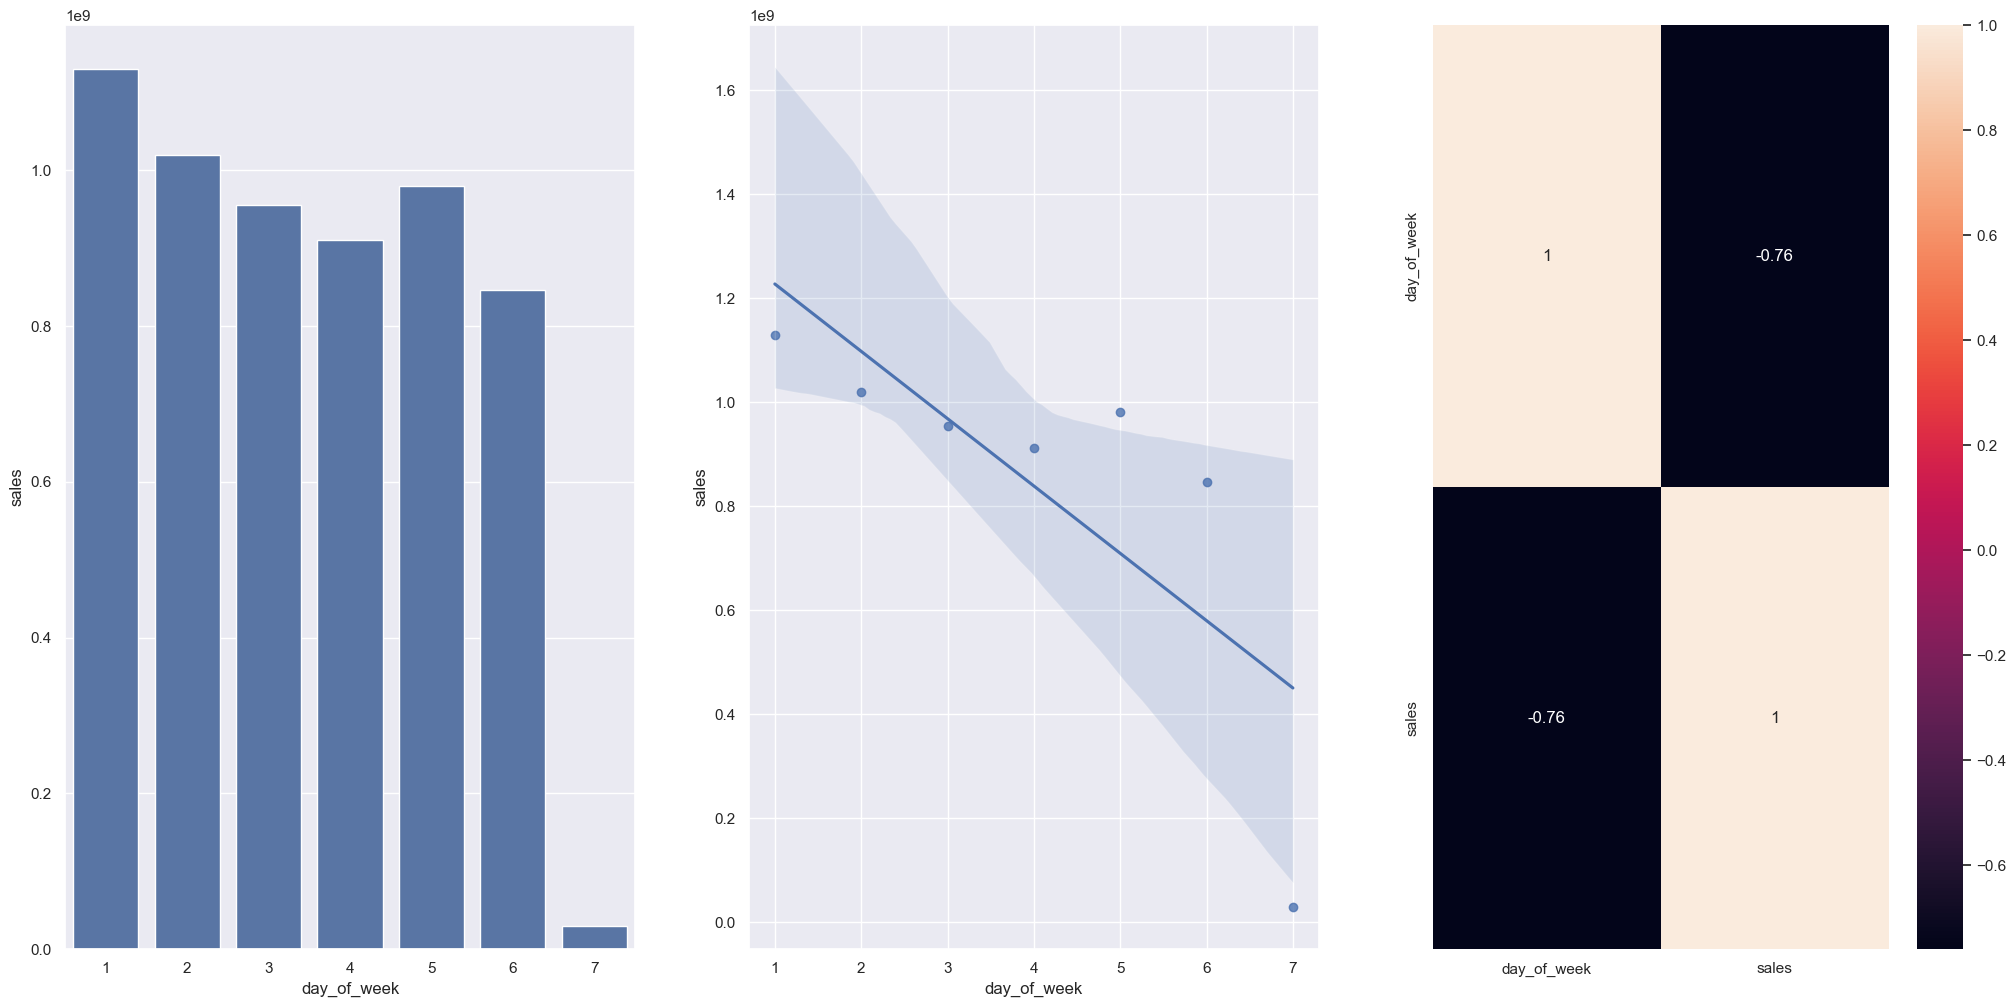

In [115]:
# como o professor fez
#Selecionou duas culnas dias da semana e vendas
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



## 5.2.12 H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, except os meses de Julho e
Agosto.

As colunas que trazem a resposta a hipóteses são:
 * sales
 * year
 * month

In [116]:
#promo_interval     
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May',
 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9: 'Sep', 10: 'Oct', 11 :'Nov', 12 : 'Dec'}  





In [117]:
df4['school_holiday'].unique()

array([1, 0], dtype=int64)

<Axes: xlabel='month'>

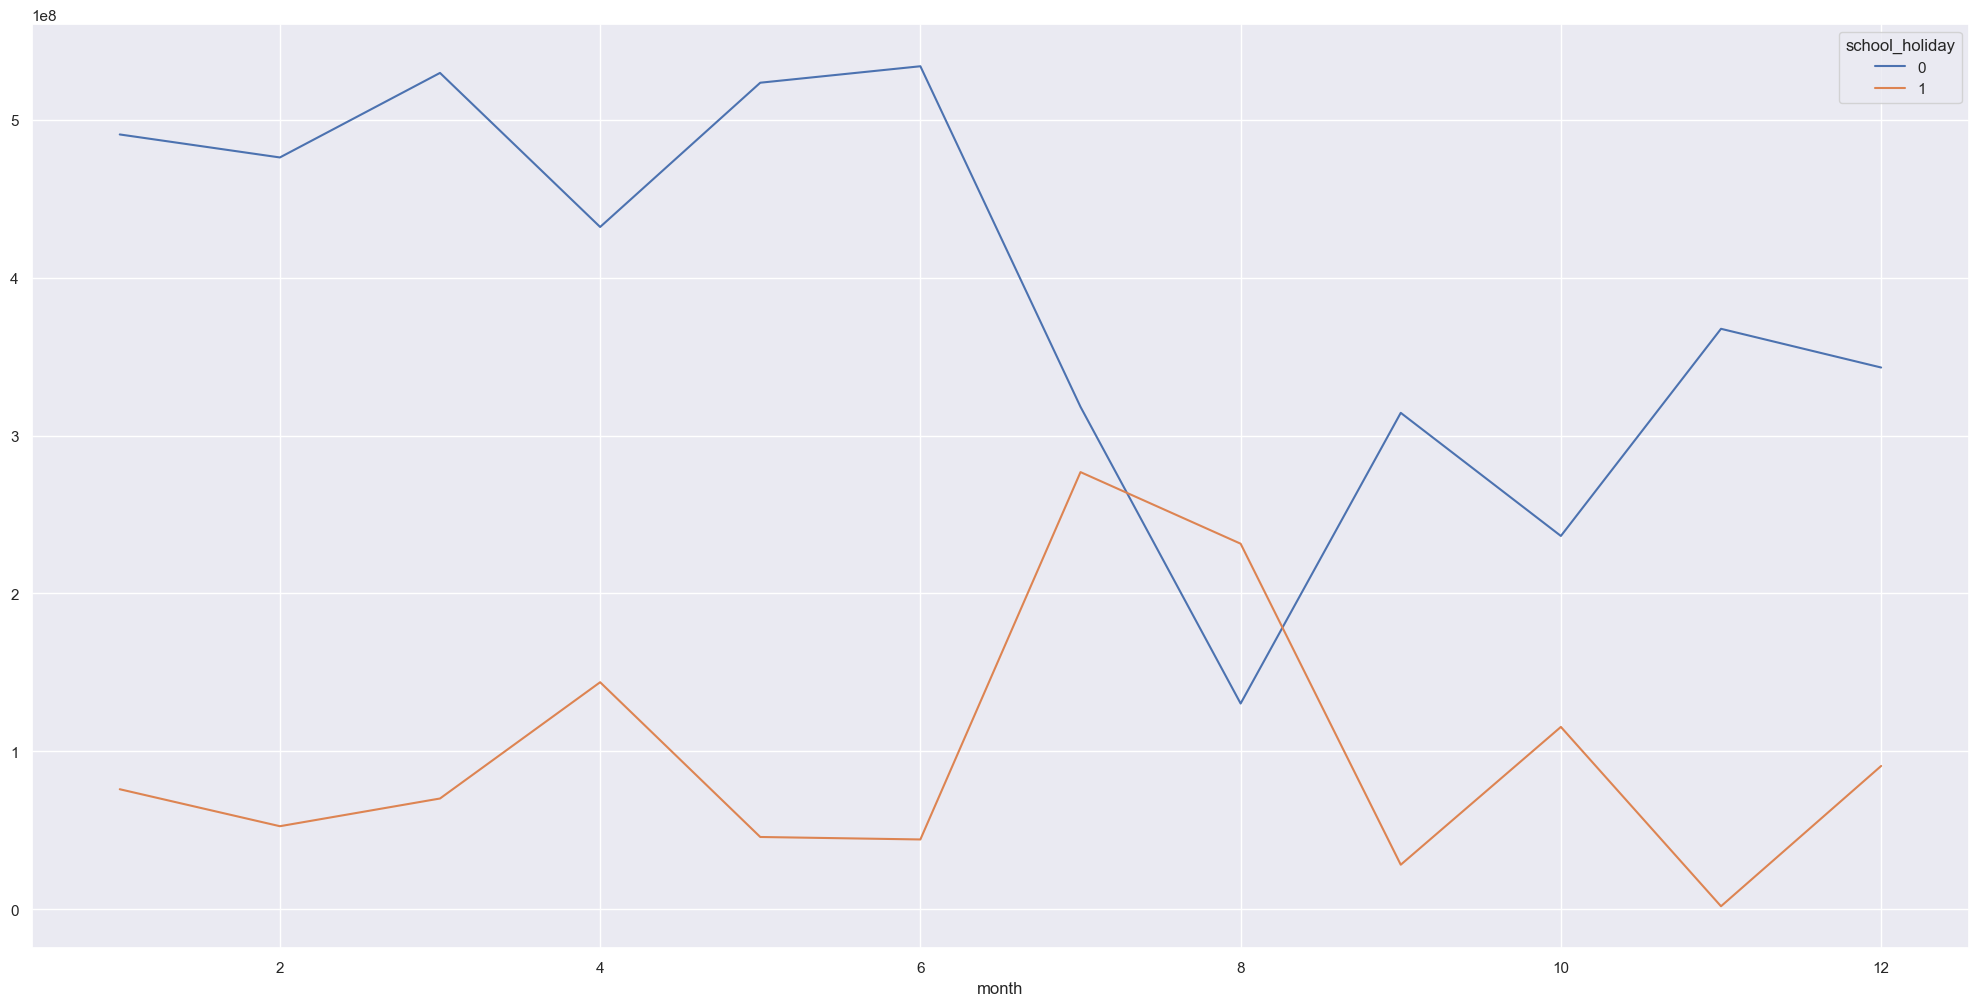

In [118]:
#aux = df4[df4 ['school_holiday'] == 1 ]

aux = df4[['school_holiday','month','sales']].groupby(['school_holiday','month']).sum().reset_index()



aux.pivot(index= 'month' ,  columns = 'school_holiday', values ='sales' ).plot()

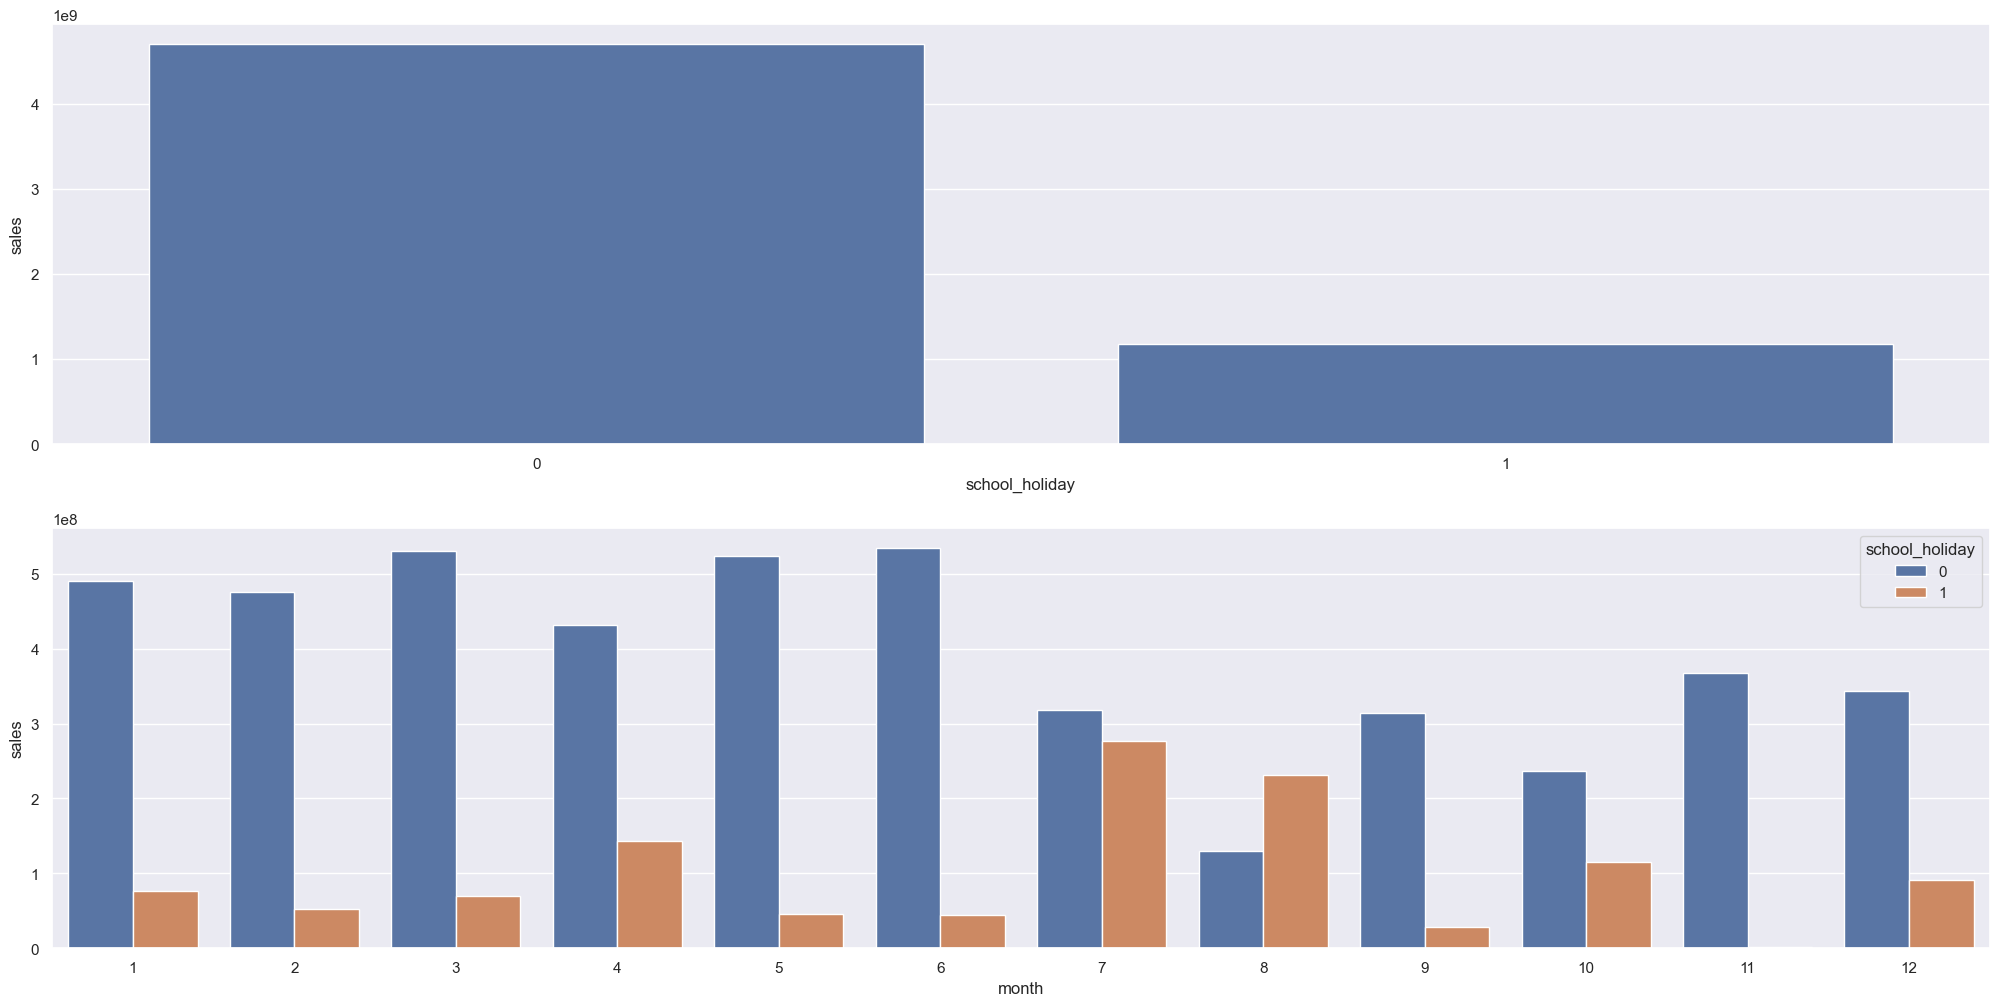

In [119]:
#Como professor fez!
# Ele selecionou duas 
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );



## 5.2.13  Resumo das Hipoteses


In [120]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


# 5.3  Analise Multivariada

## 5.3.1 Numerical Attributes


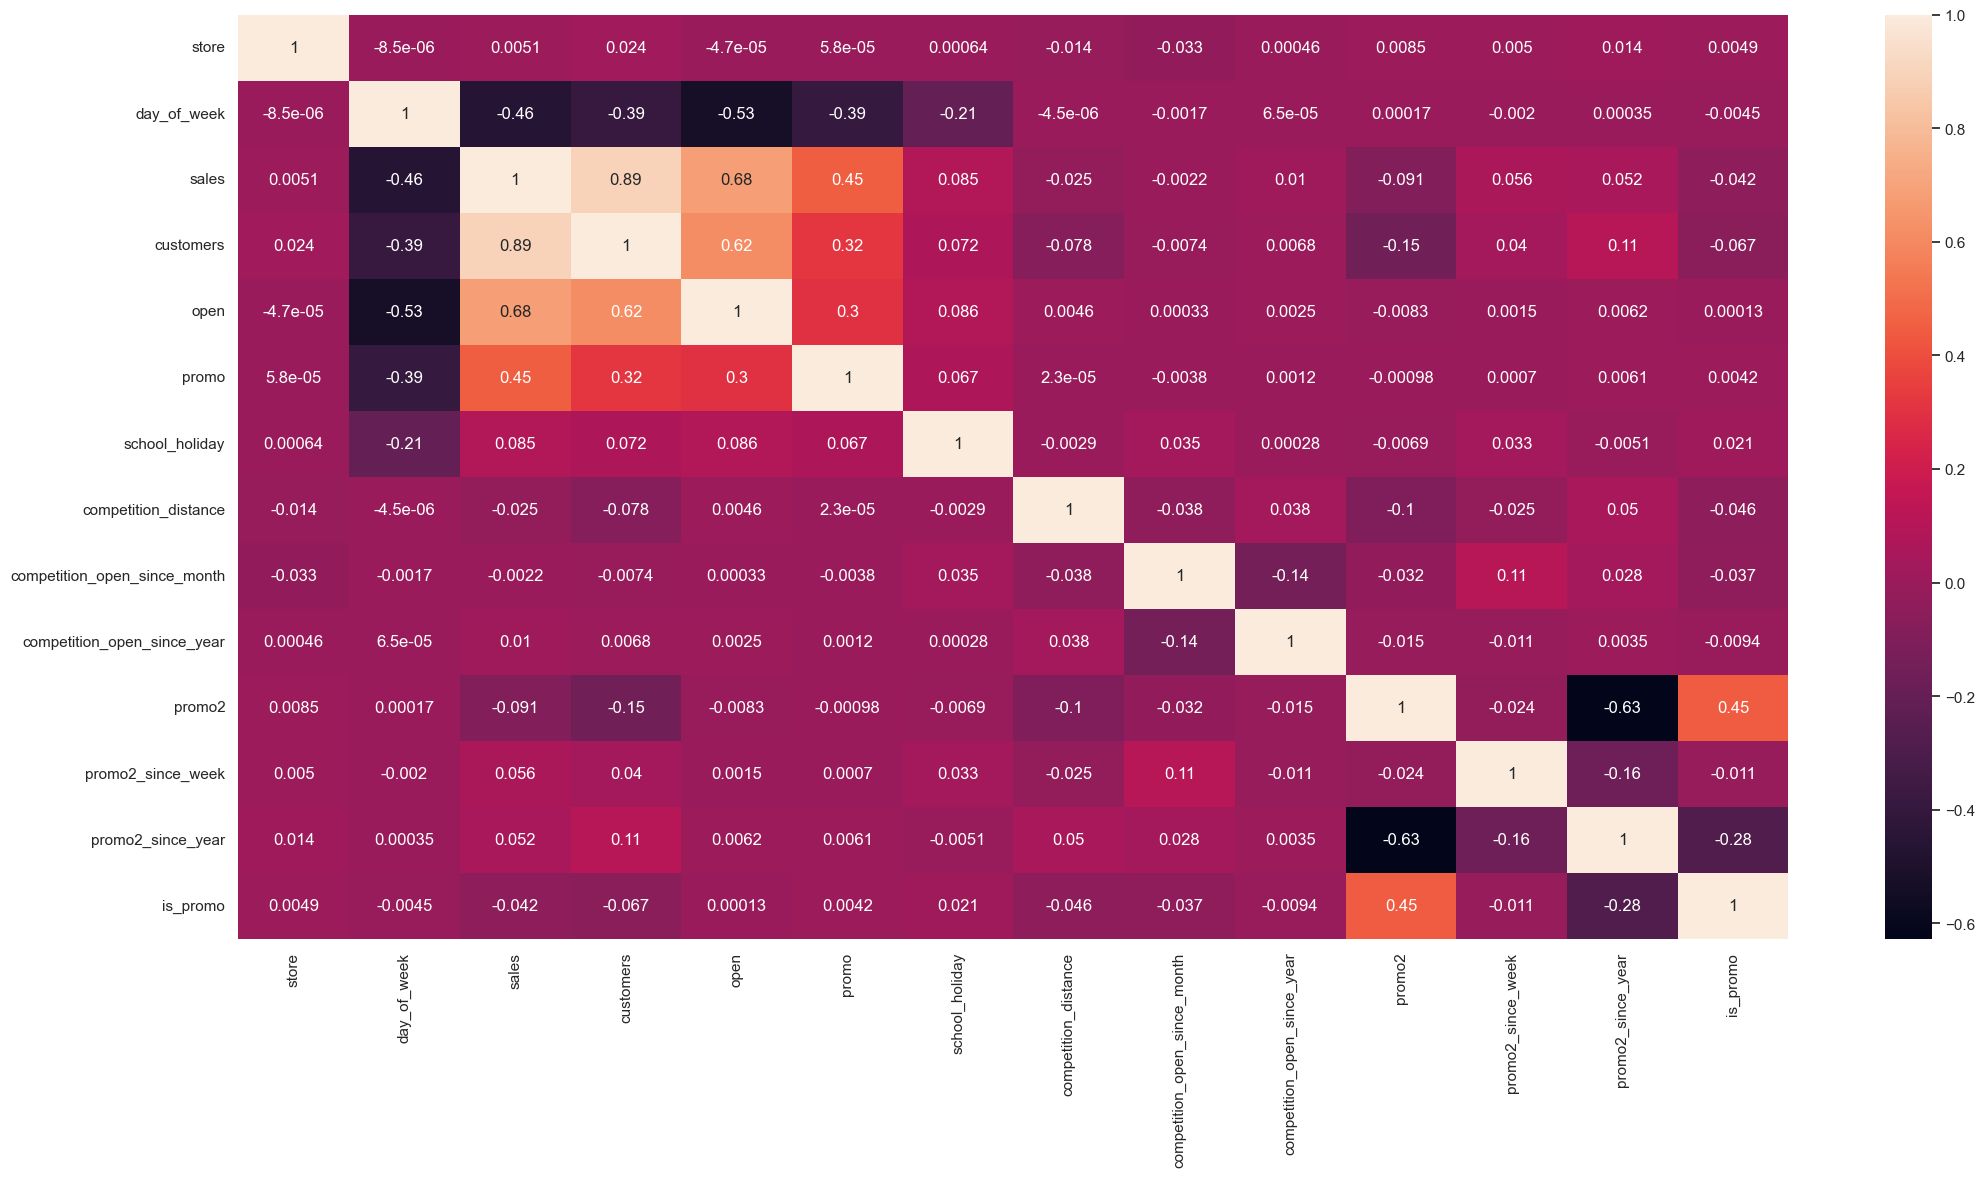

In [121]:
correlation = num_atributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

In [122]:
a.head(4)

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
258    259            5 2015-07-31  14096      1   regular_day               1          b      extra                 210.0                             7                         2015       0                 31               2015         0  2015      7   31            31   2015-30        2015-07-01                       1  2015-07-27                0
273    274            5 2015-07-31   6975      1   regular_day               1          b      extra                3640.0                             7                         2015       1                 10               2013         1  2015      7   31            31   2015-30        2015-07-01                       1  2013-03-04              125
352    353            5 2015-07-31   7851      1   regular_day               1          b      extra                 900.0                             7                         2015       1                 14               2013         0  2015      7   31            31   2015-30        2015-07-01                       1  2013-04-01              121
511    512            5 2015-07-31   8548      1   regular_day               0          b      extra                 590.0                             7                         2015       1                  5               2013         0  2015      7   31            31   2015-30        2015-07-01                       1  2013-01-28              130

In [123]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
#a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
#a2 = cramer_v( a['state_holiday'], a['store_type'] )
#a3 = cramer_v( a['state_holiday'], a['assortment'] )

#a4 = cramer_v( a['store_type'], a['state_holiday'] )
#a5 = cramer_v( a['store_type'], a['store_type'] )
#a6 = cramer_v( a['store_type'], a['assortment'] )
#a7 = cramer_v( a['assortment'], a['state_holiday'] )
#a8 = cramer_v( a['assortment'], a['store_type'] )
#a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
#d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  #  'store_type'  : [a4, a5, a6],
                  #  'assortment'  : [a7, a8, a9] })
#d = d.set_index( d.columns )
#sns.heatmap( d, annot=True )


#6. PASSO 05 - DADTA PREPARATION

# 6. PASSO 6 -  DATA PREPARATION

In [124]:
df5 = df4.copy()

## 6.1 -  Normalização

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

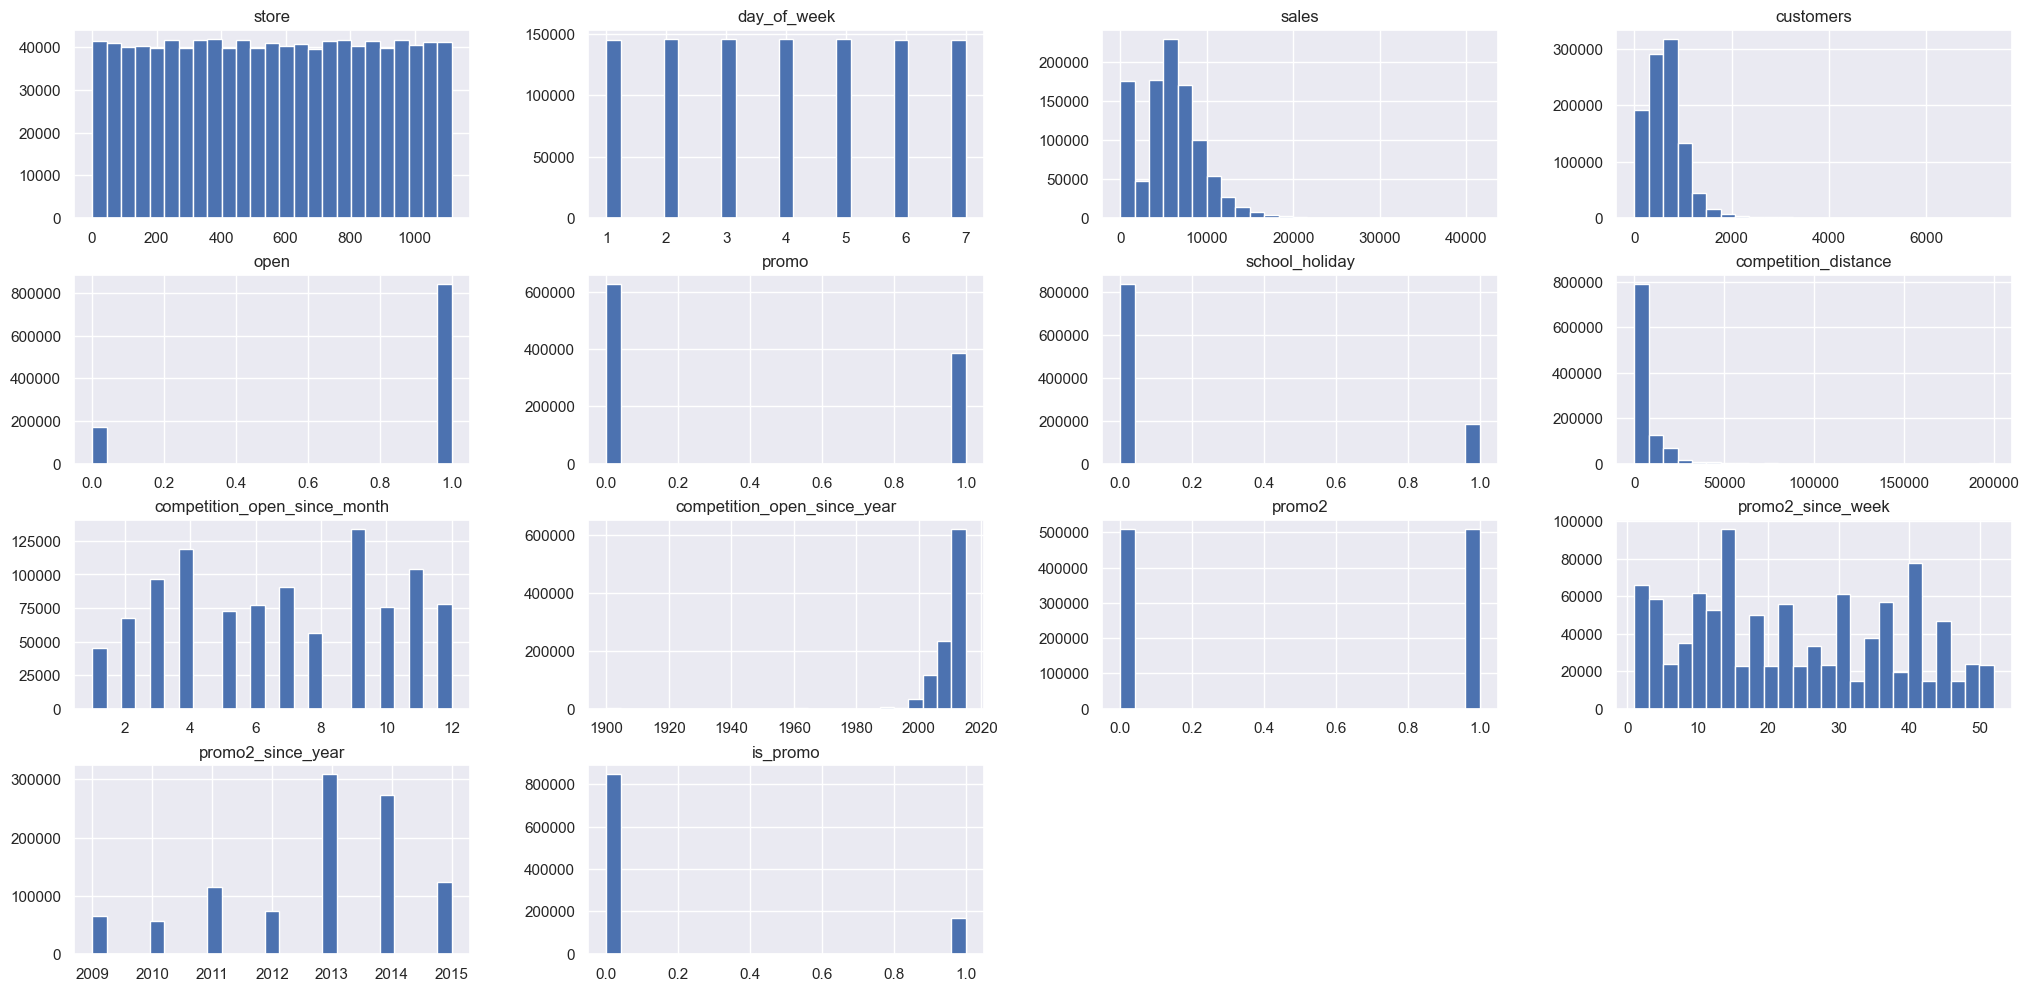

In [125]:
# Como pode observar não existem gráficos com formato de normal ou Gaussina, portando não iremos aplicar o processo de normalização que tem a fórmula
# = (Xobservado - a média) / Desvio Padrão
num_atributes.hist( bins = 25)

## 6.2 Rescaling

In [126]:
#Foram rescalados algumas colunas, que tinha um grande range elas são: 
# df5.loc[:,['competition_distance', 'competition_time_month', 'promo_time_week', 'year']
# iremos verifica se existem muitos outliers, amos verificar cada coluna a quantidade de outliers, se tiver muito, trabalhamos o range por meio do 
#RobustScaler, pois ele trabalha com na sua fórmula,  = o ponto local - primeiro quartil )/ terceiro quartil - primeiro quartil primeiro, se não pode
# usa o  MinMaxScaler(), sendo sua fórmula = (Xi(ponto observado) - Média )/ 3Quartil - 1 Quartil


In [ ]:
#sns.barplot(df5['competition_distance']) uma forma de analisa a quantidade de utilier é quartil, mas meu pc não está coseguindo roda, então vamos
# volta a utilizar google colab

In [128]:
#sns.barplot(df5['competition_time_month'])

In [ ]:
#sns.barplot(df5['promo_time_week'])

In [ ]:
#df5.loc[:,['competition_distance', 'competition_time_month', 'promo_time_week', 'year']].head()

In [130]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# year
df5['year'] = mms.fit_transform( df5[['year']].values )

In [131]:
df5.loc[:,['competition_distance', 'competition_time_month', 'promo_time_week', 'year']].head()

competition_distance  competition_time_month  promo_time_week  year
0             -0.170968                0.918919         0.287016   1.0
1             -0.283871                1.054054         0.922551   1.0
2              1.903226                1.202703         0.801822   1.0
3             -0.275806                0.743243         0.287016   1.0
4              4.448387               -0.162162         0.287016   1.0

## 6.3 Transformação

### 6.3.1 Encoding

In [143]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

KeyError: "None of [Index(['state_holiday'], dtype='object')] are in the [columns]"

In [136]:
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
df5['store_type'].head()

0    2
1    0
2    0
3    2
4    0
Name: store_type, dtype: int32

In [137]:
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### Response Variable Transformation

In [141]:
df5['sales'] = np.log1p( df5['sales'] )

### 6.3.3.  Nature Transformation

In [142]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )

df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )


In [144]:
df5.head()


store  day_of_week       date     sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  Duration_of_competition_in_years  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day  day_of_week_sin  day_of_week_cos  month_sin  month_cos   day_sin   day_cos  week_of_year_sin  week_of_year_cos
0      1            5 2015-07-31  8.568646      1               1           2           1             -0.170968                             9                         2008       0                 31               2015         0   1.0      7   31            31   2015-30        2008-09-01                0.918919  2015-07-27         0.287016                                 7                    False                         False                         False                       True        -0.974928        -0.222521       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984
1      2            5 2015-07-31  8.710290      1               1           0           1             -0.283871                            11                         2007       1                 13               2010         1   1.0      7   31            31   2015-30        2007-11-01                1.054054  2010-03-22         0.922551                                 8                    False                         False                         False                       True        -0.974928        -0.222521       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984
2      3            5 2015-07-31  9.025816      1               1           0           1              1.903226                            12                         2006       1                 14               2011         1   1.0      7   31            31   2015-30        2006-12-01                1.202703  2011-03-28         0.801822                                 9                    False                         False                         False                       True        -0.974928        -0.222521       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984
3      4            5 2015-07-31  9.546527      1               1           2           3             -0.275806                             9                         2009       0                 31               2015         0   1.0      7   31            31   2015-30        2009-09-01                0.743243  2015-07-27         0.287016                                 6                    False                         False                         False                       True        -0.974928        -0.222521       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984
4      5            5 2015-07-31  8.481151      1               1           0           1              4.448387                             4                         2015       0                 31               2015         0   1.0      7   31            31   2015-30        2015-04-01               -0.162162  2015-07-27         0.287016                                 0                    False                         False                         False                       True        -0.974928        -0.222521       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984